This notebook aims to conduct feature engineering for our PD Model. Order of feature engineering is as followed:

1. Creation of Features
2. Feature Selection via IV <-> WoE binning selected features

This sequence is chosen due to the following reasons:

- Reduce chance of discarding features, which may only become useful after feature engineering
- Generating interaction features allow me to rank / select variables which are relevant and useful for PD Modeling
- Multicollinearity checks can be conducted once, instead of being repeated multiple times

# 0. Import Libraries


In [1]:
# === Standard libraries ===
import os


# === WandB Logging  ===
import wandb

wandb.login(key=os.getenv("WANDB_API_KEY"))


# === Spark Session & Functions ===
from init_spark import start_spark

spark = start_spark()
from pyspark.sql.functions import (
    col,
    when,
    count,
    desc,
    isnan,
    isnull,
    lit,
    length,
    trim,
    lower,
    upper,
    to_date,
    concat_ws,
    regexp_extract,
    mean,
)
from pyspark.sql.types import (
    StructType,
    StructField,
    StringType,
    DoubleType,
    IntegerType,
    DateType,
    NumericType,
    FloatType,
    LongType,
)


# === Pandas Dataframe & WoE Binning ===
import pandas as pd
from tabulate import tabulate
from optbinning import OptimalBinning
import numpy as np

# == Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

# === Machine Learning ===
from sklearn.linear_model import LogisticRegression as SkLogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    ConfusionMatrixDisplay,
)

# == Optbinning ==
from optbinning import OptimalPWBinning


# === Load Environment Variables ===
from dotenv import load_dotenv

load_dotenv()

# == Global Functions ==
from functions import *
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc
wandb: Currently logged in as: wlunlun1212 (wlunlun1212-singapore-management-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/11 22:33:13 WARN Utils: Your hostname, Chengs-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.77 instead (on interface en0)
25/08/11 22:33:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/Users/lunlun/Downloads/Github/Credit-Risk-Modeling-PySpark/venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Defau

4.0.0


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc


In [2]:
# ============ Constants ======================

TARGET_COL = "default_status"
SAMPLE_FRAC = 0.1
SEED = 42
NOTEBOOK_RUN_NAME = "Feature Engineering"

IV_THRESHOLDS = {
    "useless (< 0.02)": 0.02,
    "weak (< 0.1)": 0.1,
    "medium (< 0.3)": 0.3,
    "strong (< 0.5)": 0.5,
}

# === Feature Categorisation ===
iv_categories = {
    "useless (< 0.02)": [],
    "weak (< 0.1)": [],
    "medium (< 0.3)": [],
    "strong (< 0.5)": [],
    "suspicious": [],
    "no_variation": [],
}

In [3]:
# ====================== Reusable Functions ======================


# == 1. Feature Engineering ==
def add_ratio_with_flag(df, numerator, denominator, ratio_col, flag_col, fill_value=-1):
    """
    Adds flag column to indicate invalid value upon division. Adds engineered feature column, and fills -1 upon invalid
    division operation.

    Parameters
    ----------
    df: str
        Spark Dataframe

    numerator: str
        Numerator Column Name
    denominator: str
        Denominator Column Name

    ratio_col: str
        Engineered Feature Name (Create Yourself)

    flag_col: str
        For e.g. annual_inc/loan_ratio_invalid

    fill_value: int
        Default: -1 (Placeholder in flag column, if invalid division operation)

    Returns
    -------
    Spark Dataframe with new columns (flag and divided column)
    """
    # ==  invalid denom (null or <= 0) -> 0 or -1 will be in flag columnis ==
    df = df.withColumn(
        flag_col,
        when(
            (col(denominator).isNull()) | (col(denominator) <= 0), 1
        ).otherwise(  # invalid → 1
            0
        ),  # valid → 0
    )

    # == safe ratio: real divide only when valid, else sentinel ==
    df = df.withColumn(
        ratio_col,
        when(col(flag_col) == 0, col(numerator) / col(denominator)).otherwise(
            lit(fill_value)
        ),
    )
    return df


# == 2. Feature Selection (WoE & IV) ==
def get_numerical_cols(df, target_col):
    """
    Get numerical columns of a Spark Dataframe and return list of numerical columns,
    excluding 'default_status'

    Parameters
    -----------

    df: Dataframe
        Spark Dataframe

    target_col: str
        default_status

    """
    return [
        f.name
        for f in df.schema.fields
        if isinstance(f.dataType, NumericType) and f.name != target_col
    ]


def get_categorical_cols(df, target_col):
    """
    Get categorical columns of a Spark Dataframe and return list of
    string columns

    Parameters
    -----------

    df: Dataframe
        Spark Dataframe

    target_col: str
        default_status

    """
    return [
        f.name
        for f in df.schema.fields
        if isinstance(f.dataType, StringType) and f.name != target_col
    ]


def classify_iv(iv_categories, feature, iv_score):
    """Adds 1 feature into respective IV categories of iv_categories dictionary"""
    for label, threshold in IV_THRESHOLDS.items():
        if iv_score < threshold:
            iv_categories[label].append((feature, iv_score))
            return

    iv_categories["suspicious"].append((feature, iv_score))


def bin_and_classify_feature(
    feature,
    x,
    y,
    dtype="numerical",
    monotonic_trend_type="auto",
    min_bin_size=0.05,
    max_n_bins=5,
    iv_categories=iv_categories,
):
    """
    Sample first before attempting to inspect binning & classifying into different IV Categories.
    Ensure only train_df (Pandas) fed in this function

    - Conducts Optimal Binning on a feature.
    - Outputs WoE table & Plot (to observe monotonic trend)
    - Categorises 1 feature into `iv_categories` dictionary

    Parameters
    ----------
    - feature: str
            Name of Feature
    - x: series
            e.g. train_df[feature]
    - y: series
            e.g. train_df['default_status']
    - dtype: str
            e.g. numerical (continuous /discrete / ordinal) & categorical (nominal) for OptBinning library
    - monotonic_trend_type: str
            e.g auto (default) / auto_asc_desc
    """

    # Fit binning with automatic solver
    optb = OptimalBinning(
        name=feature,
        dtype=dtype,
        monotonic_trend=monotonic_trend_type,
        min_bin_size=min_bin_size,  # min bin size is 1% (majority of our features have >= 1% outliers ... )
        solver="cp",
        max_n_bins=max_n_bins,
    )
    optb.fit(x, y)

    bin_table = optb.binning_table.build()

    #  Format binning table to display bins WoE & IV
    bin_df = pd.DataFrame(
        {
            "Bin": bin_table["Bin"].astype(str),
            "Count": round(bin_table["Count"], 4),
            "Default Rate (%)": round(bin_table["Event rate"], 4),
            "WOE": bin_table["WoE"],
            "IV": bin_table["IV"],
        }
    )

    # Get total IV for feature
    bin_df = bin_df[~bin_df["Bin"].str.contains("Total", na=False)]
    total_iv = bin_df.iloc[-1]["IV"]
    print(f"✅ Total IV for {feature}: {total_iv:.4f}")

    # Add feature to iv_categories
    classify_iv(iv_categories, feature, total_iv)

    # Print binning table
    print(tabulate(bin_df, headers="keys", tablefmt="fancy_grid", showindex=False))

    # Plot curve
    optb.binning_table.plot(metric="woe", figsize=(7, 4))


def tx_grade(df):
    """Takes in Pandas Dataframe and returns correct grade_numeric mapping from 'grade' column.
    This ensures ordinal natured of grade to be captured. Returns Pandas Dataframe."""
    # == Grade = Ordinal -> Dtype = `numerical` ==
    grade_map = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
    df["grade_numeric"] = df["grade"].map(grade_map)

    df = df.drop("grade", axis=1)

    return df


def get_updated_iv_categories(iv_categories, train_df):

    updated_iv_categories = {}
    for key, value in iv_categories.items():
        new_list = []
        if len(value) > 0 and key != "no_variation":
            for feature, iv_value in value:
                if feature in train_df.columns:
                    new_list.append((feature, iv_value))
            updated_iv_categories[key] = new_list
        else:
            continue

    return updated_iv_categories


def plot_iv_by_category(iv_categories):
    # === 1. Flatten into a clean DataFrame ===
    rows = []
    for category, items in iv_categories.items():
        for it in items:
            if isinstance(it, (tuple, list)) and len(it) >= 2:
                feature, iv = it[0], it[1]
                rows.append({"Feature": feature, "IV": float(iv), "Category": category})
            elif isinstance(it, str):
                rows.append({"Feature": it, "IV": 0.0, "Category": category})

    df_iv = pd.DataFrame(rows).sort_values(by="Feature")

    # === 2. Create faceted plots, showing only relevant features in each ===
    g = sns.catplot(
        data=df_iv,
        kind="bar",
        x="IV",
        y="Feature",
        col="Category",
        col_wrap=2,
        height=6,
        aspect=1.2,
        sharex=False,  # <== allow different x scales
        sharey=False,  # <== allow different features per facet
        palette="Set2",
    )

    g.figure.subplots_adjust(top=0.9, wspace=0.9)

    # === 3. Annotate bars ===
    for ax in g.axes.flat:
        for bar in ax.patches:
            width = bar.get_width()
            if width > 0:
                y = bar.get_y() + bar.get_height() / 2
                ax.text(width + 0.002, y, f"{width:.3f}", va="center", fontsize=8)

    # === 4. Final polish ===
    g.set_titles(col_template="{col_name}")
    g.set_xlabels("IV Score")
    g.set_ylabels("Feature")
    g.figure.suptitle("Information Value (IV) by Feature Category", fontsize=16)
    plt.show()
    return g


def peek_iv_score(updated_iv_categories, string_name, train_pdf):
    res_list = []
    for key, iv_list in updated_iv_categories.items():
        for feature, iv_score in iv_list:
            if (string_name in feature) and (feature in train_pdf.columns):
                res_list.append((feature, iv_score))

    return res_list


# == 3. WoE Transformation ==
def woe_bin_transform_train(df, non_mono_cols, target_col=TARGET_COL, monotonic="auto"):
    """
    Takes in train dataframe (Pandas)
    For each feature, separate Optbinning model is trained separately.
    If there are non-monotonic columns, use `auto_asc_desc` constraint in Optbinning

    Parameters
    -----------
    df: Pandas Dataframe
            train_pdf

    non_mono_cols: list
            non-monotonic columns

    target_col: str
            default_status (exists in train_pdf.columns)

    monotonic: str
            By default, monotonic='auto'
    """

    excluded_columns = ["id", "issue_d", "default_status", "earliest_cr_line"]
    loop_cols = [feature for feature in df.columns if feature not in excluded_columns]

    optb_dict = {}

    for column in loop_cols:
        # == Check if we should enforce monotonic trend on current feature ==
        if column in non_mono_cols:
            monotonic_trend = "auto_asc_desc"
        else:
            monotonic_trend = monotonic

        # == Determine dtype of current column ==
        if df[column].dtype == "object":
            dtype = "categorical"
        elif pd.api.types.is_numeric_dtype(df[column]):
            dtype = "numerical"
        else:
            continue  # skip unknown types

        optb = OptimalBinning(
            name=column,
            dtype=dtype,
            monotonic_trend=monotonic_trend,
            solver="cp",
            min_bin_size=0.05,
            max_n_bins=5,
        )

        try:
            optb.fit(df[column], df[target_col])
            df[column + "_woe"] = optb.transform(df[column].to_numpy(), metric="woe")
            df = df.drop(column, axis=1)
            optb_dict[column] = optb

        except Exception as e:
            print(f"❌ Error fitting {column}: {e}")

    return (df, optb_dict)


def apply_woe_transform(df, optb_dict):
    """
    Uses dictionary outputted by woe_bin_transform_train() to fit test dataframe,
    variable -> trainned Optbinning Model on train dataframe's feature.

    Transform each of test_pdf feature into `feature_woe`

    Parameters
    ----------
    df: Dataframe
            test_pdf

    optb_dict: dict
            Maps feature -> Optbinning Object
    """
    for column, optb in optb_dict.items():
        df[column + "_woe"] = optb.transform(df[column].to_numpy(), metric="woe")
        df = df.drop(columns=[column])
    return df


def pretty_print_iv_dict(iv_dict):
    for bucket, feats in iv_dict.items():
        print(f"\n{bucket}:")
        for feat, iv in feats:
            print(f"  {feat:<40} {float(iv):.6f}")

In [4]:
# == Remove all existing runs every time I run this notebook ==
NOTEBOOK_RUN_NAME = "PD Model Building II"
api = wandb.Api()
for run in api.runs(
    f"wlunlun1212-singapore-management-university/Credit Risk Modeling"
):
    if run.group == NOTEBOOK_RUN_NAME:
        run.delete()

In [5]:
df = spark.read.format("delta").load("../data/gold/feature_selection_next")

df.limit(10).toPandas()

25/08/11 22:33:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


id  loan_amnt  funded_amnt  term  int_rate  installment grade  \
0  7369532    33425.0      33425.0    60     15.10       796.94     C   
1  6965099     7000.0       7000.0    36     18.25       253.95     D   
2  6975765    20000.0      20000.0    36      6.03       608.72     A   
3  6919540     2000.0       2000.0    36      9.71        64.27     B   
4  7091151     6075.0       6075.0    36     12.35       202.80     B   
5  6835512     8800.0       8800.0    36     15.88       308.87     C   
6  7089001     6500.0       6500.0    36     18.85       237.78     D   
7  6819237    15850.0      15850.0    60     13.68       366.18     C   
8  7369220    11300.0      11300.0    36     11.99       375.27     B   
9  7048791    35000.0      35000.0    60     15.22       836.70     C   

   emp_length home_ownership  annual_inc  ... pct_tl_nvr_dlq percent_bc_gt_75  \
0           4           RENT     75000.0  ...          100.0              0.0   
1           4            OWN     50000.0  ...           86.0              0.0   
2          10       MORTGAGE    200000.0  ...           98.0              0.0   
3          10       MORTGAGE     40000.0  ...           96.0              0.0   
4           4       MORTGAGE     50000.0  ...           88.0              0.0   
5           8           RENT     60000.0  ...          100.0            100.0   
6           3           RENT     44000.0  ...           98.0            100.0   
7           3       MORTGAGE     64000.0  ...           93.0            100.0   
8          10           RENT     34500.0  ...          100.0              0.0   
9          10       MORTGAGE     84308.0  ...           98.0              0.0   

   pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  total_bal_ex_mort  \
0                   0.0        0.0          11649.0             5657.0   
1                   0.0        0.0          40127.0             4598.0   
2                   0.0        0.0         527579.0            25040.0   
3                   0.0        0.0          63733.0             9832.0   
4                   0.0        0.0         168962.0            27368.0   
5                   1.0        0.0          39203.0            19942.0   
6                   1.0        0.0          79552.0            75059.0   
7                   0.0        0.0         386747.0            18234.0   
8                   1.0        0.0          19898.0            12306.0   
9                   0.0        0.0         219294.0           190674.0   

   total_bc_limit  total_il_high_credit_limit  credit_history_years  \
0          5000.0                         0.0                    10   
1          8400.0                     27627.0                    21   
2         51900.0                     43306.0                    40   
3          9600.0                     19683.0                    12   
4          4500.0                     35241.0                    17   
5          6000.0                     31703.0                    18   
6          2300.0                     76552.0                    10   
7         10000.0                     13465.0                    16   
8          9300.0                     10598.0                    10   
9         20500.0                    192694.0                    26   

   fico_score  
0       742.0  
1       672.0  
2       782.0  
3       742.0  
4       752.0  
5       662.0  
6       662.0  
7       712.0  
8       672.0  
9       777.0  

[10 rows x 64 columns]

In [6]:
# 1) Convert to numeric timestamp
df_ts = df.withColumn("issue_ts", unix_timestamp(col("issue_d")))

# 2) Compute the 7th percentile of that timestamp
quantiles = df_ts.approxQuantile("issue_ts", [0.8], 0.01)
cut_ts = quantiles[0]  # e.g. 1672531200

# 3) Convert back to a human date
cut_date = df_ts.select(
    from_unixtime(lit(cut_ts), "yyyy-MM-dd").alias("cut_date")
).first()["cut_date"]

print(f"Splitting at ≈ {cut_date} ... ")

# 4) Train-test split
train_df = df.filter(
    col("issue_d") < cut_date
)  # train using 80% of the data before cut-off data at 80%
test_df = df.filter(col("issue_d") >= cut_date)
df = df.withColumn("issue_d", to_date(col("issue_d"), "yyyy-MM-dd"))
df = df.orderBy(col("issue_d").asc())
train_df = df.where(col("issue_d") < cut_date)
test_df = df.where(col("issue_d") >= cut_date)

print("Train Dataset Proportion:")
train_df.groupBy(col("default_status")).count().show()

print("Test Dataset Proportion:")
test_df.groupBy(col("default_status")).count().show()

CUT_DATE = pd.to_datetime(cut_date)  # or pd.to_datetime(...) — same result

Splitting at ≈ 2016-10-01 ... 
Train Dataset Proportion:
+--------------+------+
|default_status| count|
+--------------+------+
|             1|182891|
|             0|847420|
+--------------+------+

Test Dataset Proportion:
+--------------+------+
|default_status| count|
+--------------+------+
|             1| 53127|
|             0|219647|
+--------------+------+



# 1. Feature Engineering

Now, I will be creating interaction feature from base columns based on domain logic. Interaction features capture the joint effect of features, e.g. When a borrower has high `loan_amnt`, it seems OK. When he has a low `income`, he might have a higher risk. But when he has both a high `loan_amnt` and a low `income`, this may be a huge red flag. As such, combining features is extremely important for credit risk modeling, since I want my model to capture such nuances.


We can categorise the above features into the 5 Cs in credit risk. The following categories are often assessed by credit risk modelers to check if they are eligible for a loan.

| **C**                                                                                                                            | **Relevant variables**                                                                                                                                                                                                                                                                                                                                                                                          | **Why this mapping matters**                                                                                                                                                                    |
| -------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Character**<br><span style="font-size:0.85em; font-weight:400">Willing-to-pay: past behaviour & credit‐seeking patterns</span> | `fico_score`, `delinq_2yrs`, `pub_rec`, `acc_now_delinq`, `collections_12_mths_ex_med`, `chargeoff_within_12_mths`, `inq_last_6mths`, `mths_since_recent_inq`, `mo_sin_rcnt_tl`, `mo_sin_rcnt_rev_tl_op`, `mo_sin_old_il_acct`, `earliest_cr_line`, `credit_history_years`, `num_accts_ever_120_pd`, `num_tl_120dpd_2m`, `num_tl_90g_dpd_24m`, `num_tl_op_past_12m`, `num_bc_tl`, `num_il_tl`, `pct_tl_nvr_dlq` | Records of delinquencies, recency of new accounts and enquiries, and depth of credit history reveal a borrower’s **intent** and reliability.                                                    |
| **Capacity**<br><span style="font-size:0.85em; font-weight:400">Ability-to-pay: income, leverage & utilisation</span>            | `annual_inc`, `dti`, `revol_util`, `loan_amnt`, `total_bal_ex_mort`, `proportion_satisfac_accounts`, `proportion_satisfac_bc_tl`, `acc_open_past_24mths`, `bc_open_to_buy`, `total_acc`                                                                                                                                                                                                                         | These features quantify **cash-flow pressure**: debt service vs income and how heavily existing lines are used.                                                                                 |
| **Capital**<br><span style="font-size:0.85em; font-weight:400">Net worth / borrower’s own stake</span>                           | `total_rev_hi_lim`, `tot_hi_cred_lim`, `num_bc_tl`, `revol_bal`                                                                                                                                                                                                                                                                                                                                                 | Higher total limits and more bank-card trades can proxy unencumbered liquidity or long-standing credit lines acting as “soft” capital reserves.                                                 |
| **Collateral**<br><span style="font-size:0.85em; font-weight:400">Assets pledged (or proxies) for debt obligations</span>        | `home_ownership`, `mort_acc`                                                                                                                                                                                                                                                                                                                                                                                    | Availability of collateral lowers borrower’s risk in defaulting.                                                                                                                                |
| **Conditions**<br><span style="font-size:0.85em; font-weight:400">External & loan-specific terms</span>                          | `term`, `grade`, `verification_status`, `issue_d`, `initial_list_status`, `application_type`, `installment`, `int_rate`, `pymnt_plan`                                                                                                                                                                                                                                                                           | Economic cycle at origination (`issue_d`), lender-set terms (`grade`, `term`), document quality (`verification_status`) and channel flags influence default **independent** of borrower traits. |

### 1.1 Within 'C' Interaction


In [7]:
# ============================ Within 'C' Interaction Features ============================

# =======================
#       DIVISION
# =======================

within_c_feature_eng_list = [
    # == A. Character ==
    ("fico_score", "delinq_2yrs", "fico_score/delinq_2yrs"),
    ("fico_score", "acc_now_delinq", "fico_score/acc_now_delinq"),
    ("fico_score", "inq_last_6mths", "fico_score/inq_last_6mths"),
    ("delinq_2yrs", "credit_history_years", "delinq_2yrs/credit_history"),
    ("num_accts_ever_120_pd", "credit_history_years", "late_pymt_hist"),
    # == B. Capacity ==
    ("loan_amnt", "annual_inc", "loan_amnt/annual_inc"),
    ("revol_util", "annual_inc", "revol_util/annual_inc"),
    ("acc_open_past_24mths", "total_acc", "acc_op_past_24mths/total_acc"),
    # == C. Capital ==
    ("bc_open_to_buy", "annual_inc", "bc_open_to_buy/annual_inc"),
]

for num, den, ratio in within_c_feature_eng_list:
    df = add_ratio_with_flag(
        df,
        numerator=num,
        denominator=den,
        ratio_col=ratio,
        flag_col=f"{ratio}_invalid",  # e.g., "loan_amnt/annual_inc_invalid"
    )

# =======================
#       PRODUCT
# =======================

# == A. Character ==
df = df.withColumn(
    "inq_last6mths_x_tl_op_past_12m", col("inq_last_6mths") * col("num_tl_op_past_12m")
)

# == B. Capacity ==
df = df.withColumn("dti_x_revol_util", col("dti") * col("revol_util"))

# =======================
#       REST
# =======================
df = df.withColumn("avail_ratio", lit(1) - col("bc_util"))

df = (
    df.withColumn("delinq2yrs_flag", (F.col("delinq_2yrs") > 0).cast("int"))
    .withColumn("pubrec_flag", (F.col("pub_rec") > 0).cast("int"))
    .withColumn("acc_now_delinq_flag", (F.col("acc_now_delinq") > 0).cast("int"))
)

Explanation for creation of the above features are explained below (Within 'C'):

- **Character**

  - `fico_score/delinq_2yrs`: High credit score relative to few past delinquencies signals strong repayment character.
  - `fico_score/acc_now_delinq`: Low fico scores with high number of accounts currently delinquent signals high risk
  - `fico_score/inq_last_6mths`: Low fico score with high credit inquries signal financial desperation
  - `delinq_2yrs/credit_hist`: High number of recent delinquencies, with short credit history has higher risk
  - `inq_last6mths_x_tl_op_past_12m`: Shows aggressive credit seeking
  - `late_pymt_hist`: Checks chronic late payments

- **Capacity**

  - `dti_x_revol_util`: High dti and high utilisation rates of current tradelines signal higher risk
  - `loan_amnt/annual_inc`: Measures how much loan amount is relative to income levels
  - `revol_util/annual_inc`: Low income and high credit utilisation is risky
  - `acc_op_past_24mths/total_acc`: Recent credit expansion / seeking behaviour may indicate risk

- **Capital**

  - `bc_open_to_buy/annual_inc`: Checks buffer capacity to repay existing loans

- **Rest**
  - `avail_ratio`: Signifies remaining credit proportion borrower can use
  - **Flags**: Any of the following records in one's credit history signfifies a red flag


### 1.2 Across 'C' Interaction Features


In [8]:
# ========================= Across 'C' Interaction Features ==================================

# =======================
#       PRODUCT
# =======================

# == A. Character x Capacity ==
df = df.withColumn(
    "tl_op12m_x_inq6m", col("num_tl_op_past_12m") * col("inq_last_6mths")
)
df = df.withColumn("dti_x_inq", col("dti") * col("inq_last_6mths"))

# == B. Capacity x Condition ==
df = df.withColumn("dti_x_term", col("dti") * col("term"))
df = df.withColumn("term_x_revol_util", col("term") * col("revol_util"))


# =======================
#       DIVISION
# =======================

across_c_feature_eng_list = [
    # Character × Capacity
    ("dti", "fico_score", "dti/fico_ratio"),
    # Capacity × Capital
    ("loan_amnt", "tot_hi_cred_lim", "loan_amnt/tot_hi_cred_lim"),
    ("bc_open_to_buy", "total_rev_hi_lim", "bc_open_to_buy/total_rev_hi_lim"),
    # Capacity × Condition
    ("fico_score", "int_rate", "fico_score/int_rate"),
]


for num, den, ratio in across_c_feature_eng_list:
    df = add_ratio_with_flag(
        df,
        numerator=num,
        denominator=den,
        ratio_col=ratio,
        flag_col=f"{ratio}_invalid",  # e.g., "loan_amnt/annual_inc_invalid"
    )


# == Safe Division not required (Capacity x Condition) ==
df = df.withColumn(
    "installment/annual_inc/12", col("installment") / (col("annual_inc") / 12)
)
df = df.withColumn(
    "installment/annual_inc/12_x_term",
    col("installment") / (col("annual_inc") / lit(12)) * col("term"),
)

Explanation for creation of the above features are explained below (Within 'C'):

- **Character × Capacity**

  - `tl_op12m_x_inq6m`: Lots of new tradelines and recent inquiries signal aggressive borrowing and potential financial stress.
  - `dti_x_inq` : High debt-to-income plus many recent inquiries combines weak capacity with urgent credit need.
  - `dti/fico_ratio` : High DTI when FICO is low flags heavy leverage on a weaker credit profile → higher default risk.

- **Capacity × Capital**

  - `loan_amnt/tot_hi_cred_lim` : Large requested loan relative to total credit limit indicates stretching beyond capacity, reducing repayment ability.
  - `bc_open_to_buy/total_rev_hi_lim`: Percentage of remaining revolving credit available to use

- **Capacity × Condition**
  - `dti_x_term` : High debt burden locked into a longer term increases exposure to shocks over time.
  - `term_x_revol_util` : High revolving utilization sustained over a long term suggests prolonged reliance on credit and less buffer.
  - `installment/annual_inc` : Payment-to-Income (PTI) shows affordability; higher PTI leaves less room for essentials and emergencies.
  - `installment/annual_inc_x_term` : PTI extended over a longer term compounds financial strain.
  - `fico_score/int_rate` : Combines borrower quality and risk-based pricing; lower FICO and/or higher rate signals elevated risk.


In [10]:
# == Check intermediate model performance ==
train_pdf, test_pdf = sample_split_order(df, 1.0, CUT_DATE, "issue_d")
run_model_checkpoint(
    train_pdf,
    test_pdf,
    "log_reg_feat_eng",
    model_type="Logistic Regression",
    run_group=NOTEBOOK_RUN_NAME,
)

train_pdf has 1048646 rows, 102 columns
test_pdf has 254439 rows, 102 columns



✅ Best F1 Score = 0.4109 at threshold = 0.50

📄 Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

 Non-Default     0.8834    0.6317    0.7367    205041
     Default     0.2996    0.6539    0.4109     49398

    accuracy                         0.6360    254439
   macro avg     0.5915    0.6428    0.5738    254439
weighted avg     0.7701    0.6360    0.6734    254439



In [11]:
df1 = df

# 2. Feature Importance Inspection (WoE & IV)

After creating the interaction features, I will now be selecting features which are the most relevant (i.e. separates non-defaulters and defaulters well) and useful for our PD Model. We will be the utilising the `optbinning` library to observe monotonic trends of WoE, observe IV and WoE binning of variables. I will be following this guideline to determine strength of different variables.

![Feature Selection](https://media.licdn.com/dms/image/v2/D5612AQEnsMrGYt9wxw/article-inline_image-shrink_1500_2232/article-inline_image-shrink_1500_2232/0/1659097050621?e=1757548800&v=beta&t=4GwB73k9LWlDDgdydkU2boqr8GAnIr-Qc73Yem58PwI)

### 2.1 Numerical Features IV Inspection

To inspect the respective IV scores, we shall conduct train-test split first and observe IV on the training data. This is because the test dataset should use the same WoE binning methodology learnt from the training dataset to prevent data leakage.


train_pdf has 104804 rows, 102 columns
test_pdf has 25595 rows, 102 columns

🔍 Feature: loan_amnt
✅ Total IV for loan_amnt: 0.0439
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 9012.50)      │   32459 │             0.1393 │ 0.2953902145473486   │ 0.024518   │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [9012.50, 10012.50)  │    9914 │             0.1616 │ 0.12032605133461671  │ 0.00131706 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [10012.50, 16037.50) │   26433 │             0.1884 │ -0.06593414678660947 │ 0.00111978 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [16037.50, 28012.50) │   27131 │       

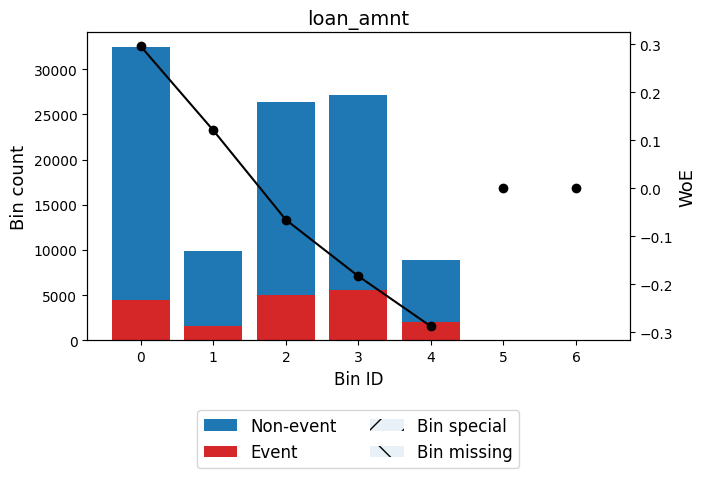


🔍 Feature: funded_amnt
✅ Total IV for funded_amnt: 0.0440
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 9012.50)      │   32478 │             0.1392 │ 0.29555611794296244  │ 0.0245585  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [9012.50, 10012.50)  │    9912 │             0.1616 │ 0.12008540640504739  │ 0.00131164 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [10012.50, 16037.50) │   26464 │             0.1883 │ -0.0652318656606301  │ 0.00109709 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [16037.50, 28012.50) │   27106 │             0.2072 │ -0.18437789106601365 │ 0.00931823 │
├────────────────────

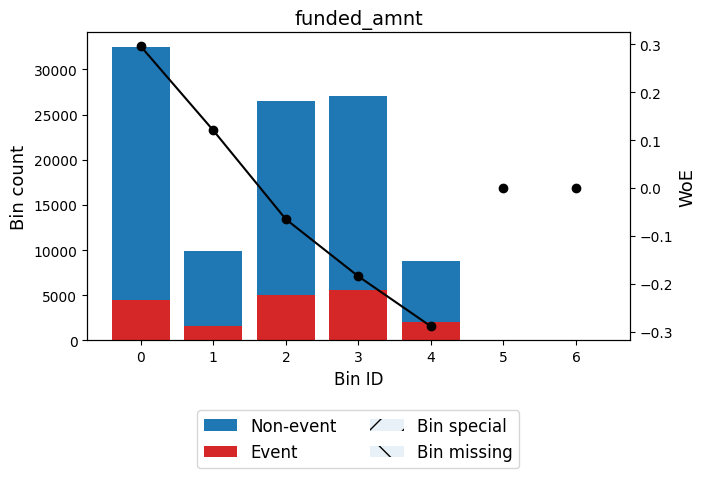


🔍 Feature: term
✅ Total IV for term: 0.2166
╒═══════════════╤═════════╤════════════════════╤═════════════════════╤═══════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                 │        IV │
╞═══════════════╪═════════╪════════════════════╪═════════════════════╪═══════════╡
│ (-inf, 48.00) │   79741 │             0.1378 │ 0.3073841596637701  │ 0.0649606 │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ [48.00, inf)  │   25063 │             0.3082 │ -0.7174954188198741 │ 0.151631  │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ Special       │       0 │             0      │ 0.0                 │ 0         │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ Missing       │       0 │             0      │ 0.0                 │ 0         │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│               │  104804 │             0.

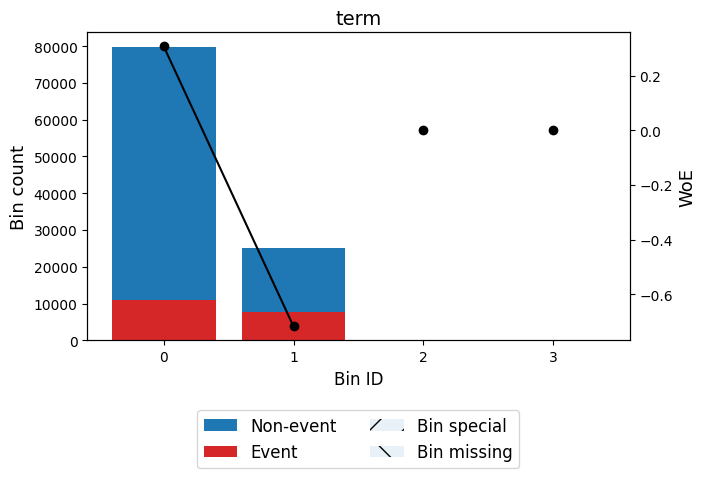


🔍 Feature: int_rate
✅ Total IV for int_rate: 0.4326
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 8.12)   │   16382 │             0.0508 │ 1.4005966108748313   │ 0.190623    │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [8.12, 11.47)  │   23054 │             0.1106 │ 0.5584052760752933   │ 0.0569058   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [11.47, 14.44) │   29390 │             0.1721 │ 0.04493867784232952  │ 0.000558164 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [14.44, 18.82) │   24231 │             0.2461 │ -0.40654416863435827 │ 0.0432733   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────

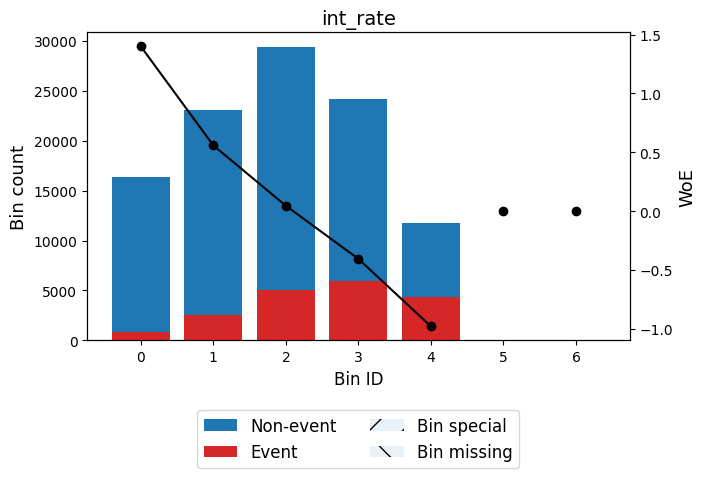


🔍 Feature: installment
✅ Total IV for installment: 0.0320
╒══════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 193.38)   │   16132 │             0.131  │ 0.3656389768139452   │ 0.018233    │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [193.38, 251.58) │    9826 │             0.1502 │ 0.20680445886834153  │ 0.00374731  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [251.58, 337.48) │   18833 │             0.1732 │ 0.03731917912488525  │ 0.000247273 │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [337.48, 877.63) │   52881 │             0.1962 │ -0.11575526149515092 │ 0.00701403  │
├──────────────────┼─────────┼────────────────────┼

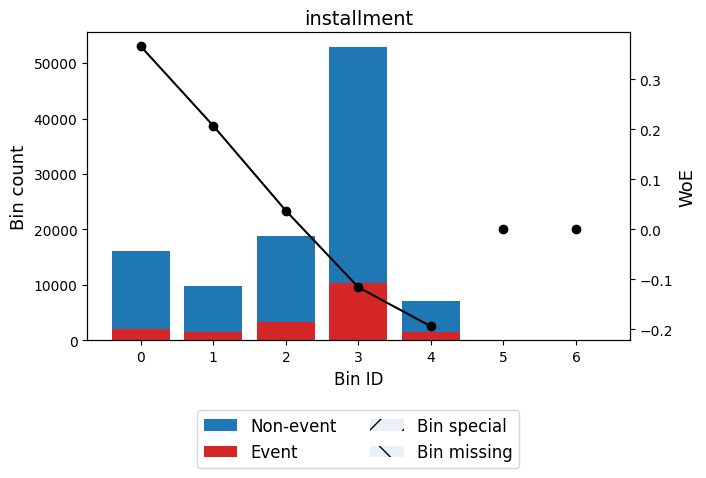


🔍 Feature: emp_length
✅ Total IV for emp_length: 0.0014
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 1.50) │   14983 │             0.1821 │ -0.023756076817281757 │ 8.12978e-05 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 3.50) │   17856 │             0.1717 │ 0.04784996448491641   │ 0.000384113 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [3.50, 4.50) │    6213 │             0.163  │ 0.10962104650469318   │ 0.000687467 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [4.50, 5.50) │    6524 │             0.1763 │ 0.015689214001998852  │ 1.52456e-05 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼────────────

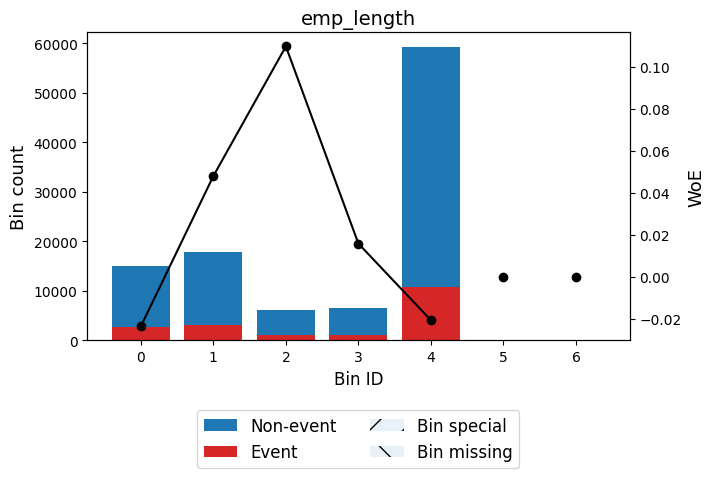


🔍 Feature: annual_inc
✅ Total IV for annual_inc: 0.0254
╒═══════════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin                   │   Count │   Default Rate (%) │ WOE                  │         IV │
╞═══════════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 45752.50)      │   26224 │             0.2046 │ -0.16846653812055346 │ 0.00748933 │
├───────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [45752.50, 75642.10)  │   40181 │             0.1869 │ -0.05586898532613804 │ 0.00121826 │
├───────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [75642.10, 96006.00)  │   16185 │             0.1648 │ 0.0964976706321714   │ 0.00139372 │
├───────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [96006.00, 125887.00) │   12394 │             0.152  │ 0.19280865491854637  │ 0.0041277  │
├────────────

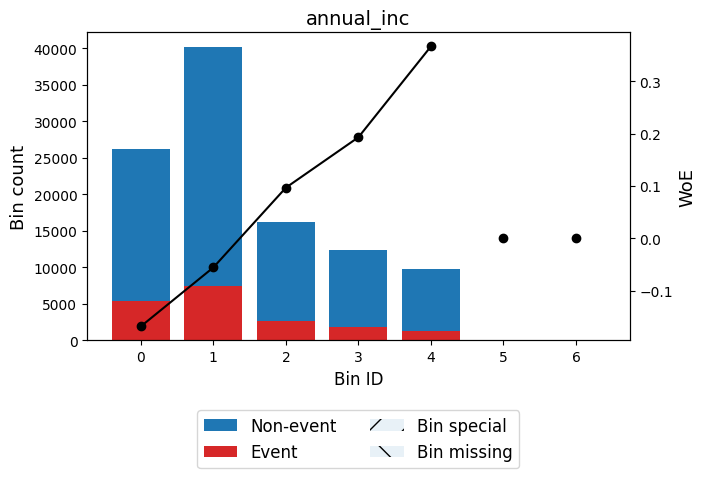


🔍 Feature: dti
✅ Total IV for dti: 0.0927
╒════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │         IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 12.78)  │   29974 │             0.1266 │ 0.4054535351527895   │ 0.0410986  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [12.78, 18.57) │   26632 │             0.1634 │ 0.10720723980058411  │ 0.00282071 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [18.57, 26.05) │   28396 │             0.1955 │ -0.11159107621802877 │ 0.00349571 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [26.05, 32.85) │   14516 │             0.2413 │ -0.38028839683951254 │ 0.0225118  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [32.85, i

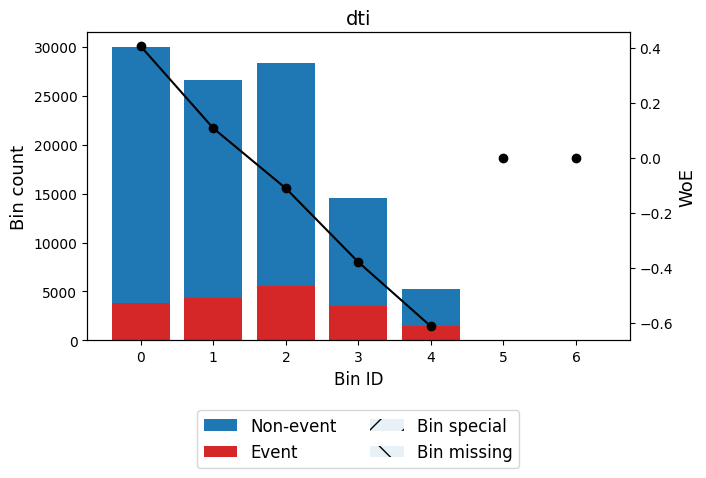


🔍 Feature: delinq_2yrs
✅ Total IV for delinq_2yrs: 0.0024
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   84449 │             0.1751 │ 0.023621249937080924 │ 0.000446187 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, 1.50) │   13415 │             0.1895 │ -0.07278987456779196 │ 0.00069413  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, inf)  │    6940 │             0.1993 │ -0.13531801220097894 │ 0.00126565  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Miss

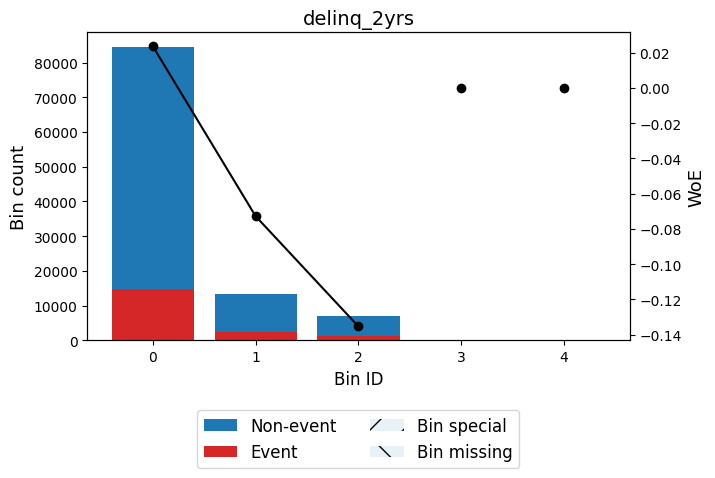


🔍 Feature: inq_last_6mths
✅ Total IV for inq_last_6mths: 0.0293
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.50) │   59397 │             0.1589 │ 0.1402112562715041   │ 0.0106445  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.50, 1.50) │   28829 │             0.1909 │ -0.08184613362490567 │ 0.00189138 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1.50, 2.50) │   10780 │             0.2191 │ -0.2552578012429336  │ 0.00725807 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [2.50, inf)  │    5798 │             0.2432 │ -0.3908375157932351  │ 0.00952657 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Special  

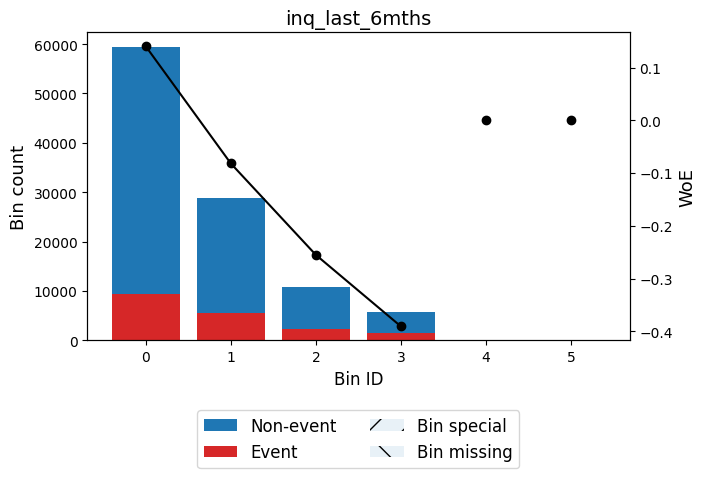


🔍 Feature: open_acc
✅ Total IV for open_acc: 0.0162
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 5.50)   │    8822 │             0.1429 │ 0.2649770457772085   │ 0.00541719  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5.50, 7.50)   │   14626 │             0.1596 │ 0.13524375658773202  │ 0.00244268  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [7.50, 11.50)  │   35739 │             0.1726 │ 0.04090632350026069  │ 0.000563135 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [11.50, 17.50) │   32144 │             0.1898 │ -0.07502732080408325 │ 0.00176829  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────

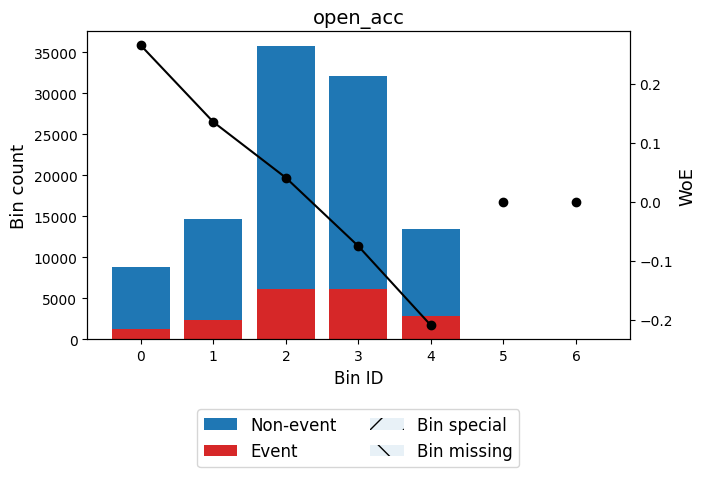


🔍 Feature: pub_rec
✅ Total IV for pub_rec: 0.0059
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.50) │   87730 │             0.1735 │ 0.034913284973516534 │ 0.00100893 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.50, inf)  │   17074 │             0.2046 │ -0.16821056251890565 │ 0.00486098 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0          │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0          │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│              │  104804 

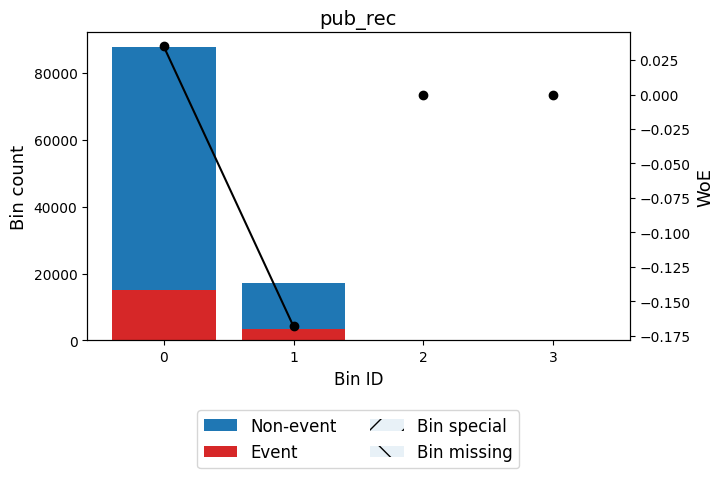


🔍 Feature: revol_bal
✅ Total IV for revol_bal: 0.0038
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 2782.50)      │    8339 │             0.1626 │ 0.11281808052955244  │ 0.00097629  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2782.50, 12141.50)  │   46900 │             0.1783 │ 0.001825780753195172 │ 1.49086e-06 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [12141.50, 22934.50) │   28035 │             0.19   │ -0.07596051952535054 │ 0.00158132  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [22934.50, 35588.00) │   12781 │             0.1768 │ 0.011887092725814119 │ 1.71663e-05 │
├──────────────

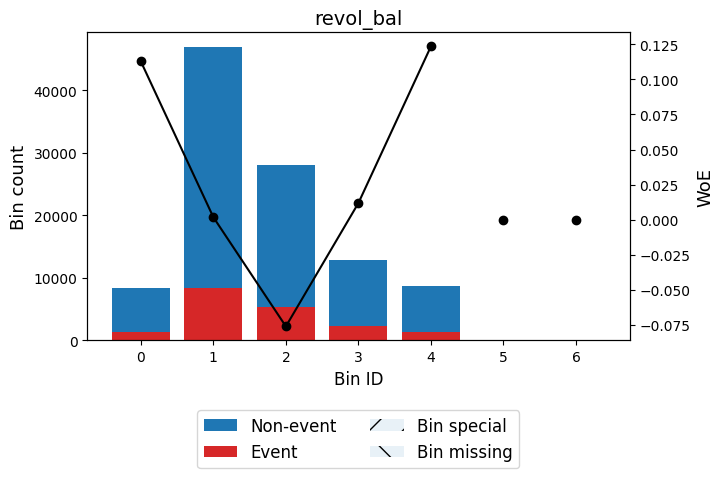


🔍 Feature: revol_util
✅ Total IV for revol_util: 0.0209
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 17.85)  │    8679 │             0.131  │ 0.3659728302516243   │ 0.00982613  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [17.85, 33.95) │   15533 │             0.1546 │ 0.17304532858408805  │ 0.00419434  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [33.95, 48.45) │   20112 │             0.1726 │ 0.04095728477881666  │ 0.000317687 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [48.45, 62.65) │   21576 │             0.1859 │ -0.04925365488626743 │ 0.000507355 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─

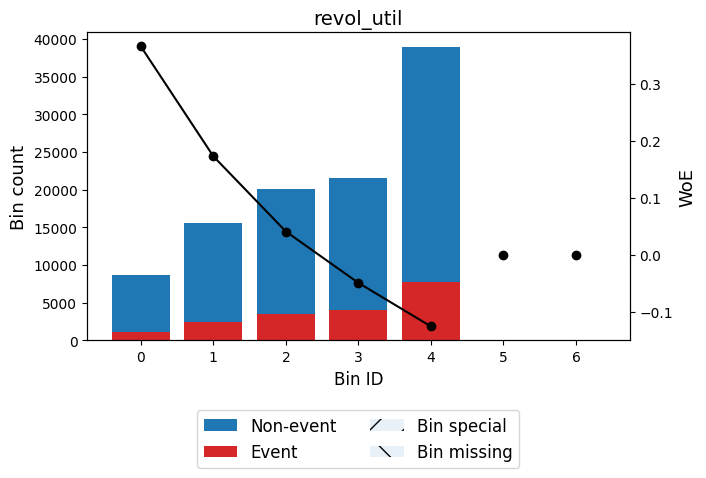


🔍 Feature: total_acc
✅ Total IV for total_acc: 0.0035
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 11.50)  │   10331 │             0.1633 │ 0.10779228126466633   │ 0.00110596  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [11.50, 14.50) │    8685 │             0.1687 │ 0.0688783566195621    │ 0.000384485 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [14.50, 21.50) │   25336 │             0.1748 │ 0.02606249218814294   │ 0.000162834 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [21.50, 40.50) │   49195 │             0.1811 │ -0.017453454660826706 │ 0.000143793 │
├────────────────┼─────────┼────────────────────┼────────────────

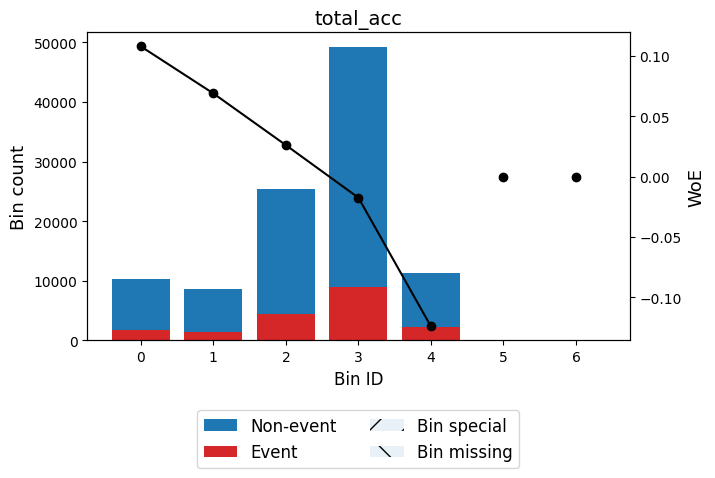


🔍 Feature: collections_12_mths_ex_med
✅ Total IV for collections_12_mths_ex_med: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  104804 │             0.1786 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  104804 │             0.1786 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛


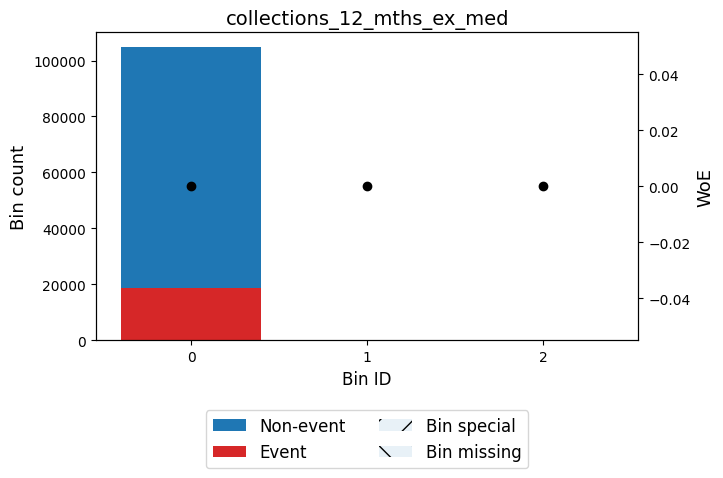


🔍 Feature: acc_now_delinq
✅ Total IV for acc_now_delinq: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  104804 │             0.1786 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  104804 │             0.1786 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛


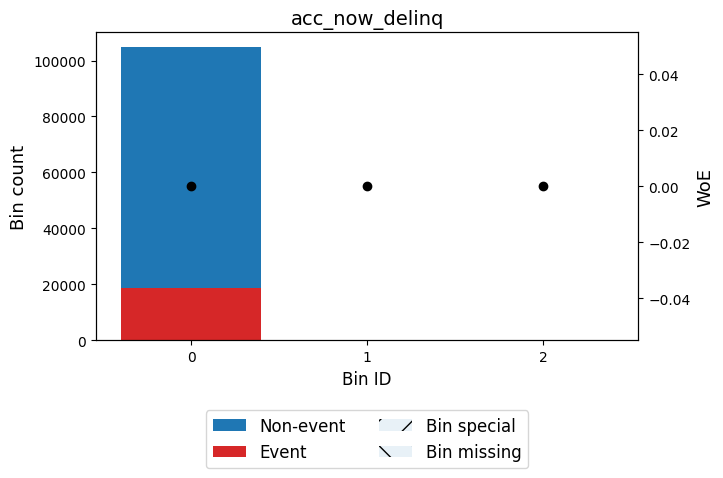


🔍 Feature: tot_cur_bal
✅ Total IV for tot_cur_bal: 0.0278
╒═══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                   │   Count │   Default Rate (%) │ WOE                  │          IV │
╞═══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 14981.50)      │   10231 │             0.1639 │ 0.10327117314750311  │ 0.0010068   │
├───────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [14981.50, 40964.50)  │   23042 │             0.1977 │ -0.12527910215775506 │ 0.00359053  │
├───────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [40964.50, 76420.50)  │   14718 │             0.2192 │ -0.2557131924021159  │ 0.00994625  │
├───────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [76420.50, 210670.50) │   32477 │             0.1764 │ 0.015009305991190658 │ 6.94738e-05 │
├

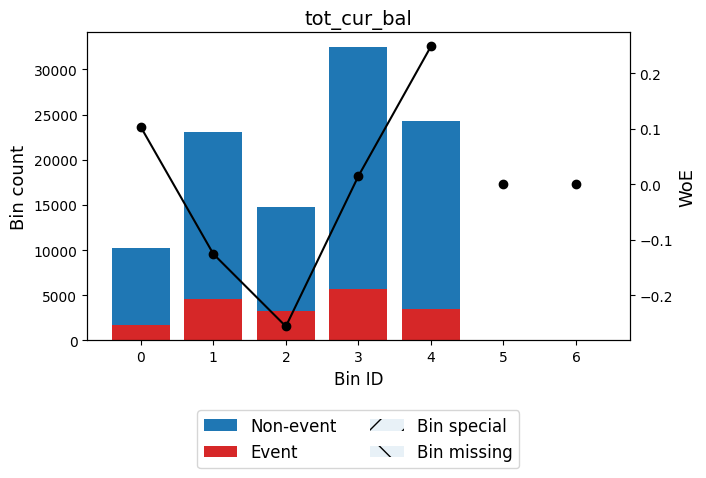


🔍 Feature: total_rev_hi_lim
✅ Total IV for total_rev_hi_lim: 0.0148
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 9025.00)      │   11098 │             0.1957 │ -0.1128013896807527  │ 0.00139655  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [9025.00, 23939.00)  │   37975 │             0.1905 │ -0.07948697578913944 │ 0.00234811  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [23939.00, 50953.50) │   39892 │             0.1766 │ 0.013248538180181235 │ 6.65261e-05 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [50953.50, 82068.00) │   10565 │             0.1506 │ 0.203847404382       │ 0.0039186   │
├

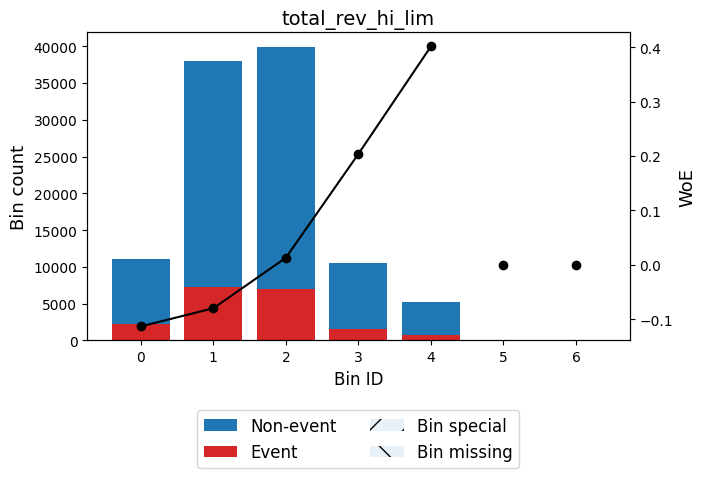


🔍 Feature: acc_open_past_24mths
✅ Total IV for acc_open_past_24mths: 0.0852
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 2.50) │   26768 │             0.1293 │ 0.38107482616704424  │ 0.0326911  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [2.50, 4.50) │   33553 │             0.1615 │ 0.12116625540619697  │ 0.00451869 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [4.50, 6.50) │   21897 │             0.1946 │ -0.10597432380455207 │ 0.00242683 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [6.50, 9.50) │   15685 │             0.23   │ -0.317972138723281   │ 0.0166978  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤

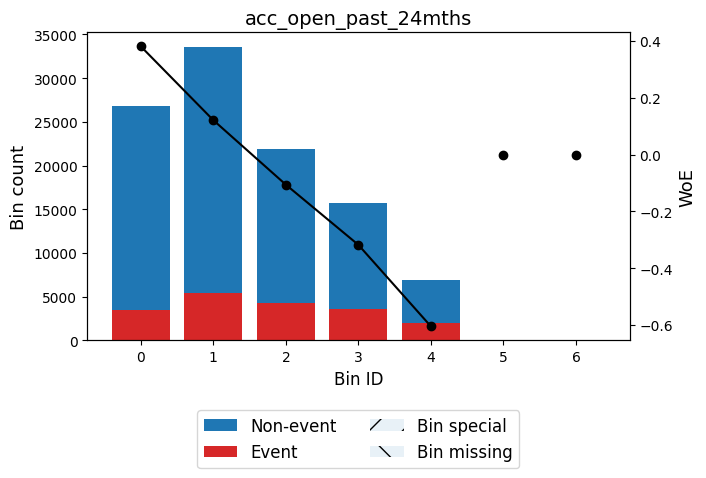


🔍 Feature: avg_cur_bal
✅ Total IV for avg_cur_bal: 0.0347
╒══════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 7248.50)      │   48575 │             0.2006 │ -0.14329738859067453  │ 0.00995894  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [7248.50, 13811.50)  │   22803 │             0.1807 │ -0.014360497699876573 │ 4.5077e-05  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [13811.50, 20170.00) │   11389 │             0.1654 │ 0.092299445970079     │ 0.000898482 │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [20170.00, 41154.50) │   16787 │             0.1423 │ 0.27009308588729675   │ 0.0106917   │
├

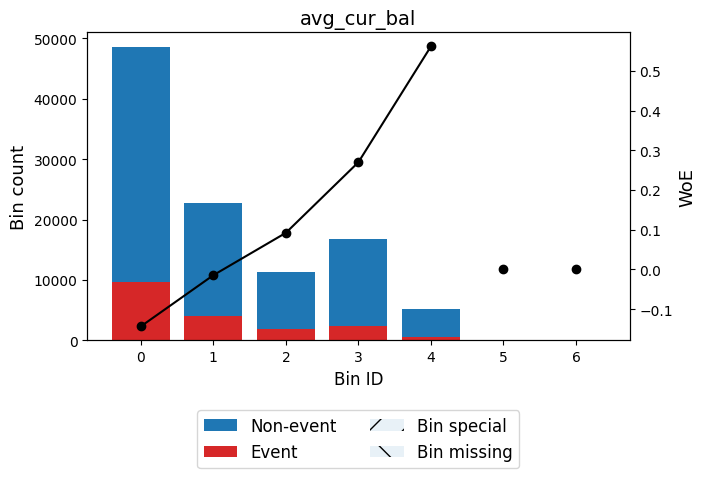


🔍 Feature: bc_open_to_buy
✅ Total IV for bc_open_to_buy: 0.0454
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 205.50)       │    6865 │             0.235  │ -0.3456081965186639  │ 0.00870457 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [205.50, 4606.50)    │   44276 │             0.1995 │ -0.13654885716582554 │ 0.00822536 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [4606.50, 14251.50)  │   33576 │             0.1679 │ 0.07476340597623987  │ 0.00174791 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [14251.50, 26808.00) │   11357 │             0.1463 │ 0.2381722448796586   │ 0.00568499 │
├──────────────

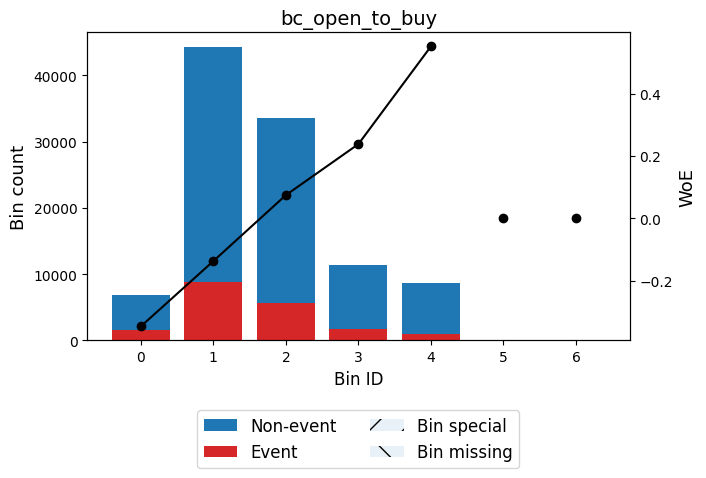


🔍 Feature: bc_util
✅ Total IV for bc_util: 0.0271
╒════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │         IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 37.15)  │   21015 │             0.1462 │ 0.23836869617260215  │ 0.0105362  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [37.15, 63.35) │   31788 │             0.1667 │ 0.08331655861795828  │ 0.00204939 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [63.35, 92.15) │   36159 │             0.19   │ -0.07625313404714573 │ 0.00205549 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [92.15, 97.85) │   10420 │             0.2063 │ -0.17895468692011351 │ 0.00336882 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [

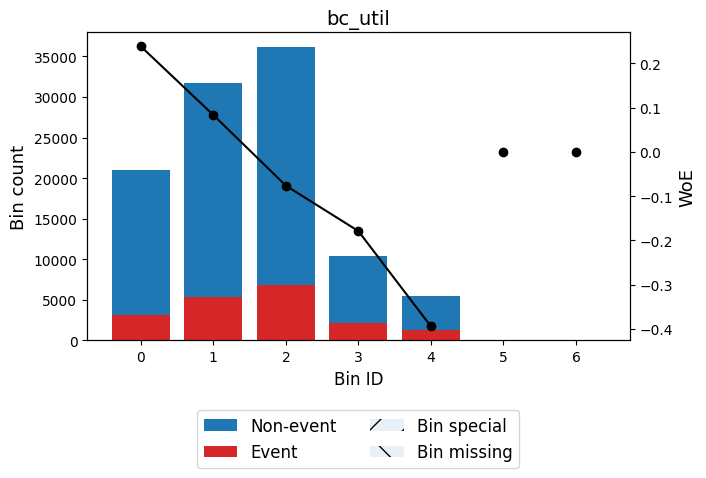


🔍 Feature: chargeoff_within_12_mths
✅ Total IV for chargeoff_within_12_mths: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  104804 │             0.1786 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  104804 │             0.1786 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛


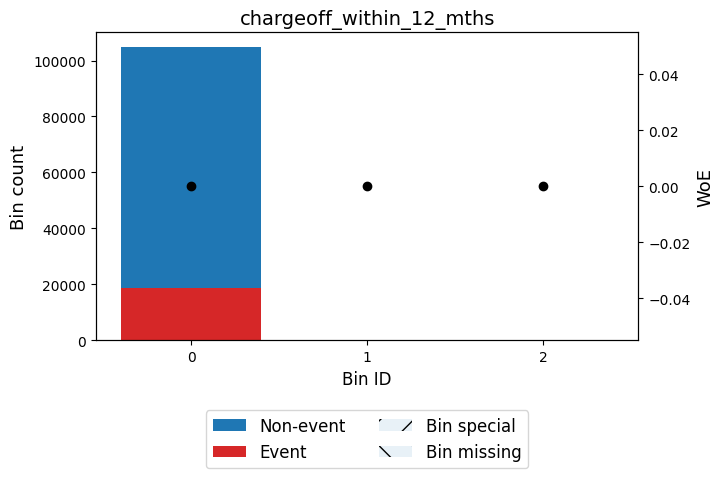


🔍 Feature: delinq_amnt
✅ Total IV for delinq_amnt: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  104804 │             0.1786 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  104804 │             0.1786 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛


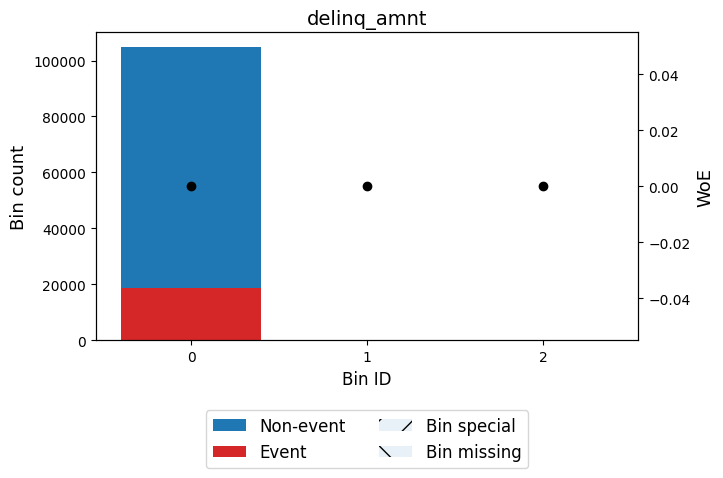


🔍 Feature: mo_sin_old_il_acct
✅ Total IV for mo_sin_old_il_acct: 0.0064
╒══════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 47.50)    │    7491 │             0.2037 │ -0.1628622311285277   │ 0.00199592  │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [47.50, 127.50)  │   38153 │             0.1863 │ -0.05173159205664857  │ 0.000990482 │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [127.50, 129.50) │   11698 │             0.1557 │ 0.1647016673643773    │ 0.00286942  │
├──────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [129.50, 198.50) │   40896 │             0.1732 │ 0.036684966371827166  │ 0.000518967 │
├──────────────────┼───────

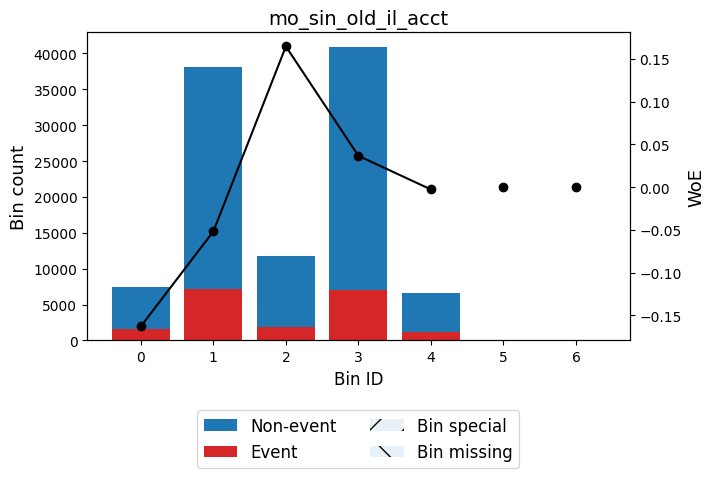


🔍 Feature: mo_sin_old_rev_tl_op
✅ Total IV for mo_sin_old_rev_tl_op: 0.0170
╒══════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 63.50)    │    6032 │             0.2291 │ -0.3127858595623554  │ 0.00620417  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [63.50, 133.50)  │   26402 │             0.1951 │ -0.10890827131286662 │ 0.00309323  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [133.50, 159.50) │   13301 │             0.1859 │ -0.04892117276534402 │ 0.000308529 │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [159.50, 164.50) │    8987 │             0.1457 │ 0.24297425583470122  │ 0.00467436  │
├──────────────────┼─────────┼───

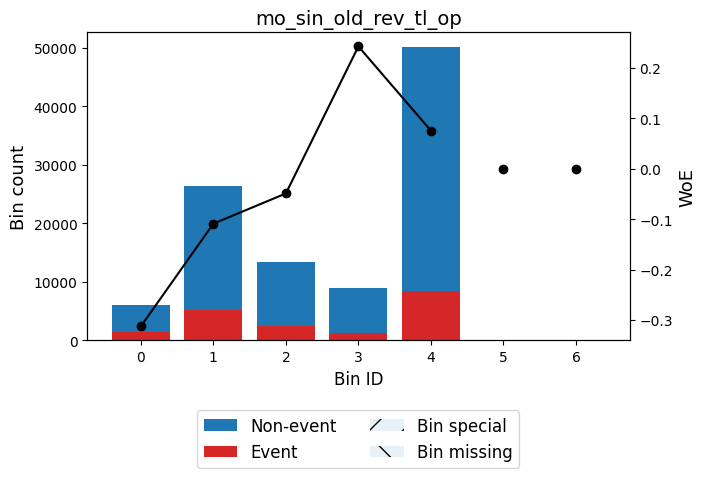


🔍 Feature: mo_sin_rcnt_rev_tl_op
✅ Total IV for mo_sin_rcnt_rev_tl_op: 0.0305
╒════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │         IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 3.50)   │   23737 │             0.2114 │ -0.20936102826881187 │ 0.0106023  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [3.50, 7.50)   │   23749 │             0.1898 │ -0.07493153105479244 │ 0.0013031  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [7.50, 21.50)  │   41073 │             0.1704 │ 0.056645994599805904 │ 0.00123471 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [21.50, 35.50) │    9070 │             0.1471 │ 0.2315814568414194   │ 0.00430184 │
├────────────────┼─────────┼────────────────────┼────────────

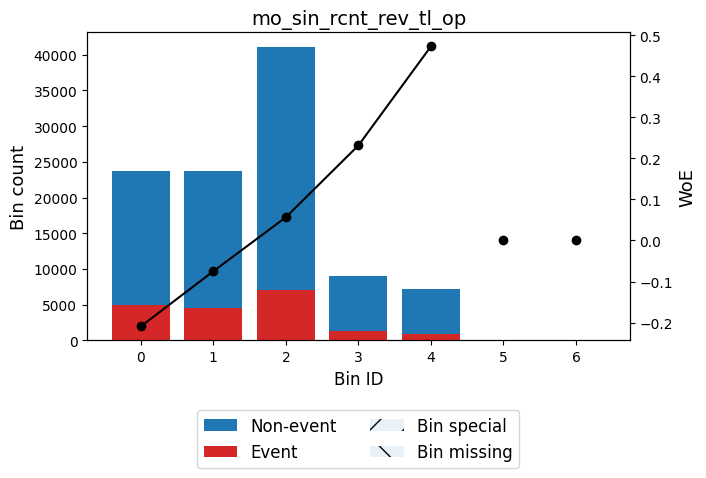


🔍 Feature: mo_sin_rcnt_tl
✅ Total IV for mo_sin_rcnt_tl: 0.0377
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 3.50)   │   31665 │             0.2128 │ -0.2179329454495491  │ 0.0153655   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 4.50)   │    9466 │             0.1918 │ -0.08805198615679921 │ 0.000720191 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [4.50, 11.50)  │   44346 │             0.1703 │ 0.05724142054250536  │ 0.00136101  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [11.50, 20.50) │   13261 │             0.1434 │ 0.26159699597057107  │ 0.00794555  │
├────────────────┼─────────┼────────────────────┼────────────────

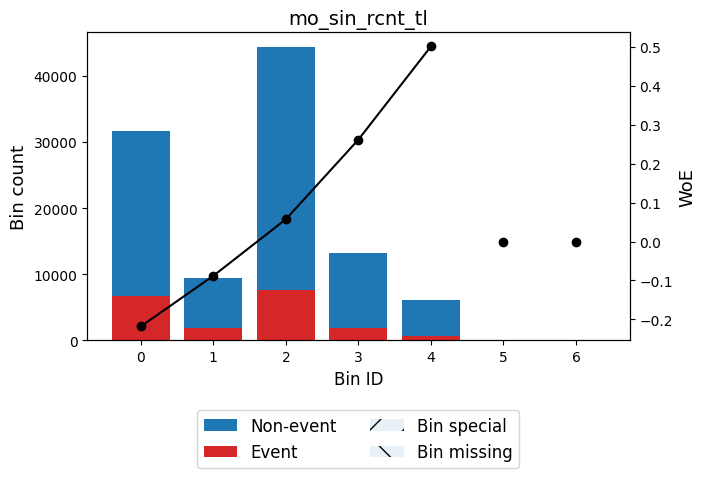


🔍 Feature: mort_acc
✅ Total IV for mort_acc: 0.0214
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   39685 │             0.203  │ -0.15830833312752235 │ 0.00997663  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, 2.50) │   36235 │             0.173  │ 0.03871102064305232  │ 0.000511676 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 3.50) │   10892 │             0.1638 │ 0.10417376022753344  │ 0.00109034  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 5.50) │   12304 │             0.1465 │ 0.23589719268653409  │ 0.00604652  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5.50, inf

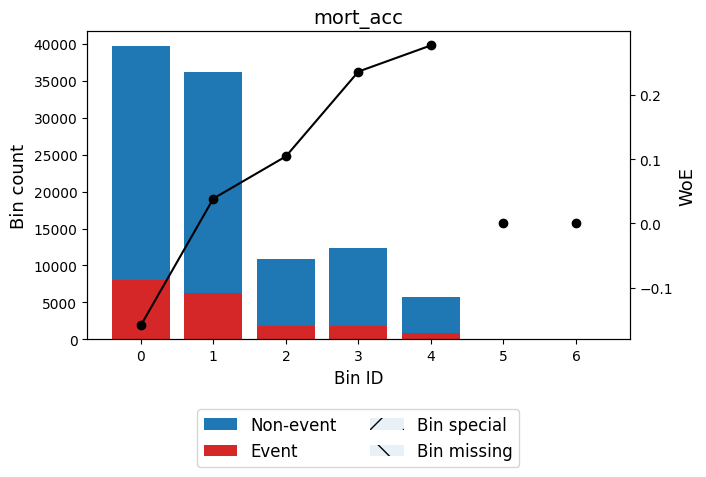


🔍 Feature: mths_since_recent_bc
✅ Total IV for mths_since_recent_bc: 0.0277
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 3.50)   │   13533 │             0.2161 │ -0.2373711982265394  │ 0.00783685  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 12.50)  │   33181 │             0.1945 │ -0.10533950375587864 │ 0.00363278  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [12.50, 28.50) │   32889 │             0.1723 │ 0.043244238906257504 │ 0.000578718 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [28.50, 56.50) │   14265 │             0.1568 │ 0.15598022880214812  │ 0.00314738  │
├────────────────┼─────────┼────────────────────┼────

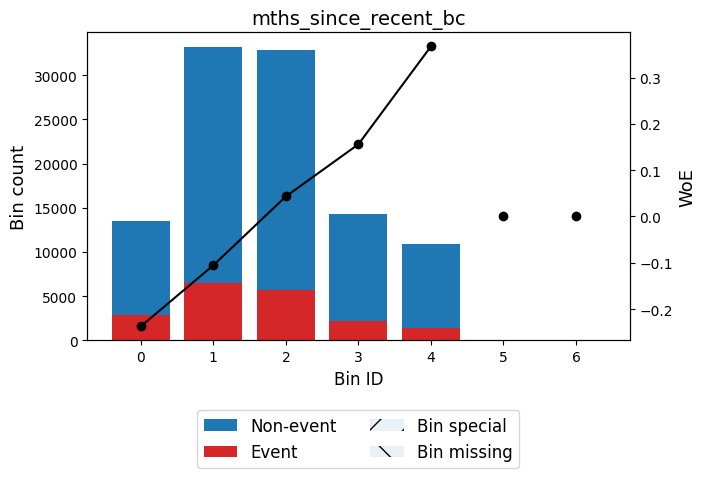


🔍 Feature: mths_since_recent_inq
✅ Total IV for mths_since_recent_inq: 0.0268
╒═══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                  │         IV │
╞═══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 1.50)  │   18634 │             0.2156 │ -0.2347888011331789  │ 0.010549   │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1.50, 3.50)  │   15400 │             0.2044 │ -0.16680016693110233 │ 0.0043093  │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [3.50, 4.50)  │    6788 │             0.1924 │ -0.09162038678978734 │ 0.00055978 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [4.50, 14.50) │   52731 │             0.163  │ 0.11025181727874012  │ 0.00590079 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼

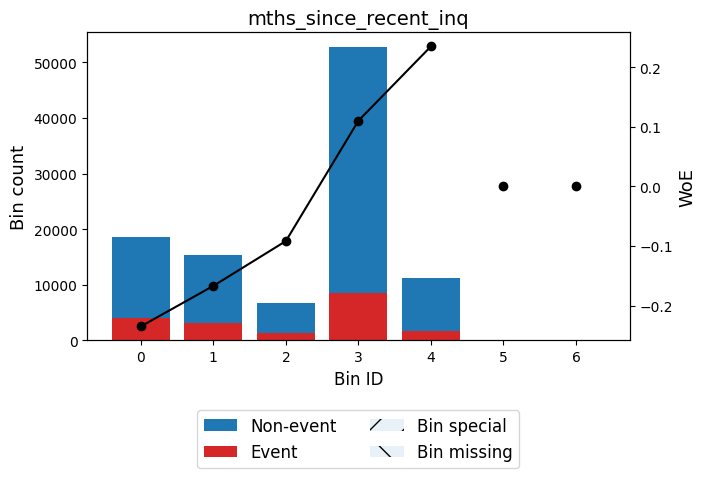


🔍 Feature: num_accts_ever_120_pd
✅ Total IV for num_accts_ever_120_pd: 0.0035
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   81603 │             0.1739 │ 0.03209372894523099  │ 0.000793733 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, inf)  │   23201 │             0.1949 │ -0.10795048362432214 │ 0.0026698   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─

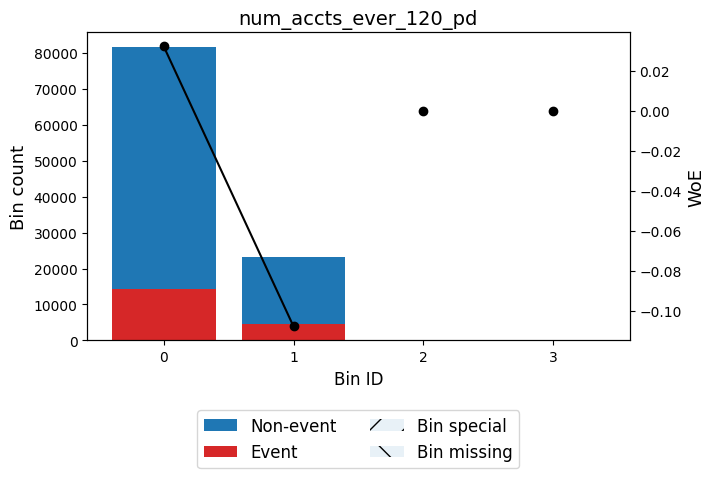


🔍 Feature: num_actv_bc_tl
✅ Total IV for num_actv_bc_tl: 0.0125
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 3.50) │   60145 │             0.1665 │ 0.08429451476771144  │ 0.00396789  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 4.50) │   16625 │             0.1833 │ -0.0318280179402588  │ 0.000162342 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [4.50, 5.50) │   11305 │             0.1884 │ -0.0657609395968417  │ 0.000476373 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5.50, 6.50) │    6971 │             0.1967 │ -0.11889515665521566 │ 0.000976421 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤


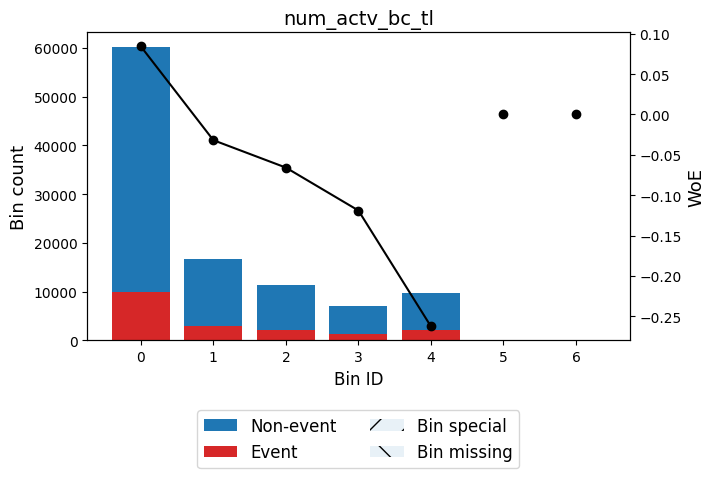


🔍 Feature: num_actv_rev_tl
✅ Total IV for num_actv_rev_tl: 0.0345
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 3.50) │   25082 │             0.1499 │ 0.2088862692085265    │ 0.00975225  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [3.50, 5.50) │   36000 │             0.1664 │ 0.08511763975322362   │ 0.00242095  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [5.50, 7.50) │   20923 │             0.1855 │ -0.046849633437704874 │ 0.000444803 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [7.50, 9.50) │   11552 │             0.2014 │ -0.1487840482097058   │ 0.00255761  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼──

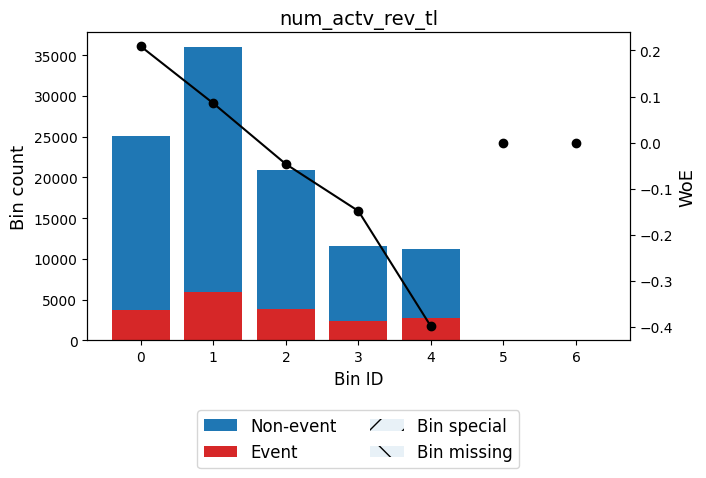


🔍 Feature: num_bc_sats
✅ Total IV for num_bc_sats: 0.0047
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 1.50) │    7011 │             0.1823 │ -0.02517875584523943 │ 4.2754e-05  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [1.50, 3.50) │   31180 │             0.1735 │ 0.034840577989741384 │ 0.000357099 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 4.50) │   22204 │             0.1646 │ 0.09852597728148704  │ 0.00199193  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [4.50, 7.50) │   30628 │             0.1854 │ -0.04606277347746168 │ 0.000629276 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [7.5

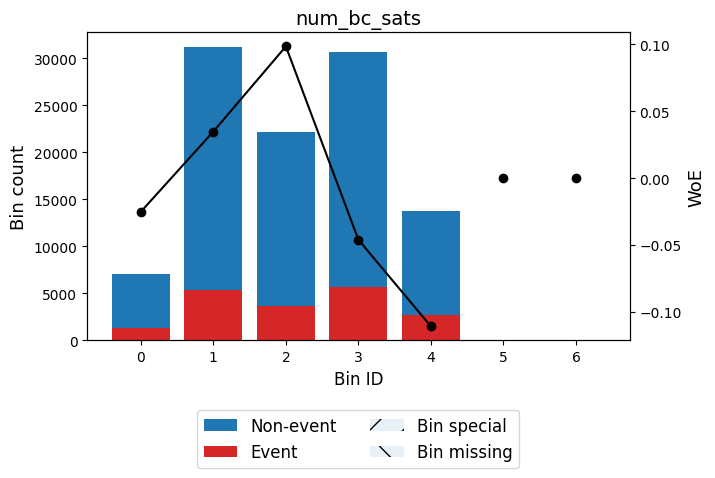


🔍 Feature: num_bc_tl
✅ Total IV for num_bc_tl: 0.0032
╒═══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                   │          IV │
╞═══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 2.50)  │    5919 │             0.1921 │ -0.08965569954840813  │ 0.000467118 │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 6.50)  │   34946 │             0.1817 │ -0.021309318816136846 │ 0.00015245  │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [6.50, 7.50)  │   15787 │             0.1615 │ 0.12126900248661054   │ 0.00212962  │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [7.50, 12.50) │   31709 │             0.177  │ 0.011008372455078241  │ 3.65353e-05 │
├───────────────┼─────────┼────────────────────┼───────────────────────┼───

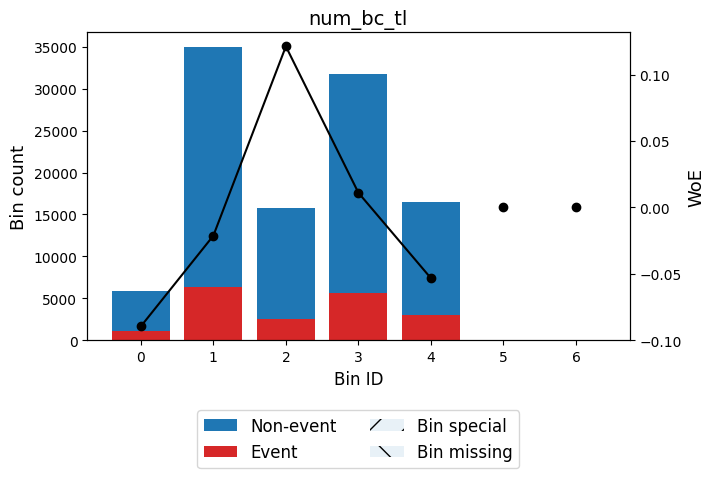


🔍 Feature: num_il_tl
✅ Total IV for num_il_tl: 0.0068
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 6.50)   │   48311 │             0.1732 │ 0.03720628109785662   │ 0.000630504 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [6.50, 7.50)   │   13238 │             0.1592 │ 0.13834751987289495   │ 0.00231115  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [7.50, 11.50)  │   19095 │             0.184  │ -0.036475325191165586 │ 0.000245252 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [11.50, 17.50) │   13824 │             0.1887 │ -0.06783619199856172  │ 0.000620273 │
├────────────────┼─────────┼────────────────────┼────────────────

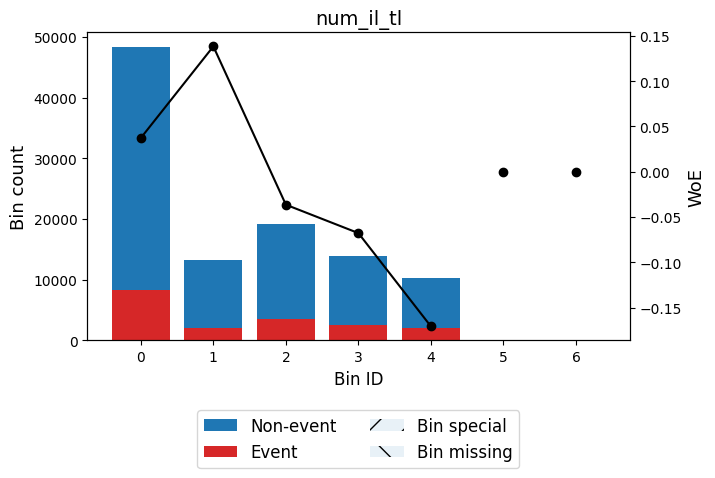


🔍 Feature: num_op_rev_tl
✅ Total IV for num_op_rev_tl: 0.0179
╒═══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                   │          IV │
╞═══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 4.50)  │   17705 │             0.158  │ 0.14680467122886176   │ 0.0034708   │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [4.50, 7.50)  │   38284 │             0.1655 │ 0.09174057272687586   │ 0.00298432  │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [7.50, 9.50)  │   17320 │             0.1796 │ -0.006798137898275325 │ 7.65417e-06 │
├───────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [9.50, 12.50) │   16527 │             0.1934 │ -0.09831708970322905  │ 0.00157275  │
├───────────────┼─────────┼────────────────────┼───────────────────

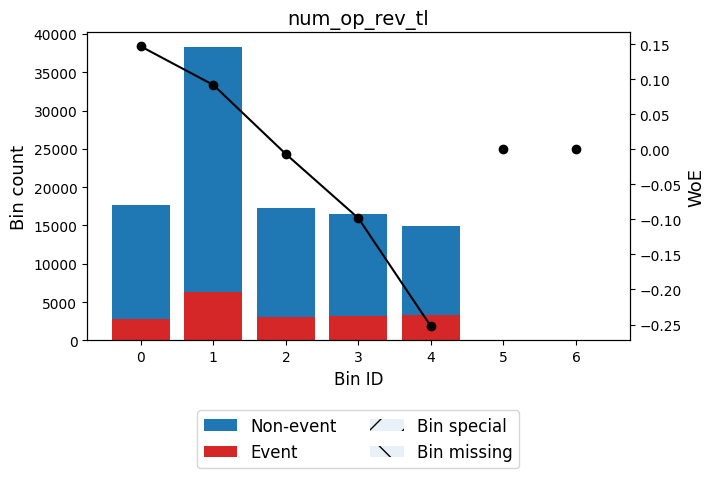


🔍 Feature: num_rev_accts
✅ Total IV for num_rev_accts: 0.0050
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 12.50)  │   43922 │             0.1739 │ 0.032278223007711215  │ 0.000432119 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [12.50, 13.50) │   11950 │             0.16   │ 0.13210672278739044   │ 0.00190622  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [13.50, 18.50) │   22335 │             0.182  │ -0.02327472642600048  │ 0.00011631  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [18.50, 24.50) │   15105 │             0.1853 │ -0.045296616031159864 │ 0.000300033 │
├────────────────┼─────────┼────────────────────┼────────

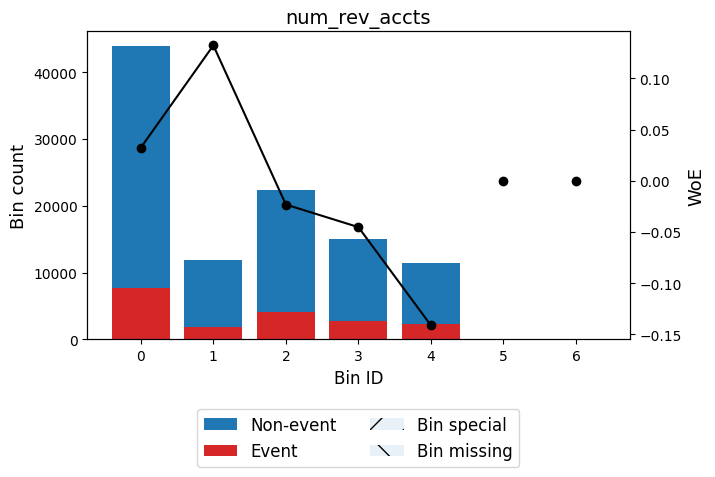


🔍 Feature: num_rev_tl_bal_gt_0
✅ Total IV for num_rev_tl_bal_gt_0: 0.0345
╒═══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                  │         IV │
╞═══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 2.50)  │   11656 │             0.1432 │ 0.2629382487651575   │ 0.00705251 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [2.50, 5.50)  │   49657 │             0.1638 │ 0.10436740591711624  │ 0.00498908 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [5.50, 8.50)  │   27838 │             0.189  │ -0.06927639972640542 │ 0.00130327 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [8.50, 10.50) │    8111 │             0.2127 │ -0.21724031000687472 │ 0.00391006 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────

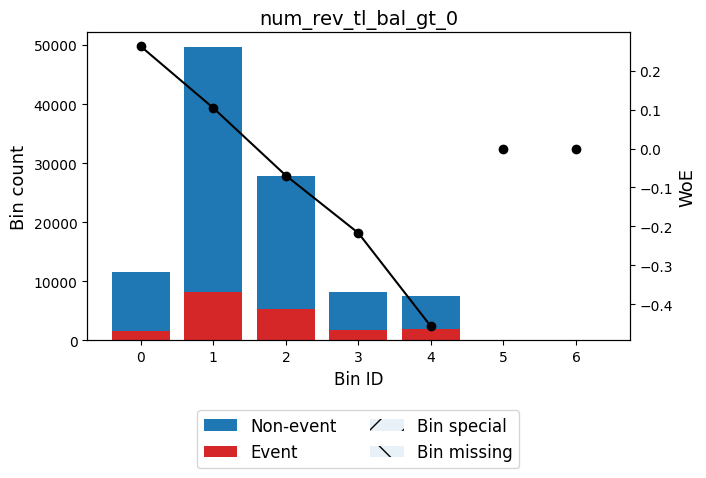


🔍 Feature: num_sats
✅ Total IV for num_sats: 0.0165
╒════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │         IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 5.50)   │    8039 │             0.1443 │ 0.25393193360946187  │ 0.00455022 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [5.50, 11.50)  │   53108 │             0.1675 │ 0.07727315412434033  │ 0.00295103 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [11.50, 17.50) │   30631 │             0.1924 │ -0.09175613963562901 │ 0.00253362 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [17.50, 21.50) │    7698 │             0.2049 │ -0.1699201799281107  │ 0.00223759 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│

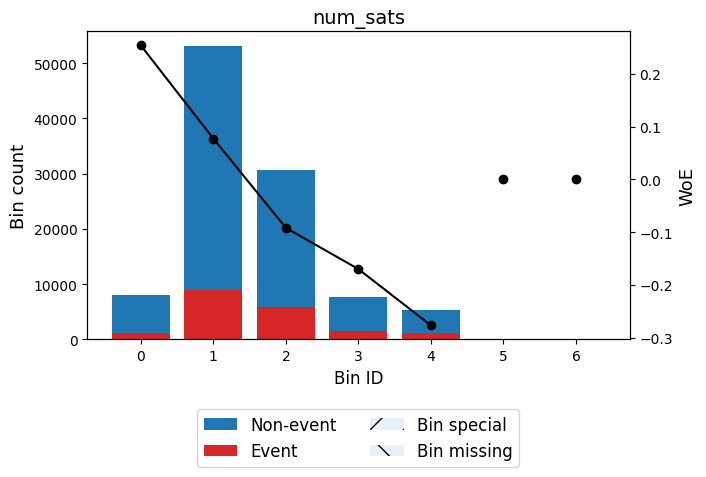


🔍 Feature: num_tl_120dpd_2m
✅ Total IV for num_tl_120dpd_2m: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  104804 │             0.1786 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  104804 │             0.1786 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛


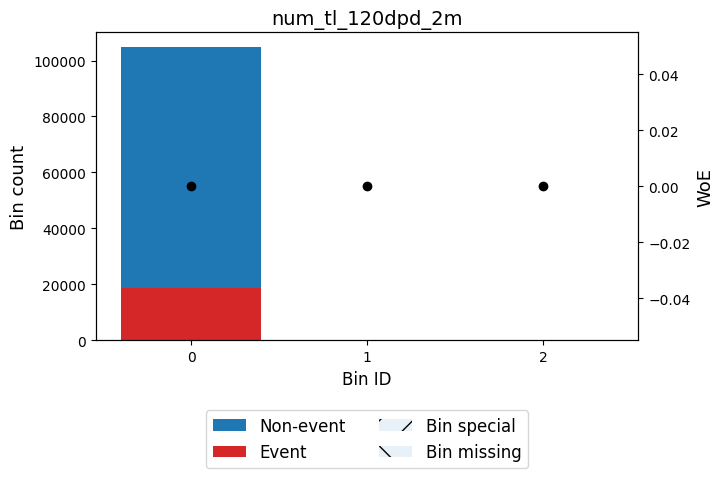


🔍 Feature: num_tl_30dpd
✅ Total IV for num_tl_30dpd: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  104804 │             0.1786 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  104804 │             0.1786 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛


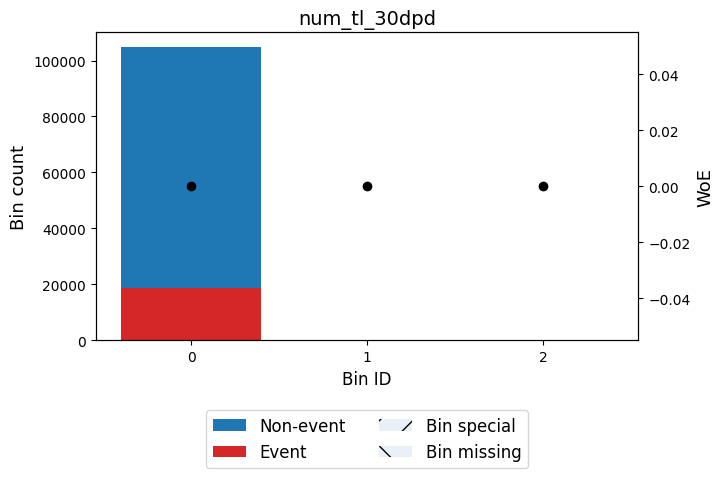


🔍 Feature: num_tl_90g_dpd_24m
✅ Total IV for num_tl_90g_dpd_24m: 0.0008
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   99030 │             0.1776 │ 0.006829472481352683 │ 4.39753e-05 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, inf)  │    5774 │             0.1957 │ -0.1127629227047462  │ 0.000726087 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼───────

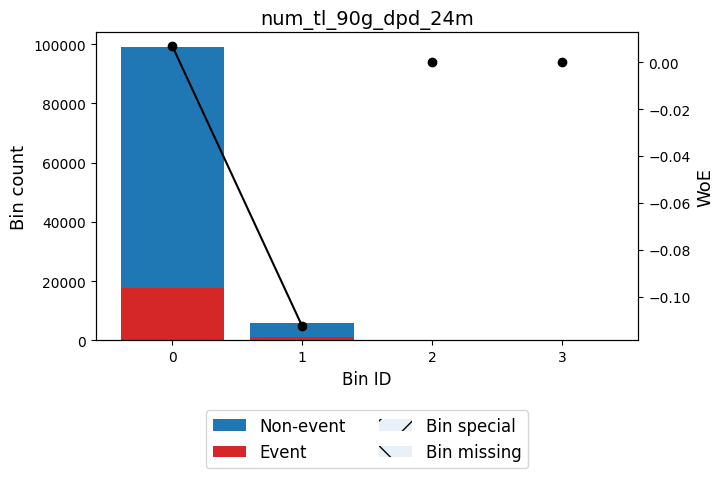


🔍 Feature: num_tl_op_past_12m
✅ Total IV for num_tl_op_past_12m: 0.0648
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.50) │   16652 │             0.1316 │ 0.36097595620318357  │ 0.0183727  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.50, 1.50) │   24475 │             0.1527 │ 0.1872474814661902   │ 0.00770192 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1.50, 2.50) │   29117 │             0.169  │ 0.06630969446027568  │ 0.00119566 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [2.50, 4.50) │   25651 │             0.2164 │ -0.23937963045913624 │ 0.0151159  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [

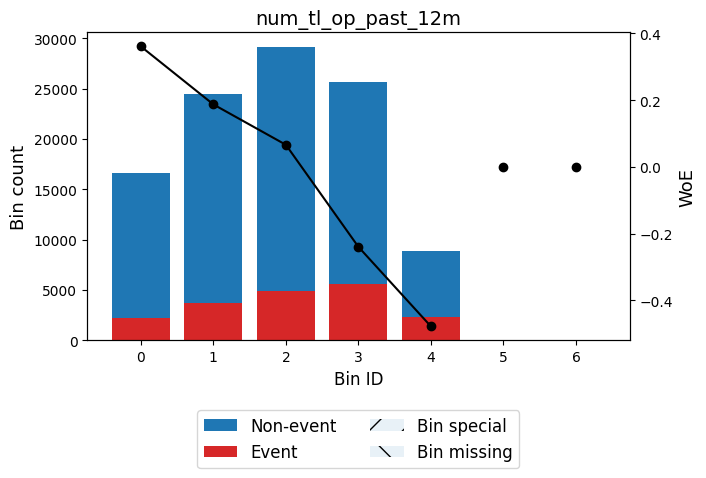


🔍 Feature: pct_tl_nvr_dlq
✅ Total IV for pct_tl_nvr_dlq: 0.0065
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 96.25)  │   42767 │             0.1878 │ -0.06196037668289489 │ 0.00159792  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [96.25, 97.75) │    6146 │             0.1856 │ -0.04758901192889664 │ 0.000134846 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [97.75, 97.85) │    6780 │             0.142  │ 0.272365178296494    │ 0.00438781  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [97.85, inf)   │   49111 │             0.1746 │ 0.02693557227269494  │ 0.000337041 │
├────────────────┼─────────┼────────────────────┼────────────────

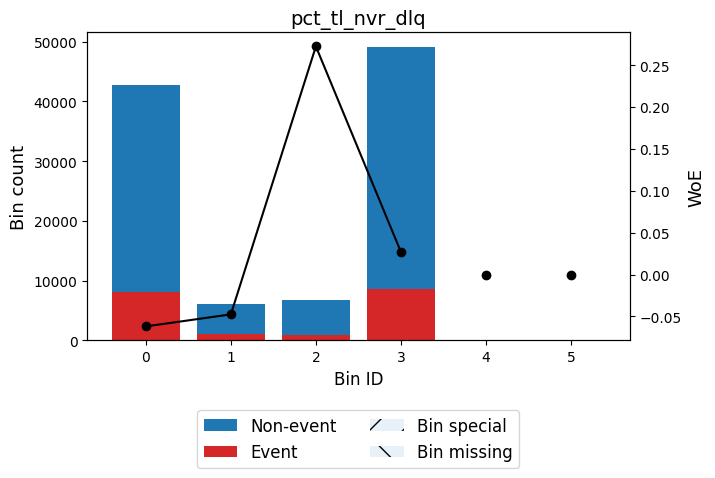


🔍 Feature: percent_bc_gt_75
✅ Total IV for percent_bc_gt_75: 0.0297
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 4.90)   │   21299 │             0.1422 │ 0.27090648452867305   │ 0.0136435   │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [4.90, 44.05)  │   31466 │             0.1658 │ 0.08981381059713889   │ 0.00235237  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [44.05, 52.75) │   11977 │             0.1823 │ -0.025051478103823133 │ 7.22978e-05 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [52.75, 67.70) │   11415 │             0.2005 │ -0.1431089122813609   │ 0.00233403  │
├────────────────┼─────────┼────────────────────┼──

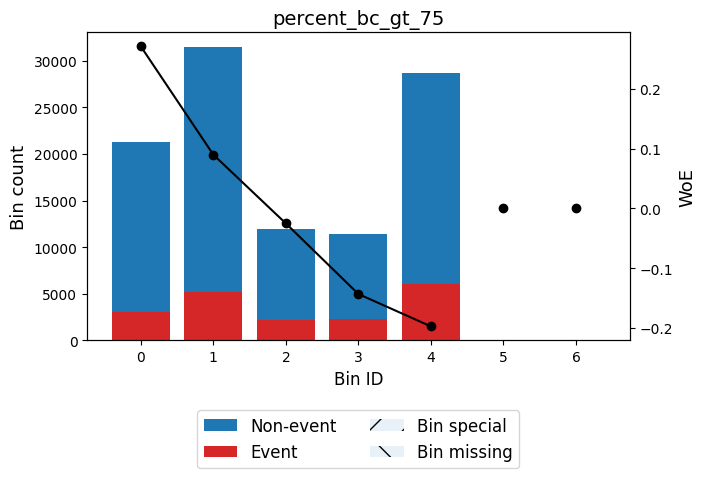


🔍 Feature: pub_rec_bankruptcies
✅ Total IV for pub_rec_bankruptcies: 0.0036
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   92574 │             0.1753 │ 0.022490862788275612 │ 0.000443585 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, inf)  │   12230 │             0.2034 │ -0.16064944019420535 │ 0.00316847  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼───

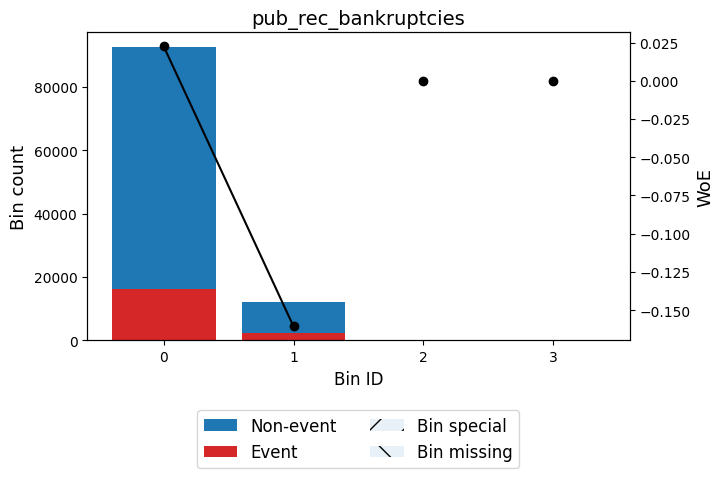


🔍 Feature: tax_liens
✅ Total IV for tax_liens: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  104804 │             0.1786 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  104804 │             0.1786 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛


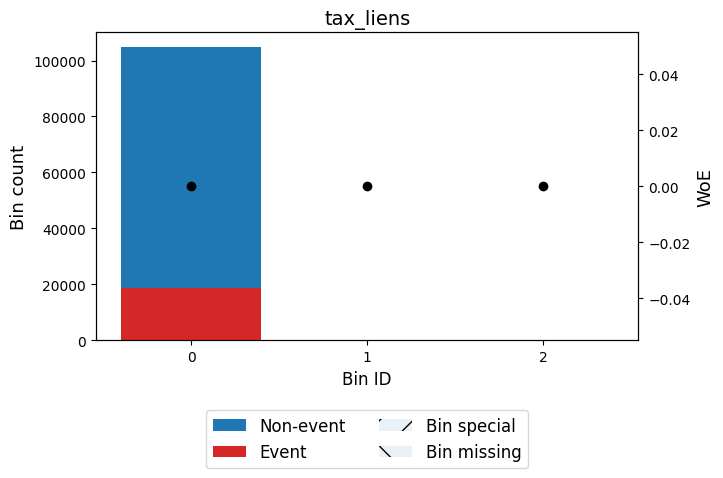


🔍 Feature: tot_hi_cred_lim
✅ Total IV for tot_hi_cred_lim: 0.0291
╒════════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                    │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 46920.50)       │   22829 │             0.1895 │ -0.07254656927084646 │ 0.00117326  │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [46920.50, 111203.50)  │   26015 │             0.2084 │ -0.1914018828597841  │ 0.00965841  │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [111203.50, 244077.00) │   30562 │             0.1753 │ 0.022290587141250207 │ 0.000143856 │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [244077.00, 481131.50) │   20102 │             0.1475 │ 0.22784591617351047 

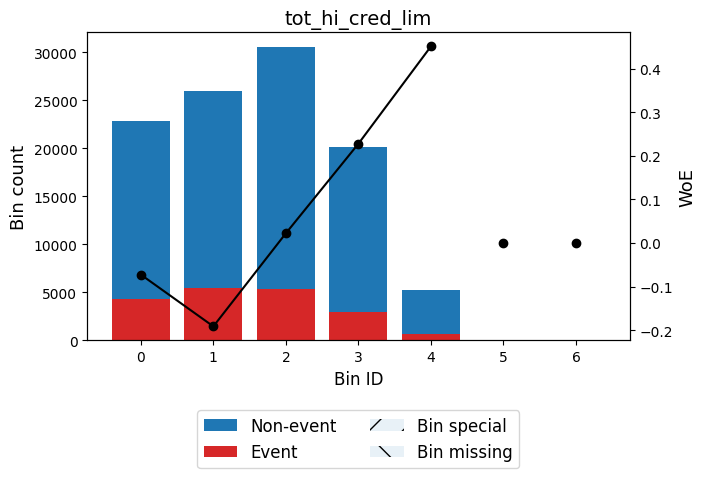


🔍 Feature: total_bal_ex_mort
✅ Total IV for total_bal_ex_mort: 0.0100
╒═══════════════════════╤═════════╤════════════════════╤════════════════════════╤═════════════╕
│ Bin                   │   Count │   Default Rate (%) │ WOE                    │          IV │
╞═══════════════════════╪═════════╪════════════════════╪════════════════════════╪═════════════╡
│ (-inf, 9589.50)       │    7761 │             0.1446 │ 0.2517271888203758     │ 0.00432011  │
├───────────────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤
│ [9589.50, 18598.50)   │   13041 │             0.1634 │ 0.1069670929123574     │ 0.00137516  │
├───────────────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤
│ [18598.50, 40964.50)  │   38520 │             0.1748 │ 0.026095229933231323   │ 0.000248187 │
├───────────────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤
│ [40964.50, 116224.50) │   38683 │             0.1942 │ -0.10346

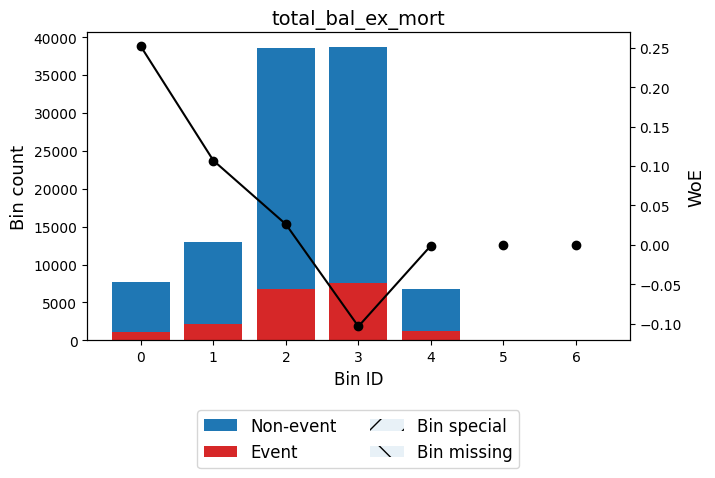


🔍 Feature: total_bc_limit
✅ Total IV for total_bc_limit: 0.0285
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 11041.00)     │   38173 │             0.2031 │ -0.1591009322218171  │ 0.00969523  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [11041.00, 14717.50) │   11629 │             0.1869 │ -0.05614644040473871 │ 0.000356125 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [14717.50, 41223.00) │   42128 │             0.1693 │ 0.06468951266771139  │ 0.00164731  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [41223.00, 52309.50) │    5244 │             0.1384 │ 0.3021533283870106   │ 0.00413511  │
├────

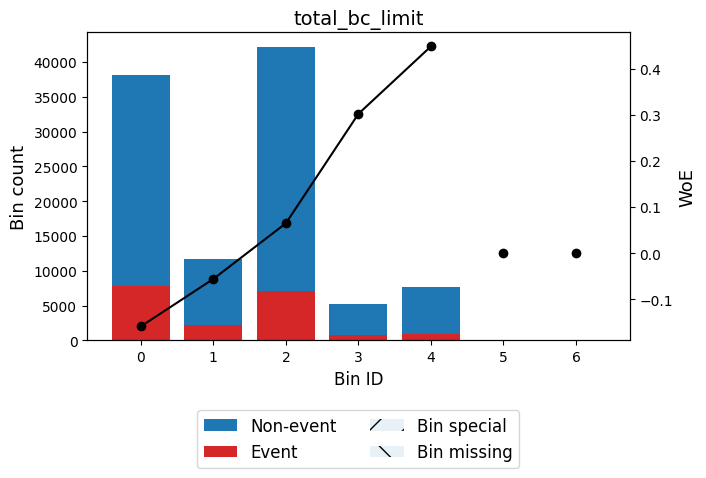


🔍 Feature: total_il_high_credit_limit
✅ Total IV for total_il_high_credit_limit: 0.0080
╒══════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 30337.50)     │   47869 │             0.1739 │ 0.03217500162385045   │ 0.000467959 │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [30337.50, 31297.00) │    7756 │             0.1423 │ 0.26985625965963567   │ 0.00493154  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [31297.00, 41458.50) │   12045 │             0.1813 │ -0.018691828348608386 │ 4.03959e-05 │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [41458.50, 73537.00) │   22112 │             0.1906 │ -0.079844

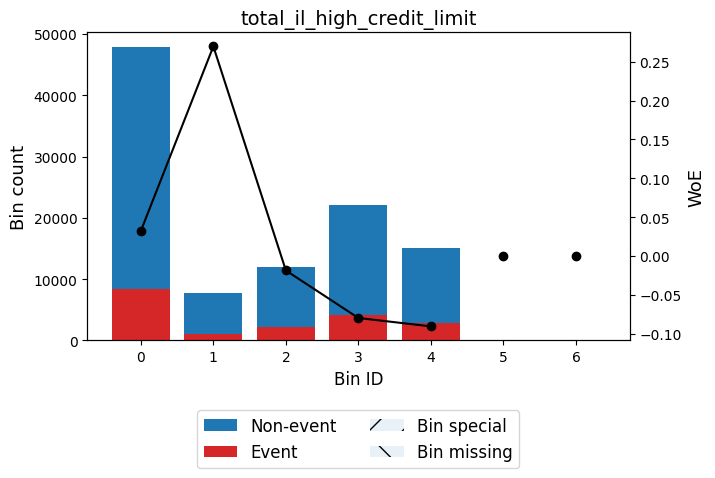


🔍 Feature: credit_history_years
✅ Total IV for credit_history_years: 0.0062
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │         IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪════════════╡
│ (-inf, 9.50)   │   17713 │             0.1845 │ -0.039951196895700036 │ 0.00027323 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼────────────┤
│ [9.50, 10.50)  │    6425 │             0.2033 │ -0.16013127719493503  │ 0.00165356 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼────────────┤
│ [10.50, 14.50) │   29007 │             0.1876 │ -0.060505433801502306 │ 0.00103302 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼────────────┤
│ [14.50, 20.50) │   28372 │             0.1735 │ 0.03503418910728229   │ 0.00032854 │
├────────────────┼─────────┼────────────────────┼────

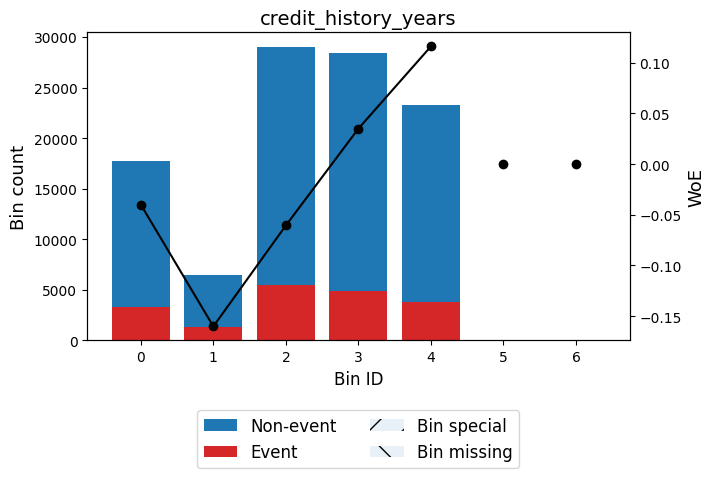


🔍 Feature: fico_score
✅ Total IV for fico_score: 0.1153
╒══════════════════╤═════════╤════════════════════╤═════════════════════╤════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                 │         IV │
╞══════════════════╪═════════╪════════════════════╪═════════════════════╪════════════╡
│ (-inf, 679.50)   │   36036 │             0.2264 │ -0.2974409901774262 │ 0.0333644  │
├──────────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [679.50, 699.50) │   28618 │             0.1896 │ -0.073288744236218  │ 0.00150138 │
├──────────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [699.50, 719.50) │   19444 │             0.1542 │ 0.17601553305215556 │ 0.00542686 │
├──────────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [719.50, 739.50) │   10135 │             0.126  │ 0.4106860746344623  │ 0.0142322  │
├──────────────────┼─────────┼────────────────────┼─────────────────────┼

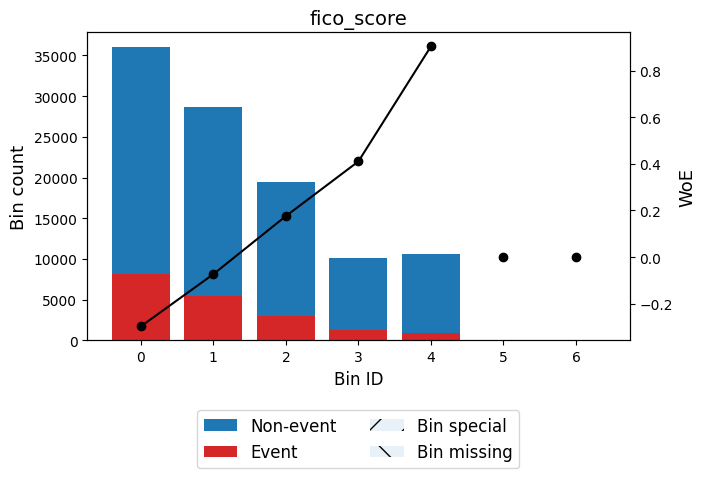


🔍 Feature: fico_score/delinq_2yrs_invalid
✅ Total IV for fico_score/delinq_2yrs_invalid: 0.0022
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   20355 │             0.1928 │ -0.09437877300133724 │ 0.00178274  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, inf)  │   84449 │             0.1751 │ 0.023621249937080924 │ 0.000446187 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────

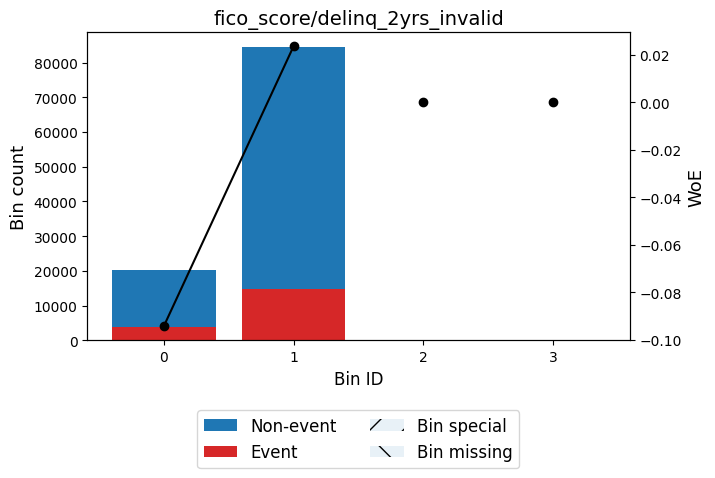


🔍 Feature: fico_score/delinq_2yrs
✅ Total IV for fico_score/delinq_2yrs: 0.0064
╒══════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 40.31)    │   84453 │             0.1751 │ 0.023678670051362927 │ 0.000448372 │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [40.31, 398.50)  │    6935 │             0.1993 │ -0.13531475690215    │ 0.00126468  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [398.50, 684.50) │    7610 │             0.2126 │ -0.21688692623752348 │ 0.00365623  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [684.50, inf)    │    5806 │             0.1593 │ 0.13719030455858028  │ 0.000997133 │
├──────────────────┼─────────

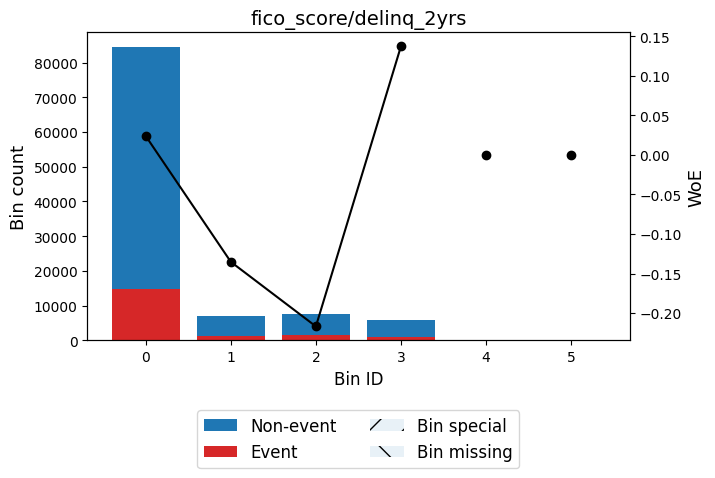


🔍 Feature: fico_score/acc_now_delinq_invalid
✅ Total IV for fico_score/acc_now_delinq_invalid: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  104804 │             0.1786 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  104804 │             0.1786 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛


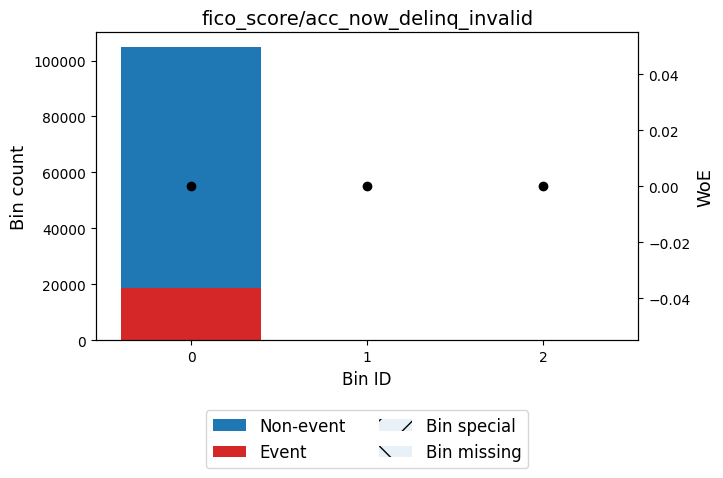


🔍 Feature: fico_score/acc_now_delinq
✅ Total IV for fico_score/acc_now_delinq: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  104804 │             0.1786 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  104804 │             0.1786 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛


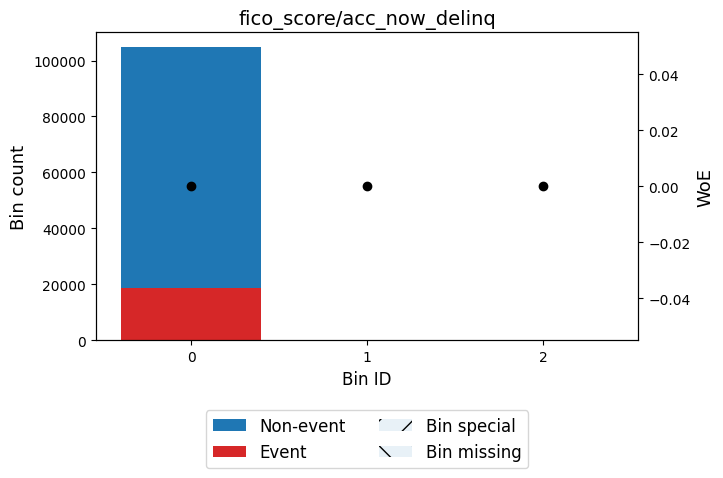


🔍 Feature: fico_score/inq_last_6mths_invalid
✅ Total IV for fico_score/inq_last_6mths_invalid: 0.0233
╒══════════════╤═════════╤════════════════════╤═════════════════════╤═══════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                 │        IV │
╞══════════════╪═════════╪════════════════════╪═════════════════════╪═══════════╡
│ (-inf, 0.50) │   45407 │             0.2043 │ -0.1662650630220437 │ 0.0126225 │
├──────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ [0.50, inf)  │   59397 │             0.1589 │ 0.1402112562715041  │ 0.0106445 │
├──────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ Special      │       0 │             0      │ 0.0                 │ 0         │
├──────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ Missing      │       0 │             0      │ 0.0                 │ 0         │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────

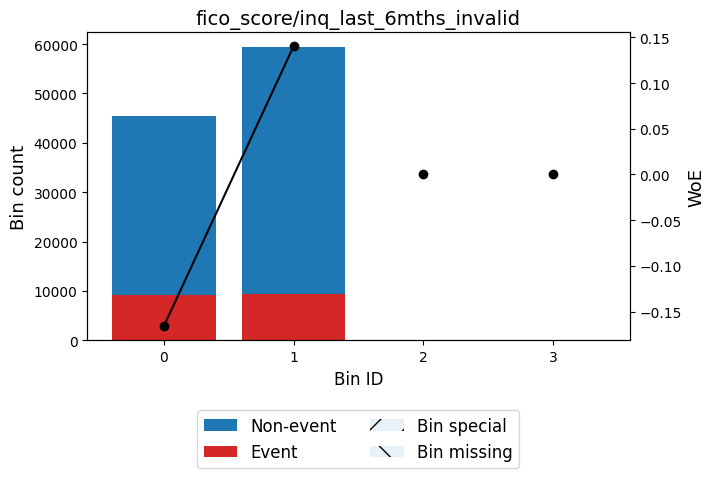


🔍 Feature: fico_score/inq_last_6mths
✅ Total IV for fico_score/inq_last_6mths: 0.0536
╒══════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 112.42)   │   59430 │             0.1589 │ 0.140367891525212    │ 0.0106737  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [112.42, 344.75) │   11788 │             0.2489 │ -0.4216186992269826  │ 0.0227401  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [344.75, 684.50) │   17811 │             0.216  │ -0.23726391265954438 │ 0.0103045  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [684.50, 704.50) │    7126 │             0.1896 │ -0.07342815638634659 │ 0.00037529 │
├──────────────────┼─────────┼───

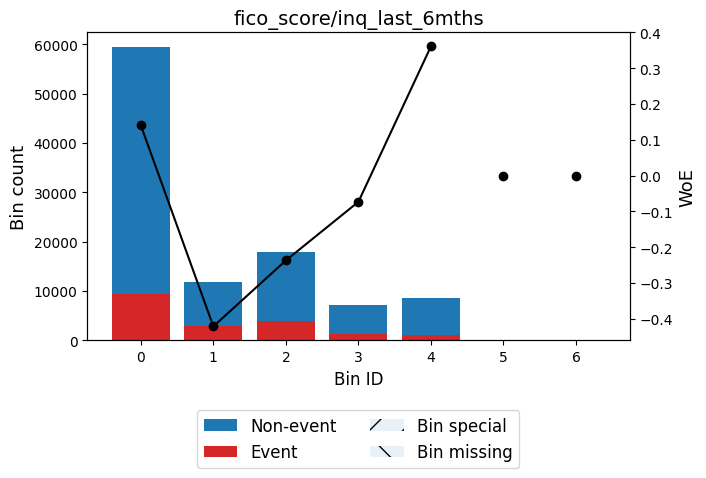


🔍 Feature: delinq_2yrs/credit_history_invalid
⚠️ Not enough variation. Skipping.

🔍 Feature: delinq_2yrs/credit_history
✅ Total IV for delinq_2yrs/credit_history: 0.0033
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 0.04) │   85962 │             0.1752 │ 0.023296084192024225  │ 0.000441809 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.04, 0.07) │    7435 │             0.1817 │ -0.021304038397157443 │ 3.24186e-05 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.07, 0.12) │    5742 │             0.1968 │ -0.11967738413357853  │ 0.000815094 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [0.12, inf)  │    5665 │             0.2074 │ -0.1855

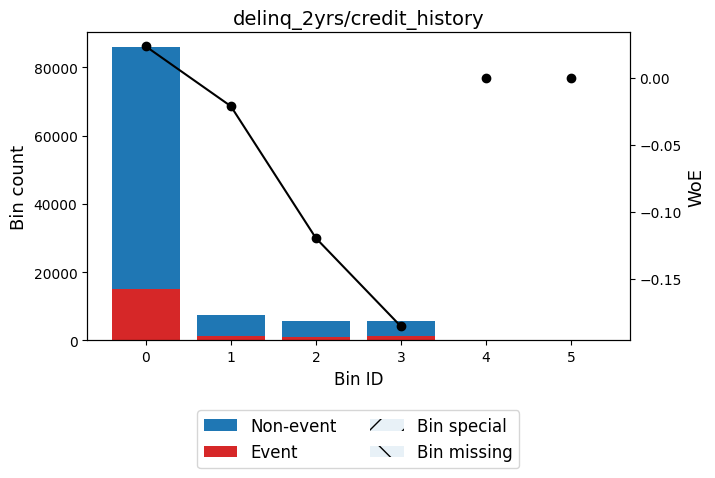


🔍 Feature: late_pymt_hist_invalid
⚠️ Not enough variation. Skipping.

🔍 Feature: late_pymt_hist
✅ Total IV for late_pymt_hist: 0.0042
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.06) │   86345 │             0.1741 │ 0.030776023063922908 │ 0.000772636 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.06, 0.10) │    8292 │             0.2021 │ -0.1530403981546431  │ 0.00194496  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.10, inf)  │   10167 │             0.1973 │ -0.12289733286877991 │ 0.00152348  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────

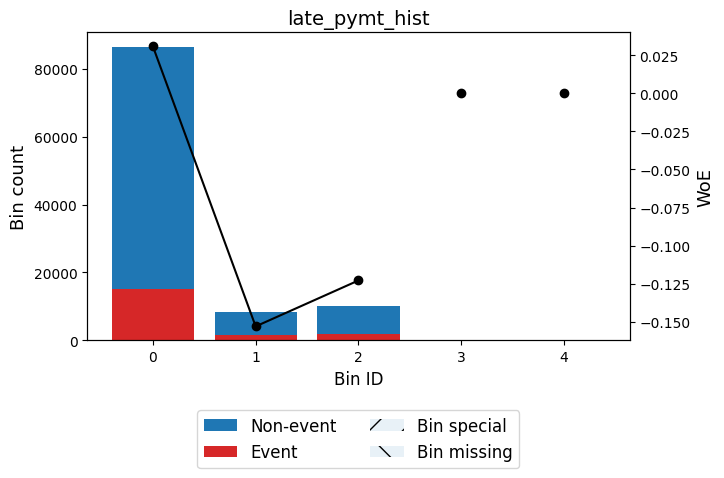


🔍 Feature: loan_amnt/annual_inc_invalid
⚠️ Not enough variation. Skipping.

🔍 Feature: loan_amnt/annual_inc
✅ Total IV for loan_amnt/annual_inc: 0.1285
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.10) │   15722 │             0.1127 │ 0.5372493022683433   │ 0.0361844   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.10, 0.17) │   25566 │             0.1366 │ 0.31780445355719444  │ 0.0221852   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.17, 0.26) │   30216 │             0.1715 │ 0.04868956141038705  │ 0.000672825 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.26, 0.33) │   16143 │             0.2231 │ -0.27824992636205104 │ 0.0130049  

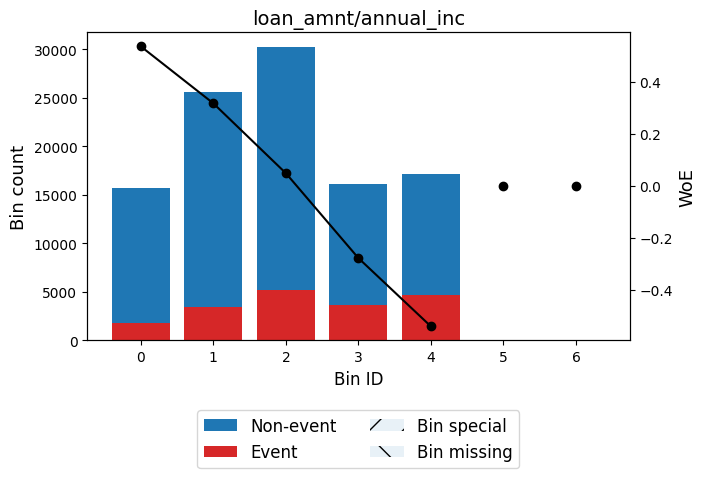


🔍 Feature: revol_util/annual_inc_invalid
⚠️ Not enough variation. Skipping.

🔍 Feature: revol_util/annual_inc
✅ Total IV for revol_util/annual_inc: 0.0455
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.00) │   15371 │             0.1278 │ 0.394672394871008    │ 0.0200431   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.00, 0.00) │   19597 │             0.1513 │ 0.1979328261561204   │ 0.00686641  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.00, 0.00) │   23719 │             0.1783 │ 0.001526856965558654 │ 5.27354e-07 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.00, 0.00) │   25971 │             0.196  │ -0.11480386572190282 │ 0.003387

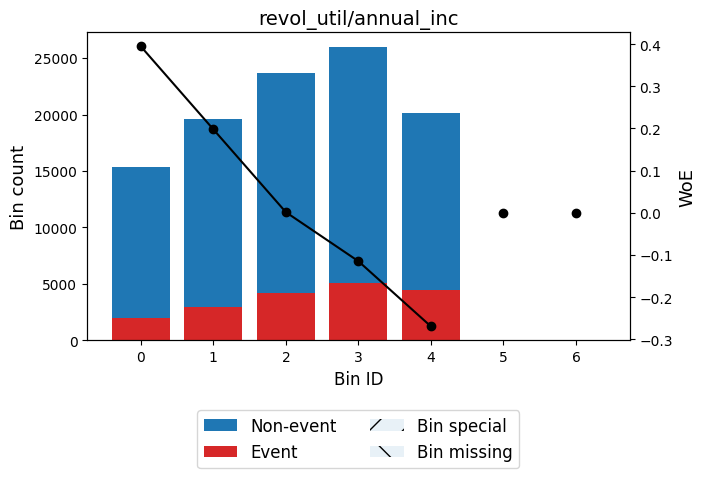


🔍 Feature: acc_op_past_24mths/total_acc_invalid
⚠️ Not enough variation. Skipping.

🔍 Feature: acc_op_past_24mths/total_acc
✅ Total IV for acc_op_past_24mths/total_acc: 0.0660
╒══════════════╤═════════╤════════════════════╤═════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                 │         IV │
╞══════════════╪═════════╪════════════════════╪═════════════════════╪════════════╡
│ (-inf, 0.07) │   12695 │             0.1187 │ 0.47859950187921285 │ 0.0236567  │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [0.07, 0.11) │   13640 │             0.1408 │ 0.2828502442930343  │ 0.00948669 │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [0.11, 0.19) │   32686 │             0.1659 │ 0.08898104575428945 │ 0.00239913 │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [0.19, 0.31) │   27537 │             0.2015 │ -0.1494679119626623 │ 0.0061

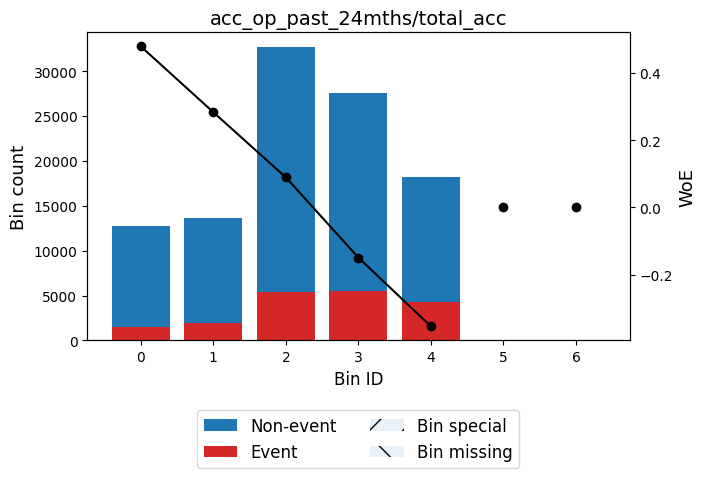


🔍 Feature: bc_open_to_buy/annual_inc_invalid
⚠️ Not enough variation. Skipping.

🔍 Feature: bc_open_to_buy/annual_inc
✅ Total IV for bc_open_to_buy/annual_inc: 0.0244
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.00) │    5353 │             0.2341 │ -0.3406750560198113  │ 0.00658547  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.00, 0.04) │   33719 │             0.1963 │ -0.11671989692924267 │ 0.00454865  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.04, 0.18) │   41251 │             0.1748 │ 0.02563926691315177  │ 0.000256614 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.18, 0.42) │   17056 │             0.1566 │ 0.15761170905954547

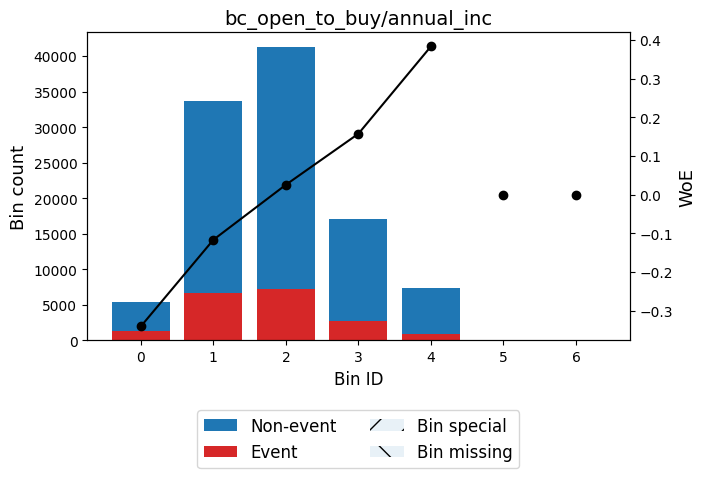


🔍 Feature: inq_last6mths_x_tl_op_past_12m
✅ Total IV for inq_last6mths_x_tl_op_past_12m: 0.0457
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 1.50) │   69035 │             0.159  │ 0.1397356458191068    │ 0.0122899   │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 2.50) │   10171 │             0.1784 │ 0.0007730221613631016 │ 5.79778e-08 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 4.50) │   12222 │             0.2105 │ -0.2043396040775023   │ 0.00519232  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [4.50, 8.50) │    7985 │             0.2361 │ -0.3517604035368507   │ 0.0105073   │
├──────────────┼─────────┼─────────────────

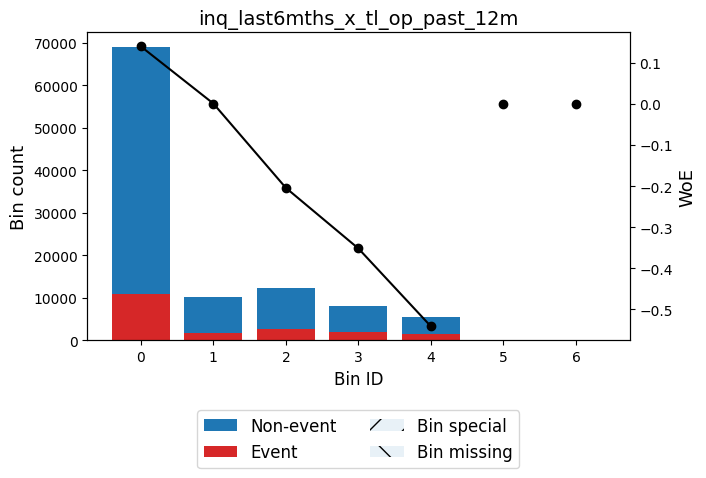


🔍 Feature: dti_x_revol_util
✅ Total IV for dti_x_revol_util: 0.0801
╒════════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin                │   Count │   Default Rate (%) │ WOE                  │         IV │
╞════════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 451.05)     │   24927 │             0.1261 │ 0.40951262068311745  │ 0.0348181  │
├────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [451.05, 902.94)   │   28578 │             0.1592 │ 0.1377098551590079   │ 0.00494444 │
├────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [902.94, 1314.82)  │   21007 │             0.1892 │ -0.0710521743312591  │ 0.00103511 │
├────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1314.82, 1965.88) │   19946 │             0.2182 │ -0.2501645207835541  │ 0.012879   │
├────────────────────┼─────────

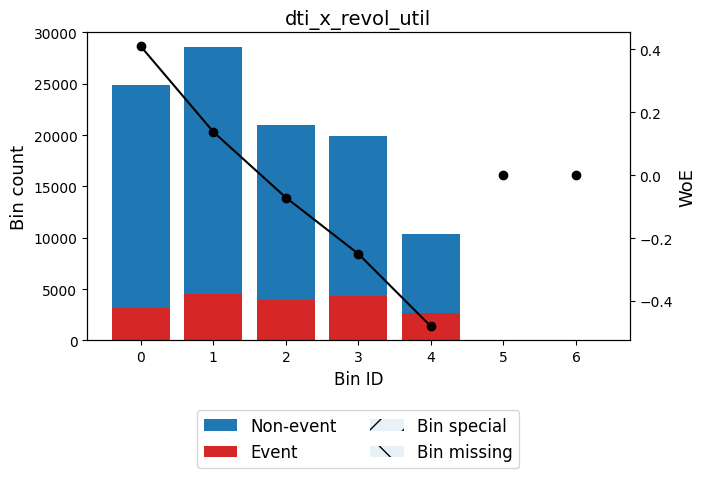


🔍 Feature: avail_ratio
✅ Total IV for avail_ratio: 0.0271
╒══════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, -96.85)   │    5422 │             0.2438 │ -0.3942801215353744  │ 0.00907543 │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [-96.85, -91.15) │   10420 │             0.2063 │ -0.17895468692011351 │ 0.00336882 │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [-91.15, -62.35) │   36159 │             0.19   │ -0.07625313404714573 │ 0.00205549 │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [-62.35, -36.15) │   31788 │             0.1667 │ 0.08331655861795828  │ 0.00204939 │
├──────────────────┼─────────┼────────────────────┼──────────

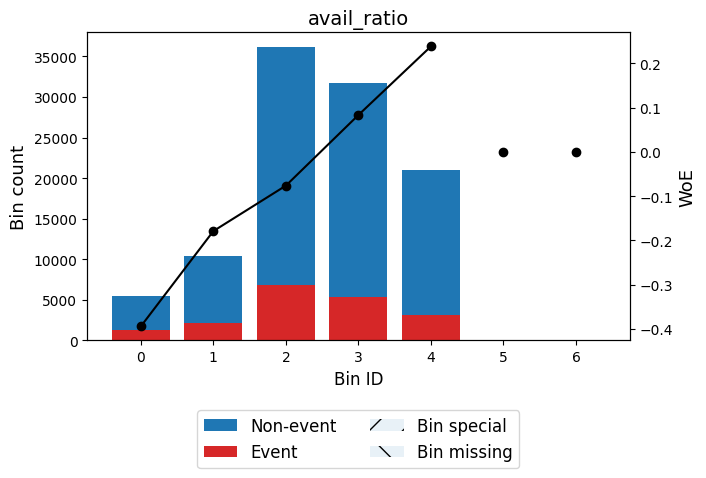


🔍 Feature: delinq2yrs_flag
✅ Total IV for delinq2yrs_flag: 0.0022
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   84449 │             0.1751 │ 0.023621249937080924 │ 0.000446187 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, inf)  │   20355 │             0.1928 │ -0.09437877300133724 │ 0.00178274  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0           │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────

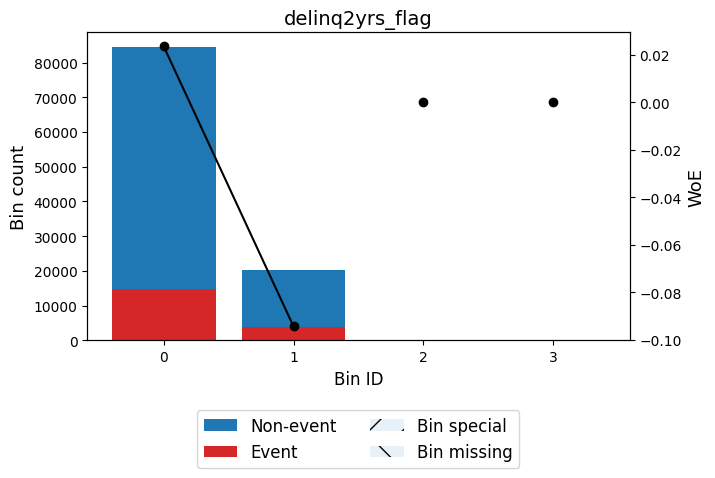


🔍 Feature: pubrec_flag
✅ Total IV for pubrec_flag: 0.0059
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.50) │   87730 │             0.1735 │ 0.034913284973516534 │ 0.00100893 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.50, inf)  │   17074 │             0.2046 │ -0.16821056251890565 │ 0.00486098 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Special      │       0 │             0      │ 0.0                  │ 0          │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Missing      │       0 │             0      │ 0.0                  │ 0          │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│              │ 

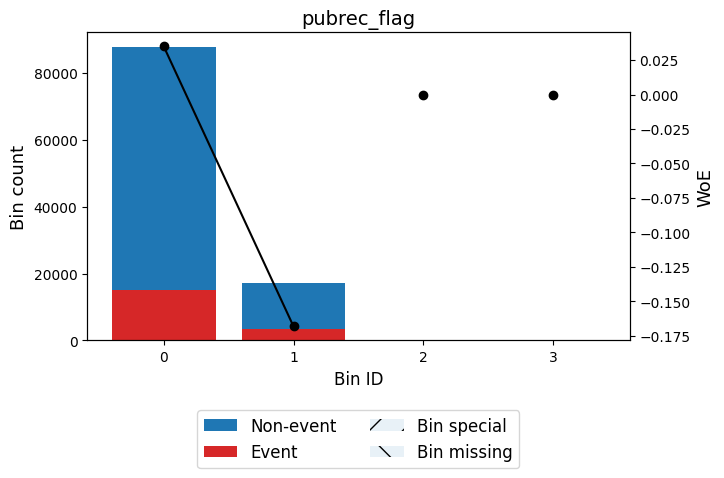


🔍 Feature: acc_now_delinq_flag
✅ Total IV for acc_now_delinq_flag: 0.0000
╒═════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin         │   Count │   Default Rate (%) │ WOE   │   IV │
╞═════════════╪═════════╪════════════════════╪═══════╪══════╡
│ (-inf, inf) │  104804 │             0.1786 │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing     │       0 │             0      │ 0.0   │    0 │
├─────────────┼─────────┼────────────────────┼───────┼──────┤
│             │  104804 │             0.1786 │       │    0 │
╘═════════════╧═════════╧════════════════════╧═══════╧══════╛


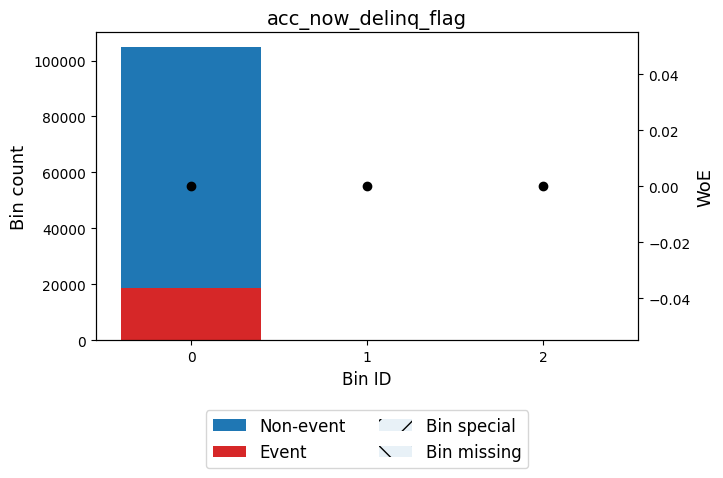


🔍 Feature: tl_op12m_x_inq6m
✅ Total IV for tl_op12m_x_inq6m: 0.0457
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 1.50) │   69035 │             0.159  │ 0.1397356458191068    │ 0.0122899   │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 2.50) │   10171 │             0.1784 │ 0.0007730221613631016 │ 5.79778e-08 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 4.50) │   12222 │             0.2105 │ -0.2043396040775023   │ 0.00519232  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [4.50, 8.50) │    7985 │             0.2361 │ -0.3517604035368507   │ 0.0105073   │
├──────────────┼─────────┼────────────────────┼───────────────────────┼

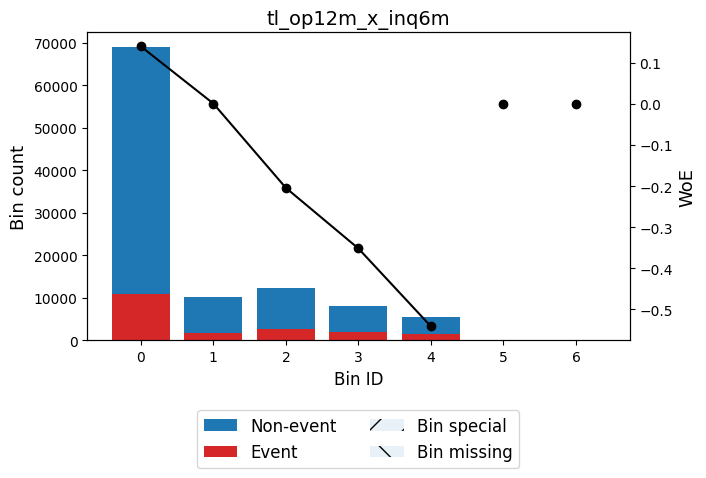


🔍 Feature: dti_x_inq
✅ Total IV for dti_x_inq: 0.0577
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 15.48)  │   72279 │             0.1572 │ 0.15332534581263357  │ 0.0154227   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [15.48, 23.56) │   11220 │             0.1881 │ -0.06402018691965261 │ 0.000447845 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [23.56, 32.05) │    8543 │             0.2209 │ -0.26559091668364765 │ 0.00624648  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [32.05, 51.88) │    7360 │             0.2501 │ -0.42823357160971853 │ 0.0146748   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼───

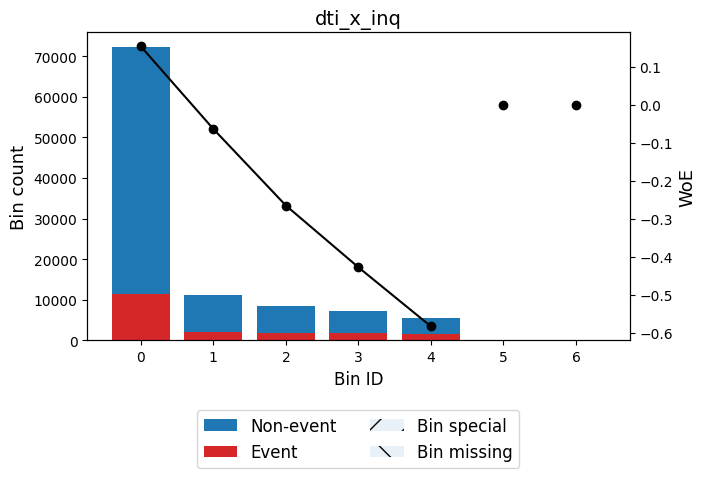


🔍 Feature: dti_x_term
✅ Total IV for dti_x_term: 0.2203
╒════════════════════╤═════════╤════════════════════╤═════════════════════╤════════════╕
│ Bin                │   Count │   Default Rate (%) │ WOE                 │         IV │
╞════════════════════╪═════════╪════════════════════╪═════════════════════╪════════════╡
│ (-inf, 549.90)     │   35842 │             0.1158 │ 0.5071071411427197  │ 0.0742569  │
├────────────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [549.90, 937.62)   │   38412 │             0.1609 │ 0.12513449830127987 │ 0.00551026 │
├────────────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [937.62, 1220.58)  │   16835 │             0.2251 │ -0.2897419124787015 │ 0.0147565  │
├────────────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [1220.58, 1460.10) │    6594 │             0.284  │ -0.6016421357139438 │ 0.0272228  │
├────────────────────┼─────────┼────────────────────┼

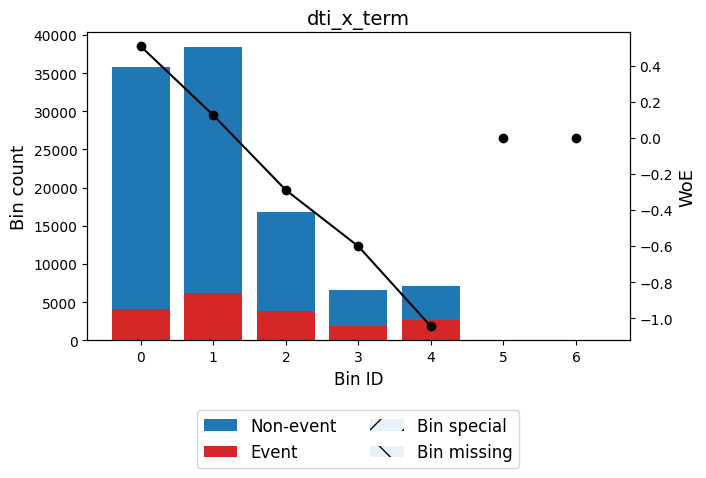


🔍 Feature: term_x_revol_util
✅ Total IV for term_x_revol_util: 0.1220
╒════════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin                │   Count │   Default Rate (%) │ WOE                  │         IV │
╞════════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 582.60)     │    6828 │             0.1134 │ 0.530781262175795    │ 0.0153727  │
├────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [582.60, 1829.40)  │   34976 │             0.1436 │ 0.25924831731314213  │ 0.020598   │
├────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1829.40, 2866.80) │   35057 │             0.1716 │ 0.048365354865761434 │ 0.00077034 │
├────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [2866.80, 3598.20) │   16276 │             0.1942 │ -0.10286052243256094 │ 0.00169775 │
├────────────────────┼───────

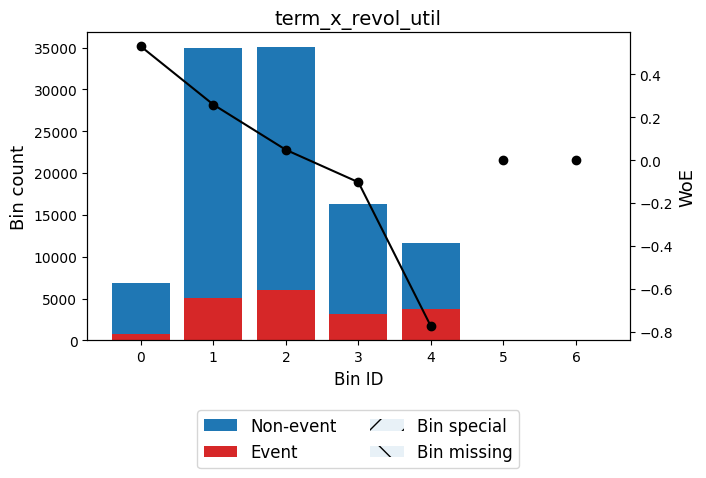


🔍 Feature: dti/fico_ratio_invalid
⚠️ Not enough variation. Skipping.

🔍 Feature: dti/fico_ratio
✅ Total IV for dti/fico_ratio: 0.1081
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.02) │   32170 │             0.1247 │ 0.42298993615522185  │ 0.0477223  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.02, 0.03) │   25414 │             0.1637 │ 0.10490868486118954  │ 0.00257946 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.03, 0.04) │   29055 │             0.1982 │ -0.12838694908896175 │ 0.00475955 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.04, 0.05) │   12661 │             0.2478 │ -0.41599708291507365 │ 0.0237389  │
├──────────────┼─────────

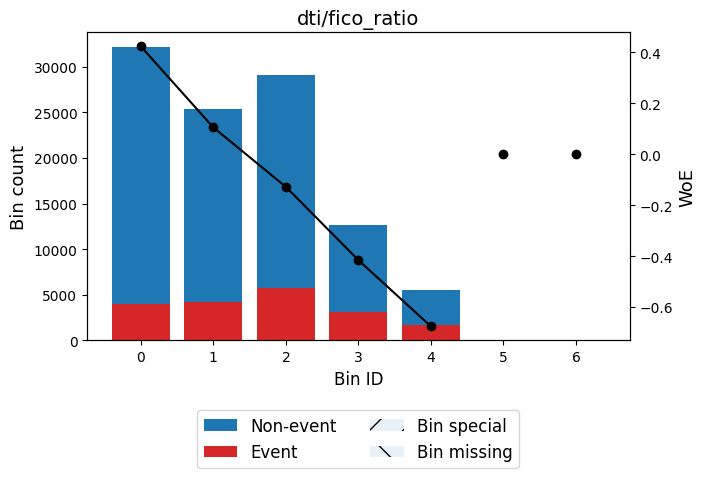


🔍 Feature: loan_amnt/tot_hi_cred_lim_invalid
⚠️ Not enough variation. Skipping.

🔍 Feature: loan_amnt/tot_hi_cred_lim
✅ Total IV for loan_amnt/tot_hi_cred_lim: 0.0703
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.03) │    8417 │             0.1103 │ 0.5620374696470245   │ 0.0210212  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.03, 0.06) │   18448 │             0.1311 │ 0.36492399619971194  │ 0.0207742  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.06, 0.11) │   27234 │             0.1682 │ 0.07251608483628624  │ 0.00133478 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.11, 0.23) │   24849 │             0.2006 │ -0.1433947460347318  │ 0.005

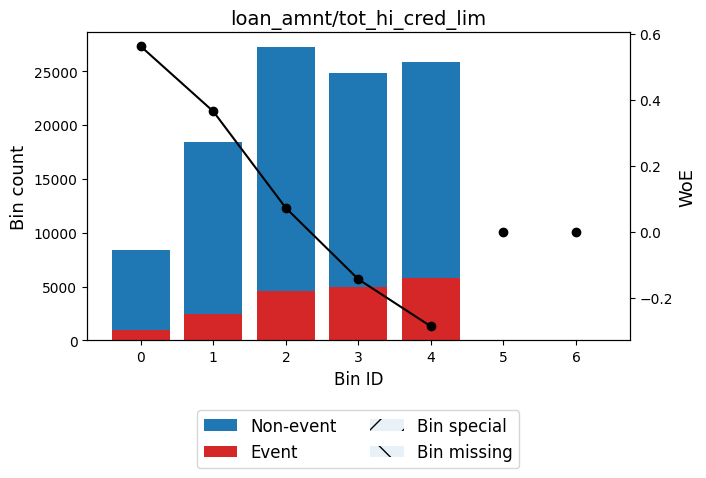


🔍 Feature: bc_open_to_buy/total_rev_hi_lim_invalid
⚠️ Not enough variation. Skipping.

🔍 Feature: bc_open_to_buy/total_rev_hi_lim
✅ Total IV for bc_open_to_buy/total_rev_hi_lim: 0.0394
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.01) │    6277 │             0.241  │ -0.37912813712930715 │ 0.00967199 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.01, 0.19) │   41588 │             0.2001 │ -0.14048811000854844 │ 0.00818824 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.19, 0.44) │   35951 │             0.1669 │ 0.08188195780808338  │ 0.0022397  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.44, 0.71) │   15740 │             0.1436 │ 0.25920437

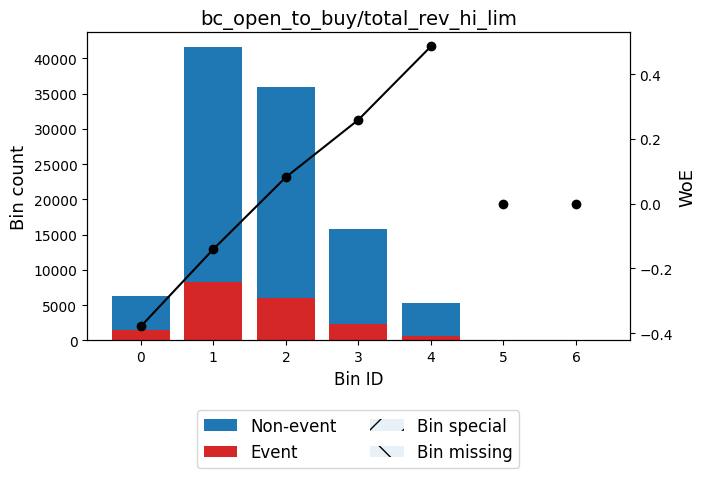


🔍 Feature: fico_score/int_rate_invalid
⚠️ Not enough variation. Skipping.

🔍 Feature: fico_score/int_rate
✅ Total IV for fico_score/int_rate: 0.4354
╒═════════════════╤═════════╤════════════════════╤══════════════════════╤═══════════╕
│ Bin             │   Count │   Default Rate (%) │ WOE                  │        IV │
╞═════════════════╪═════════╪════════════════════╪══════════════════════╪═══════════╡
│ (-inf, 40.76)   │   21094 │             0.3294 │ -0.8151433035812025  │ 0.168699  │
├─────────────────┼─────────┼────────────────────┼──────────────────────┼───────────┤
│ [40.76, 57.85)  │   37993 │             0.1966 │ -0.11836921576368487 │ 0.0052738 │
├─────────────────┼─────────┼────────────────────┼──────────────────────┼───────────┤
│ [57.85, 76.01)  │   21558 │             0.1273 │ 0.3986456914513574   │ 0.0286409 │
├─────────────────┼─────────┼────────────────────┼──────────────────────┼───────────┤
│ [76.01, 104.87) │   16670 │             0.0781 │ 0.942264527863736    │ 0.

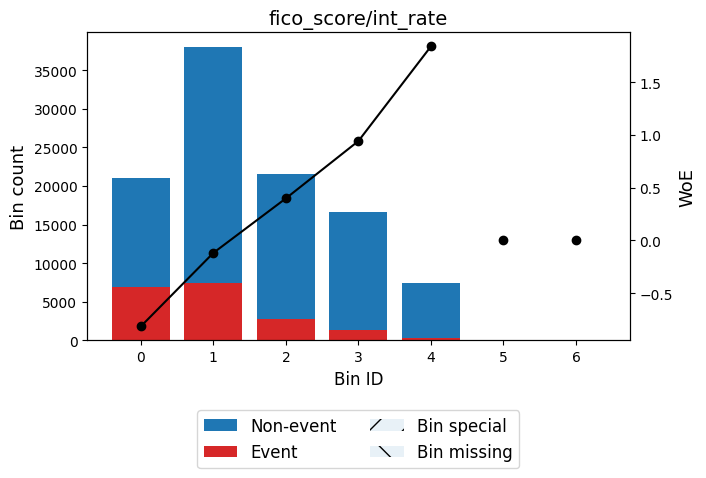


🔍 Feature: installment/annual_inc/12
✅ Total IV for installment/annual_inc/12: 0.0921
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.03) │   10601 │             0.1092 │ 0.5724579933139866   │ 0.0273685  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.03, 0.05) │   18263 │             0.1337 │ 0.34287223137223966  │ 0.0182913  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.05, 0.08) │   26479 │             0.1613 │ 0.12220409901808682  │ 0.00362612 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.08, 0.10) │   21761 │             0.1933 │ -0.09758931425460005 │ 0.00203982 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼───

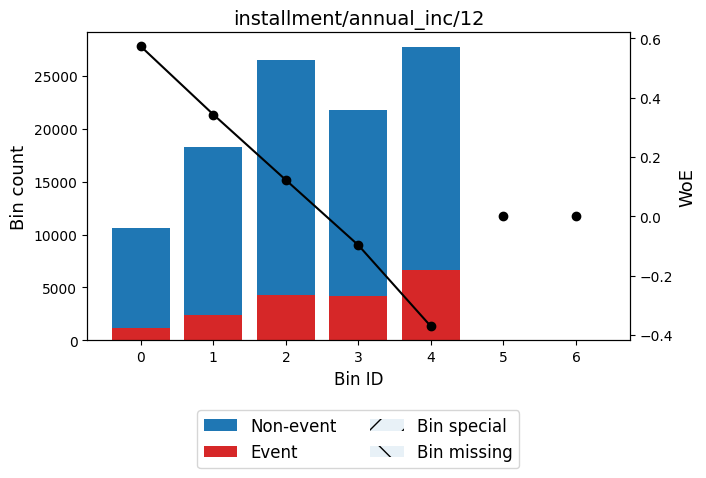


🔍 Feature: installment/annual_inc/12_x_term
✅ Total IV for installment/annual_inc/12_x_term: 0.2169
╒══════════════╤═════════╤════════════════════╤═════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                 │         IV │
╞══════════════╪═════════╪════════════════════╪═════════════════════╪════════════╡
│ (-inf, 1.82) │   25704 │             0.1103 │ 0.5612225909157016  │ 0.0640269  │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [1.82, 3.40) │   35100 │             0.1439 │ 0.2573530638778061  │ 0.0203828  │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [3.40, 4.56) │   18167 │             0.1894 │ -0.0722688416849604 │ 0.00092645 │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [4.56, 6.85) │   20021 │             0.2563 │ -0.460732079080052  │ 0.0466359  │
├──────────────┼─────────┼────────────────────┼─────────────────────┼

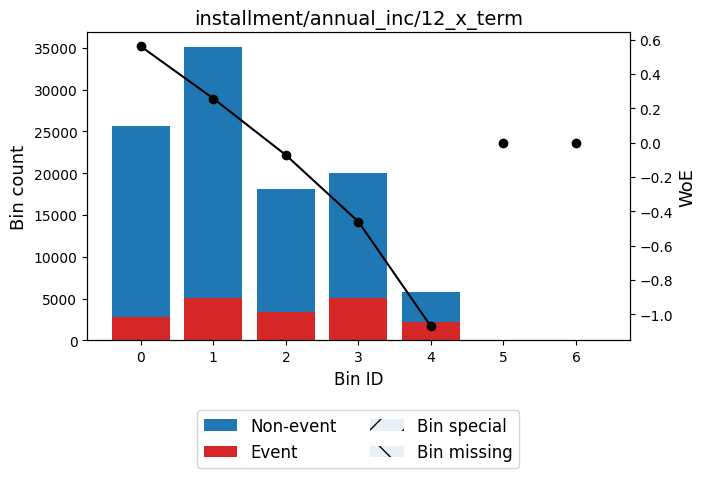

✅ Total IV for grade_numeric: 0.4525
╒══════════════╤═════════╤════════════════════╤═════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                 │         IV │
╞══════════════╪═════════╪════════════════════╪═════════════════════╪════════════╡
│ (-inf, 1.50) │   18877 │             0.0546 │ 1.325128834626995   │ 0.201688   │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [1.50, 2.50) │   31160 │             0.1206 │ 0.4609103760436568  │ 0.0541789  │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [2.50, 3.50) │   28917 │             0.2002 │ -0.1412528792558112 │ 0.00575698 │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [3.50, 4.50) │   15265 │             0.2702 │ -0.5326451391036483 │ 0.0484834  │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [4.50, inf)  │   10585 │             0.3789 │ -1

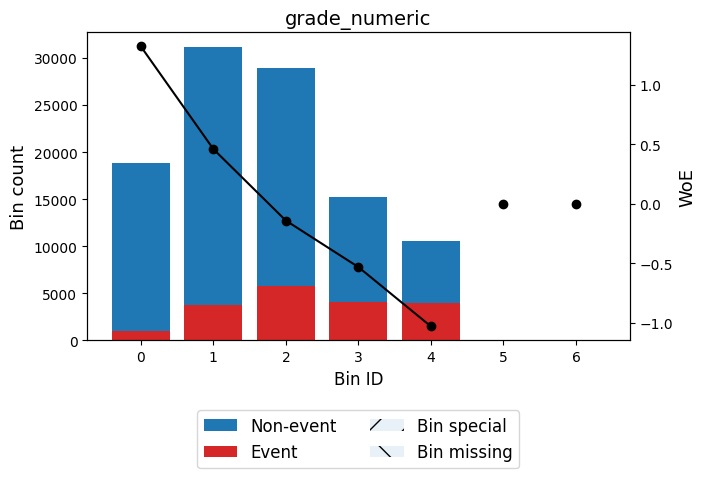

In [12]:
# == 1. Get Numeric Columns from Spark Dataframe ==
numerical_cols1 = get_numerical_cols(df1, TARGET_COL)

# == 2. Obtain Sampled Pandas Train, Test Dataframe from Spark Dataframe, orders them ==
train_pdf1, test_pdf1 = sample_split_order(
    initial_df=df1, sample_frac=0.1, cut_off_date=CUT_DATE, date_col="issue_d"
)

# == 3. Observe IV of Numerical Variables ==
for feature in numerical_cols1:
    if feature == "id":
        continue

    print(f"\n🔍 Feature: {feature}")

    if train_pdf1[feature].nunique() < 2:
        print("⚠️ Not enough variation. Skipping.")
        iv_categories["no_variation"].append(feature)
        continue

    x, y = train_pdf1[feature], train_pdf1[TARGET_COL]

    bin_and_classify_feature(feature=feature, x=x, y=y, monotonic_trend_type="auto")

# == Include grade_numeric as well (ordinal feature) ==
train_pdf1 = tx_grade(train_pdf1)

bin_and_classify_feature(
    "grade_numeric",
    train_pdf1["grade_numeric"],
    train_pdf1[TARGET_COL],
    dtype="numerical",
    monotonic_trend_type="auto",
)

### 2.2 Categorical Features IV


✅ Total IV for home_ownership: 0.0191
╒══════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ ['MORTGAGE']     │   52035 │             0.1595 │ 0.13577182825312417  │ 0.00875683  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ ['OWN']          │   10814 │             0.1765 │ 0.013912018181872599 │ 1.98813e-05 │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ ['OTHER' 'RENT'] │   41955 │             0.2027 │ -0.1567237930897296  │ 0.0103321   │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ Special          │       0 │             0      │ 0.0                  │ 0           │
├──────────────────┼─────────┼────────────────────┼─────────────────────

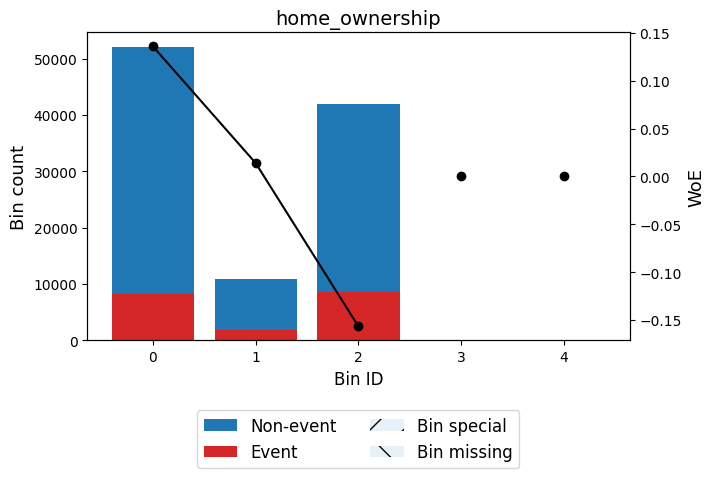

✅ Total IV for verification_status: 0.0523
╒═════════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin                 │   Count │   Default Rate (%) │ WOE                  │         IV │
╞═════════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ ['Not Verified']    │   31272 │             0.131  │ 0.36592108062639706  │ 0.0353959  │
├─────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ ['Source Verified'] │   40129 │             0.1879 │ -0.06269531681687956 │ 0.00153549 │
├─────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ ['Verified']        │   33403 │             0.2118 │ -0.21205578570440453 │ 0.0153188  │
├─────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Special             │       0 │             0      │ 0.0                  │ 0          │
├─────────────────────┼─────────┼──────────────

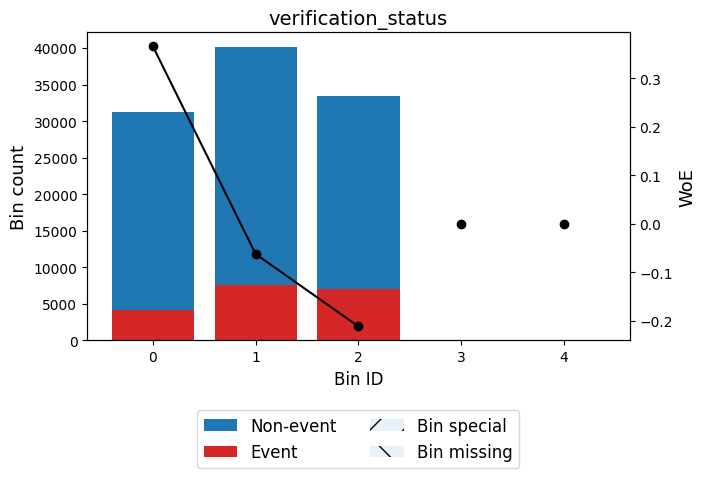

✅ Total IV for initial_list_status: 0.0005
╒═════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin     │   Count │   Default Rate (%) │ WOE                   │          IV │
╞═════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ ['f']   │   48197 │             0.175  │ 0.024256915944856905  │ 0.000268484 │
├─────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ ['w']   │   56607 │             0.1816 │ -0.020358927477206246 │ 0.00022534  │
├─────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ Special │       0 │             0      │ 0.0                   │ 0           │
├─────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ Missing │       0 │             0      │ 0.0                   │ 0           │
├─────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│         │  104804 │             0.1786 │                       │

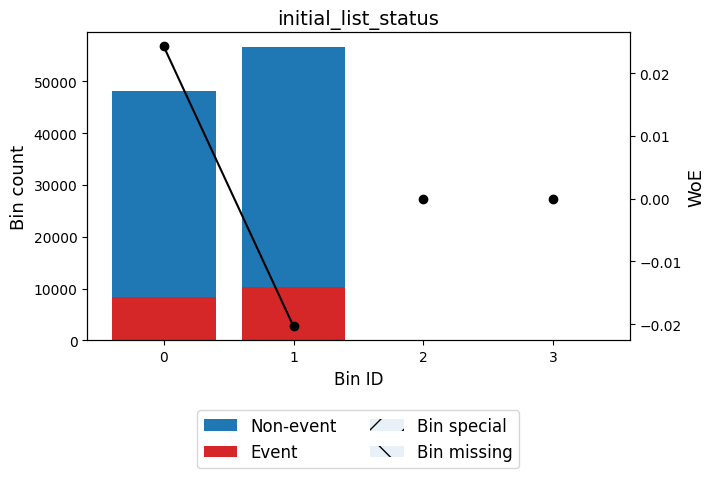

✅ Total IV for application_type: 0.0000
╒════════════════════════════╤═════════╤════════════════════╤═══════╤══════╕
│ Bin                        │   Count │   Default Rate (%) │ WOE   │   IV │
╞════════════════════════════╪═════════╪════════════════════╪═══════╪══════╡
│ ['Individual' 'Joint App'] │  104804 │             0.1786 │ 0.0   │    0 │
├────────────────────────────┼─────────┼────────────────────┼───────┼──────┤
│ Special                    │       0 │             0      │ 0.0   │    0 │
├────────────────────────────┼─────────┼────────────────────┼───────┼──────┤
│ Missing                    │       0 │             0      │ 0.0   │    0 │
├────────────────────────────┼─────────┼────────────────────┼───────┼──────┤
│                            │  104804 │             0.1786 │       │    0 │
╘════════════════════════════╧═════════╧════════════════════╧═══════╧══════╛


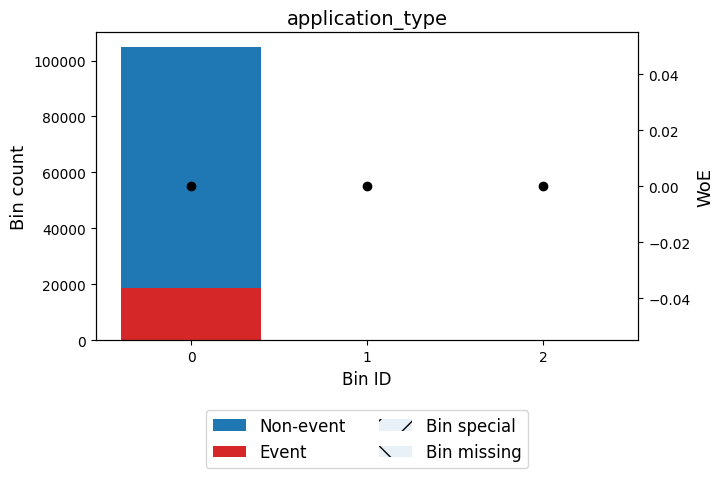

In [13]:
# == Observe IV of Categorical Variables ==
categorical_features = get_categorical_cols(df1, TARGET_COL)

for feat in categorical_features:
    if feat != "grade":
        bin_and_classify_feature(
            feat,
            train_pdf1[feat],
            train_pdf1[TARGET_COL],
            dtype="categorical",
            monotonic_trend_type="auto",
        )

### 2.3 Feature Importance Rankings


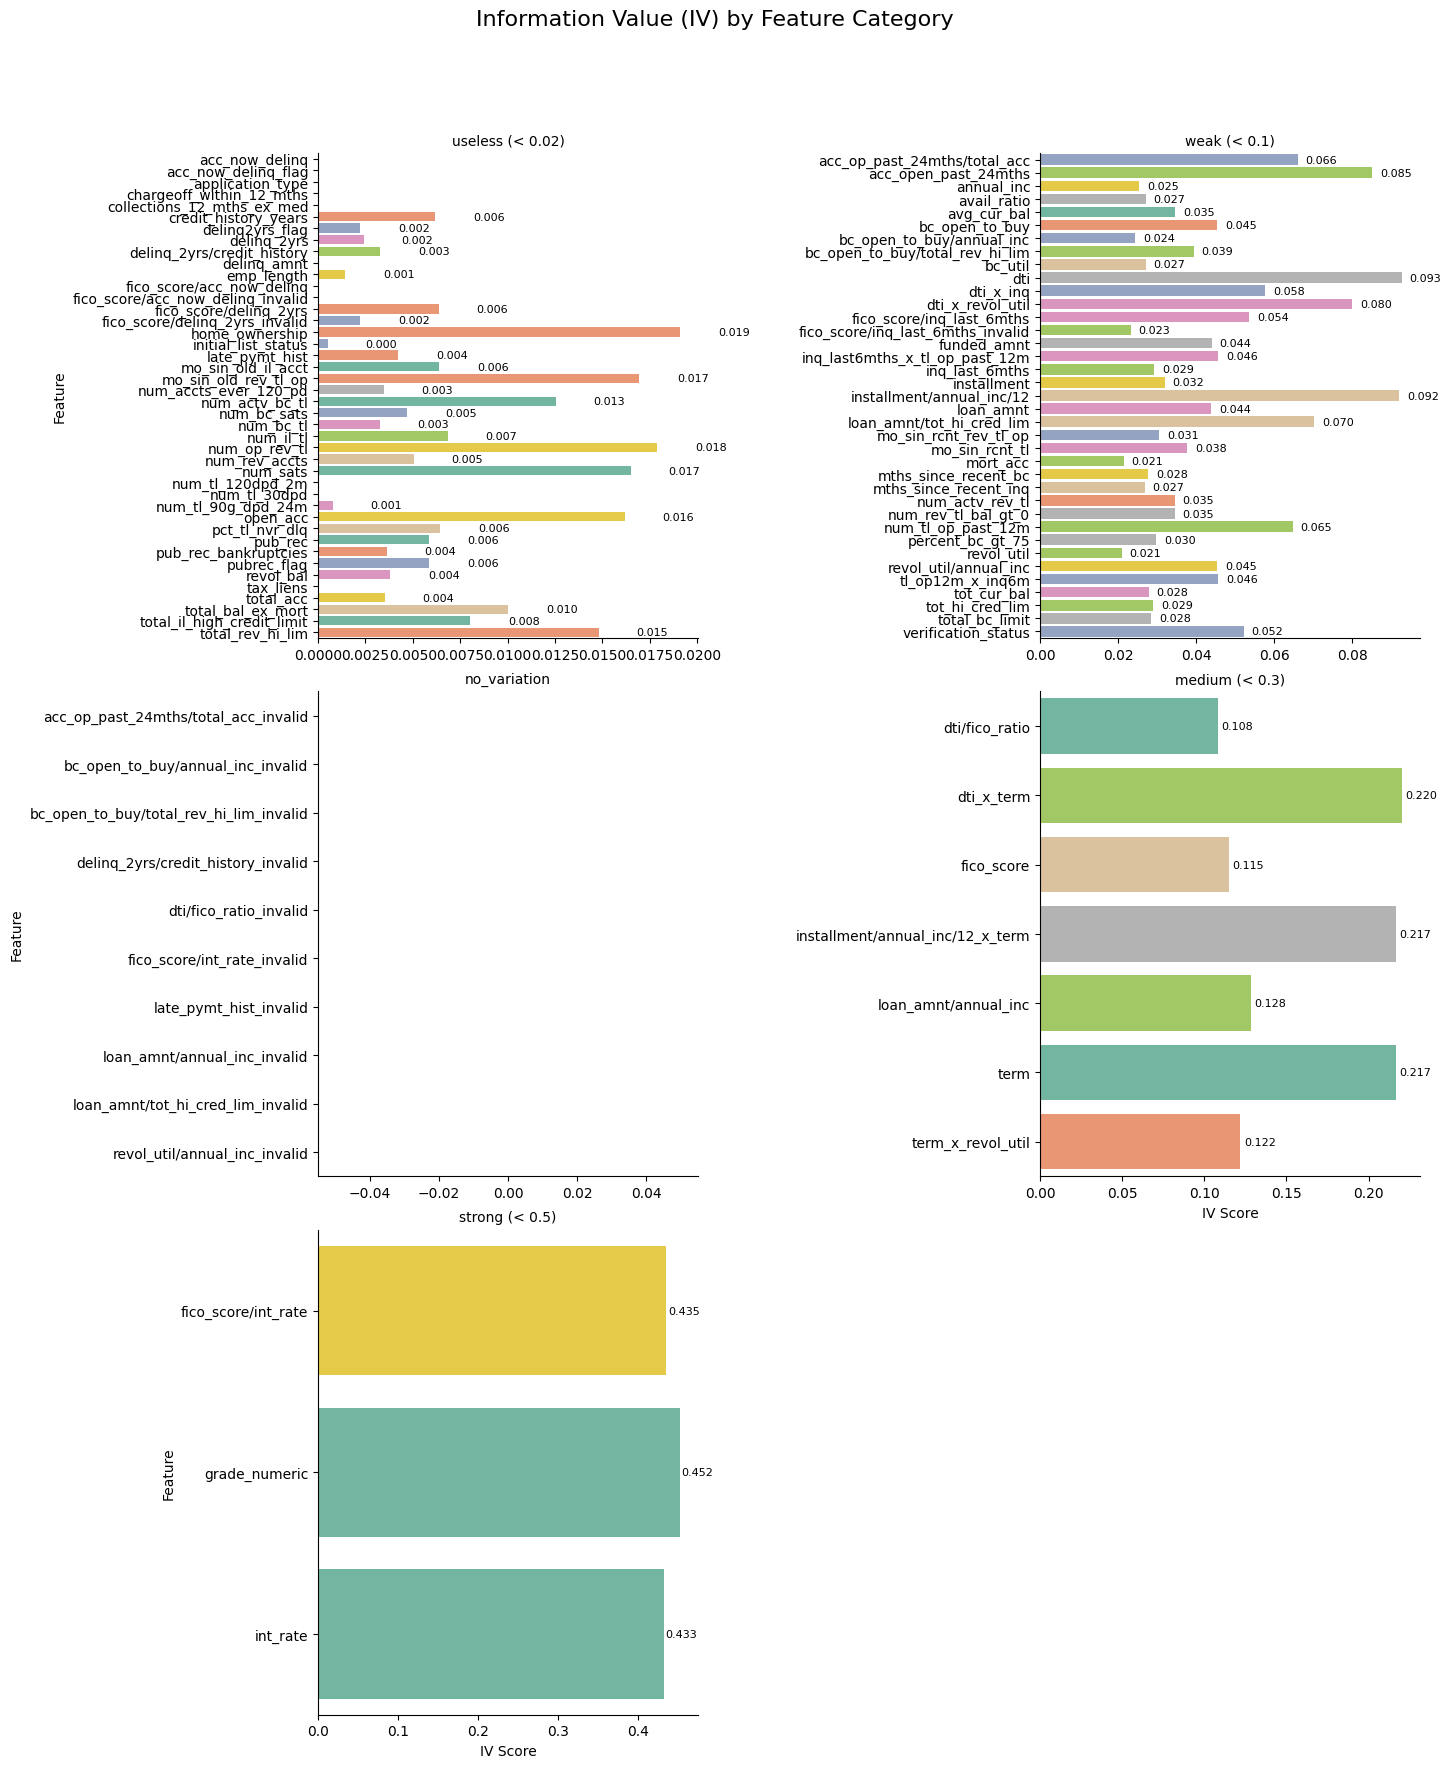

In [14]:
# == Compiled Feature Rankings (Categorical & Numerical) ==
plot_iv_by_category(iv_categories)

### 2.4 Feature Filtering

Now that we have identified the more relevant/important features for PD Modeling, lets drop the features and observe feature importance ranking & WoE trends.


In [15]:
# == Define columns to abandon & keep (Based on train_pdf1) ==
no_variation_columns = [
    item
    for category, feature_list in iv_categories.items()
    if category == "no_variation"
    for item in feature_list
]

useless_cols = [
    feature
    for category, feature_list in iv_categories.items()
    if category == "useless (< 0.02)"
    for feature, _ in feature_list
]

throw_cols = no_variation_columns + useless_cols
keep_cols = [c for c in train_pdf1.columns if c not in throw_cols]

train_pdf1 = train_pdf1.drop(columns=throw_cols)
print("✅ Dropped columns with IV < 0.02 and columns with no variation in TRAIN_DF1")

✅ Dropped columns with IV < 0.02 and columns with no variation in TRAIN_DF1


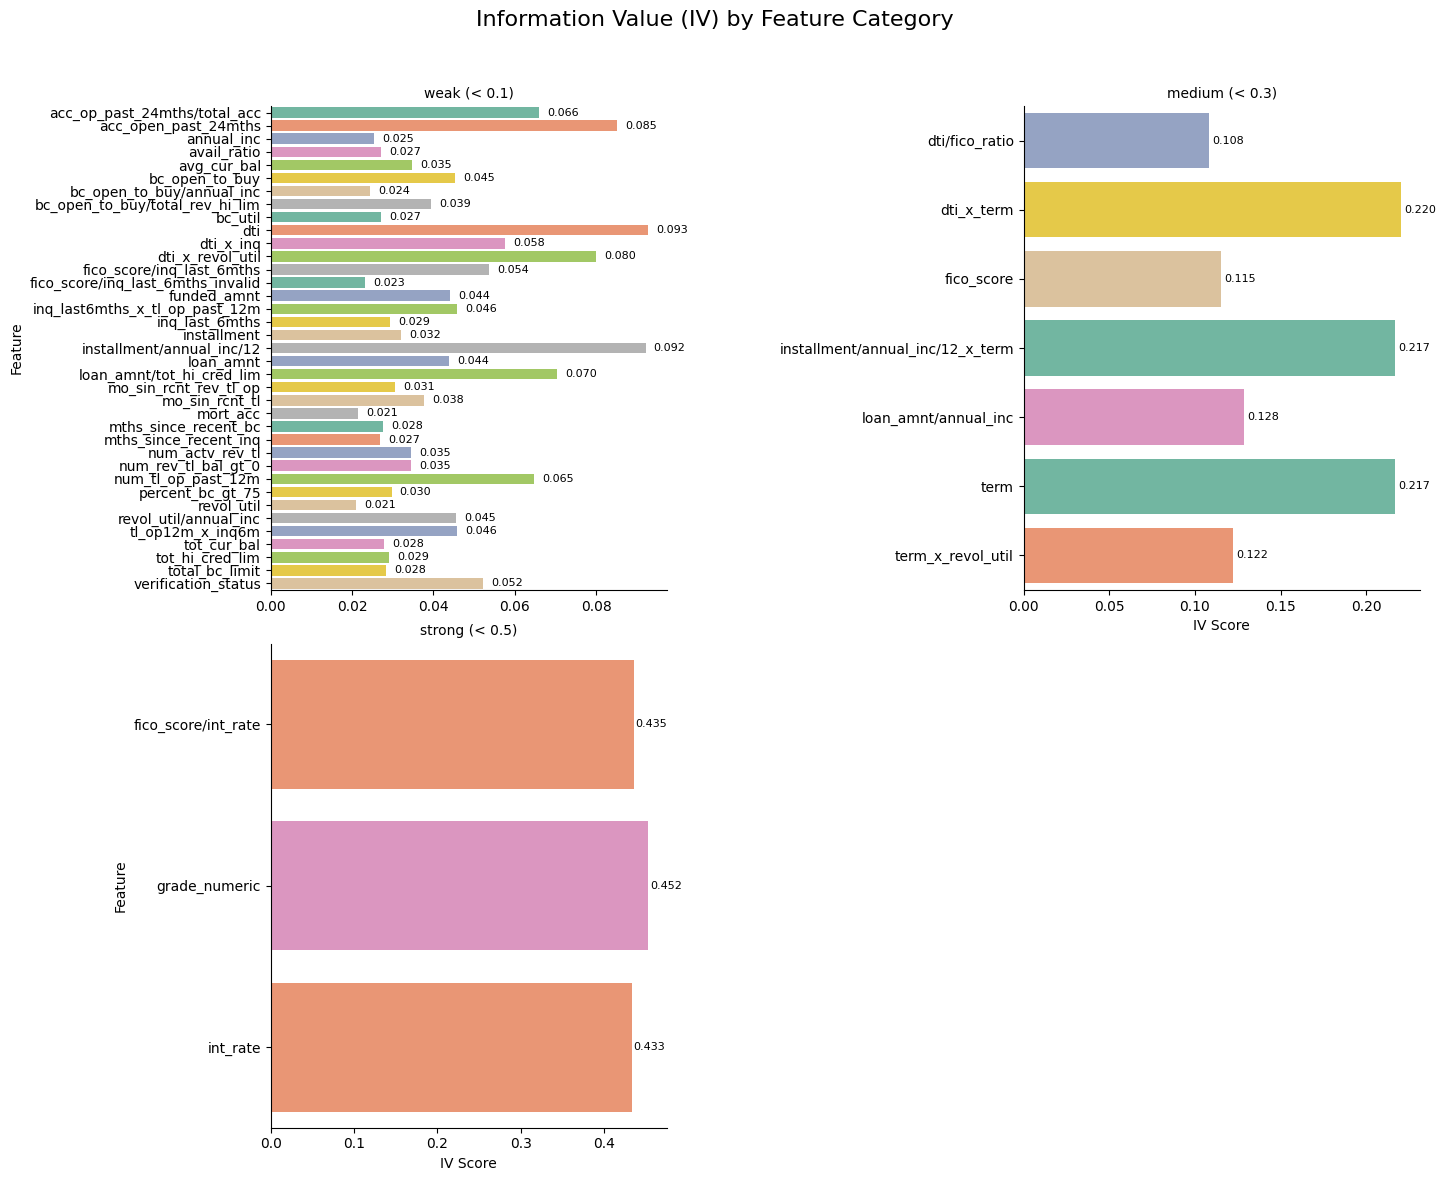

In [16]:
# == Leftover Columns IV in TRAIN_DF1 ==
updated_iv_categories = get_updated_iv_categories(iv_categories, train_pdf1)

plot_iv_by_category(updated_iv_categories)

In [17]:
train_pdf1.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'annual_inc', 'verification_status', 'issue_d', 'default_status', 'dti',
       'inq_last_6mths', 'revol_util', 'tot_cur_bal', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0',
       'num_tl_op_past_12m', 'percent_bc_gt_75', 'tot_hi_cred_lim',
       'total_bc_limit', 'fico_score', 'fico_score/inq_last_6mths_invalid',
       'fico_score/inq_last_6mths', 'loan_amnt/annual_inc',
       'revol_util/annual_inc', 'acc_op_past_24mths/total_acc',
       'bc_open_to_buy/annual_inc', 'inq_last6mths_x_tl_op_past_12m',
       'dti_x_revol_util', 'avail_ratio', 'tl_op12m_x_inq6m', 'dti_x_inq',
       'dti_x_term', 'term_x_revol_util', 'dti/fico_ratio',
       'loan_amnt/tot_hi_cred_lim', 'bc_open_to_buy/total_rev_hi_lim',
       'fic

✅ Total IV for acc_op_past_24mths/total_acc: 0.0660
╒══════════════╤═════════╤════════════════════╤═════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                 │         IV │
╞══════════════╪═════════╪════════════════════╪═════════════════════╪════════════╡
│ (-inf, 0.07) │   12695 │             0.1187 │ 0.47859950187921285 │ 0.0236567  │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [0.07, 0.11) │   13640 │             0.1408 │ 0.2828502442930343  │ 0.00948669 │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [0.11, 0.19) │   32686 │             0.1659 │ 0.08898104575428945 │ 0.00239913 │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [0.19, 0.31) │   27537 │             0.2015 │ -0.1494679119626623 │ 0.00615418 │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [0.31, inf)  │   18246 │         

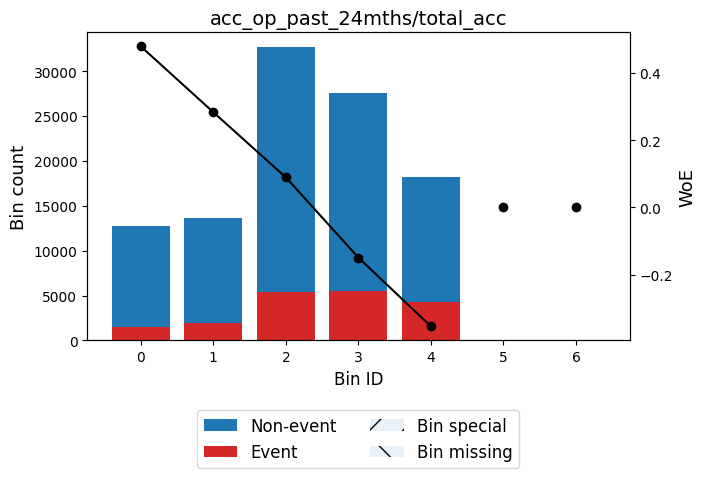

✅ Total IV for acc_open_past_24mths: 0.0852
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 2.50) │   26768 │             0.1293 │ 0.38107482616704424  │ 0.0326911  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [2.50, 4.50) │   33553 │             0.1615 │ 0.12116625540619697  │ 0.00451869 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [4.50, 6.50) │   21897 │             0.1946 │ -0.10597432380455207 │ 0.00242683 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [6.50, 9.50) │   15685 │             0.23   │ -0.317972138723281   │ 0.0166978  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [9.50, inf)  │    6901 │      

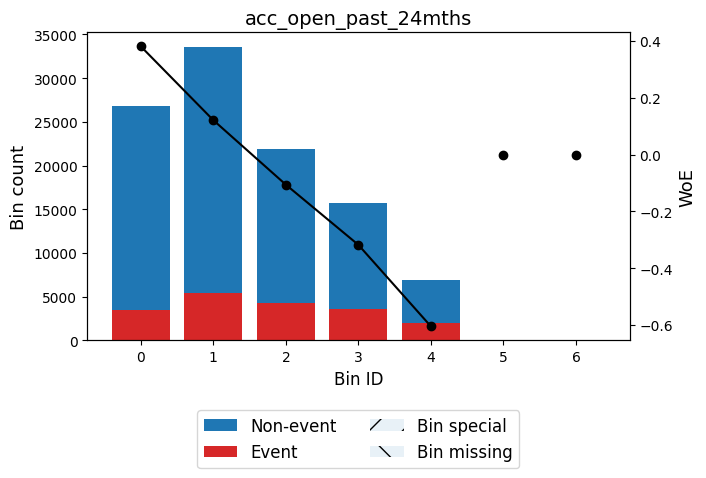

✅ Total IV for annual_inc: 0.0254
╒═══════════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin                   │   Count │   Default Rate (%) │ WOE                  │         IV │
╞═══════════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 45752.50)      │   26224 │             0.2046 │ -0.16846653812055346 │ 0.00748933 │
├───────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [45752.50, 75642.10)  │   40181 │             0.1869 │ -0.05586898532613804 │ 0.00121826 │
├───────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [75642.10, 96006.00)  │   16185 │             0.1648 │ 0.0964976706321714   │ 0.00139372 │
├───────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [96006.00, 125887.00) │   12394 │             0.152  │ 0.19280865491854637  │ 0.0041277  │
├───────────────────────┼─────────┼─

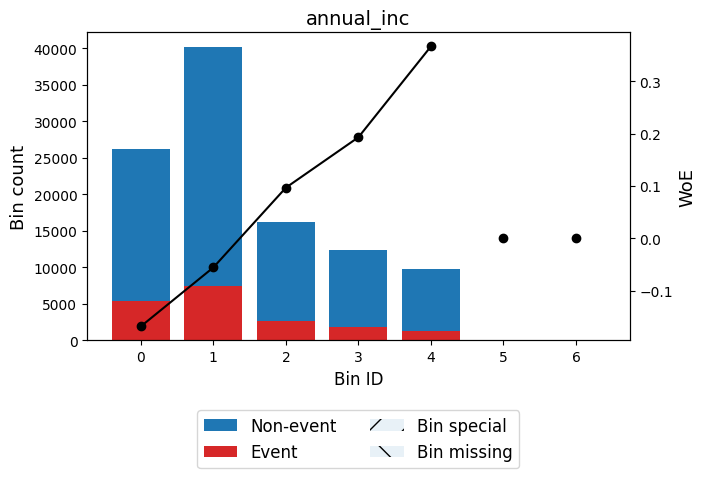

✅ Total IV for avail_ratio: 0.0271
╒══════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, -96.85)   │    5422 │             0.2438 │ -0.3942801215353744  │ 0.00907543 │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [-96.85, -91.15) │   10420 │             0.2063 │ -0.17895468692011351 │ 0.00336882 │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [-91.15, -62.35) │   36159 │             0.19   │ -0.07625313404714573 │ 0.00205549 │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [-62.35, -36.15) │   31788 │             0.1667 │ 0.08331655861795828  │ 0.00204939 │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼───────────

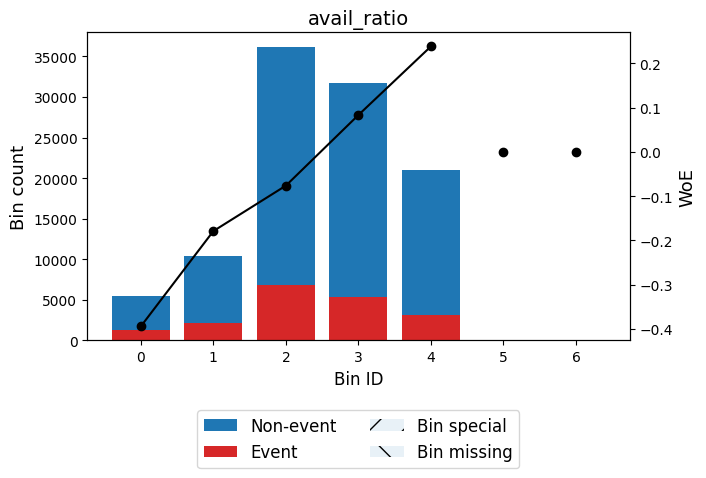

✅ Total IV for avg_cur_bal: 0.0347
╒══════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 7248.50)      │   48575 │             0.2006 │ -0.14329738859067453  │ 0.00995894  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [7248.50, 13811.50)  │   22803 │             0.1807 │ -0.014360497699876573 │ 4.5077e-05  │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [13811.50, 20170.00) │   11389 │             0.1654 │ 0.092299445970079     │ 0.000898482 │
├──────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [20170.00, 41154.50) │   16787 │             0.1423 │ 0.27009308588729675   │ 0.0106917   │
├──────────────────────┼─

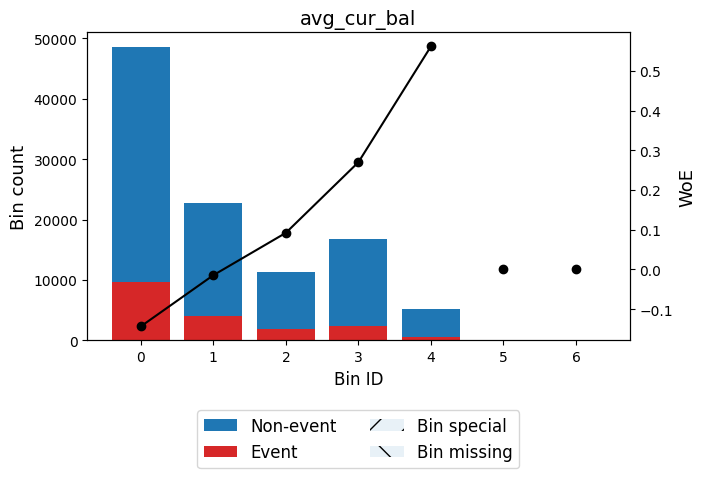

✅ Total IV for bc_open_to_buy: 0.0454
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 205.50)       │    6865 │             0.235  │ -0.3456081965186639  │ 0.00870457 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [205.50, 4606.50)    │   44276 │             0.1995 │ -0.13654885716582554 │ 0.00822536 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [4606.50, 14251.50)  │   33576 │             0.1679 │ 0.07476340597623987  │ 0.00174791 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [14251.50, 26808.00) │   11357 │             0.1463 │ 0.2381722448796586   │ 0.00568499 │
├──────────────────────┼─────────┼────────

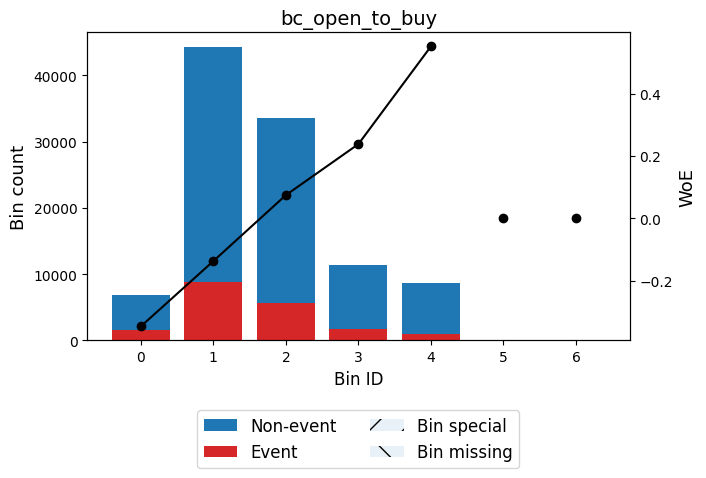

✅ Total IV for bc_open_to_buy/annual_inc: 0.0244
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.00) │    5353 │             0.2341 │ -0.3406750560198113  │ 0.00658547  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.00, 0.04) │   33719 │             0.1963 │ -0.11671989692924267 │ 0.00454865  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.04, 0.18) │   41251 │             0.1748 │ 0.02563926691315177  │ 0.000256614 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.18, 0.42) │   17056 │             0.1566 │ 0.15761170905954547  │ 0.00384024  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.42, inf)  │

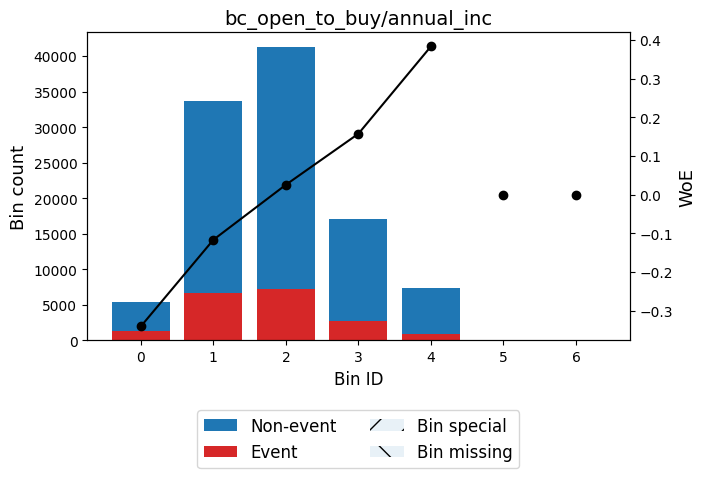

✅ Total IV for bc_open_to_buy/total_rev_hi_lim: 0.0394
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.01) │    6277 │             0.241  │ -0.37912813712930715 │ 0.00967199 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.01, 0.19) │   41588 │             0.2001 │ -0.14048811000854844 │ 0.00818824 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.19, 0.44) │   35951 │             0.1669 │ 0.08188195780808338  │ 0.0022397  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.44, 0.71) │   15740 │             0.1436 │ 0.25920437164415766  │ 0.00926657 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.71, inf)  │    5

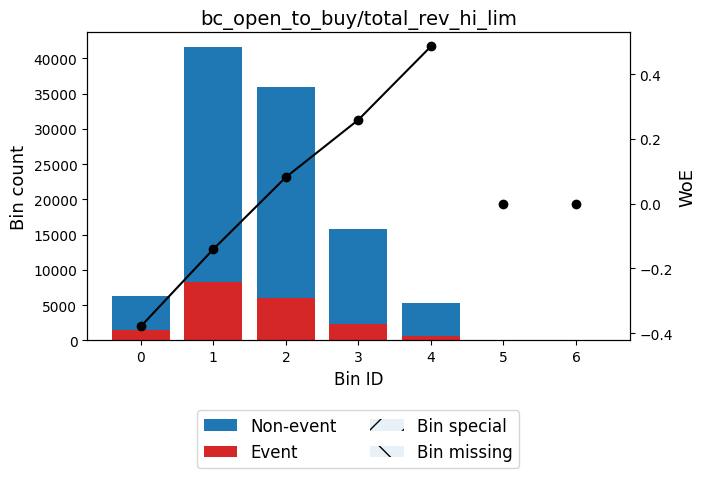

✅ Total IV for bc_util: 0.0271
╒════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │         IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 37.15)  │   21015 │             0.1462 │ 0.23836869617260215  │ 0.0105362  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [37.15, 63.35) │   31788 │             0.1667 │ 0.08331655861795828  │ 0.00204939 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [63.35, 92.15) │   36159 │             0.19   │ -0.07625313404714573 │ 0.00205549 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [92.15, 97.85) │   10420 │             0.2063 │ -0.17895468692011351 │ 0.00336882 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [97.85, inf)   │    5

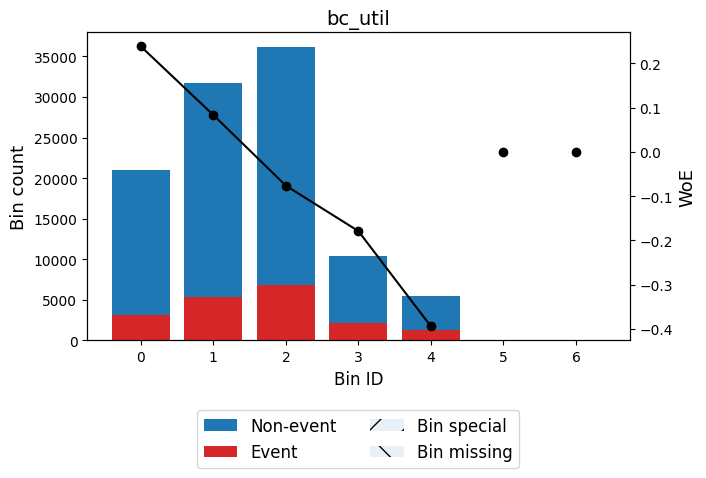

✅ Total IV for dti: 0.0927
╒════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │         IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 12.78)  │   29974 │             0.1266 │ 0.4054535351527895   │ 0.0410986  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [12.78, 18.57) │   26632 │             0.1634 │ 0.10720723980058411  │ 0.00282071 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [18.57, 26.05) │   28396 │             0.1955 │ -0.11159107621802877 │ 0.00349571 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [26.05, 32.85) │   14516 │             0.2413 │ -0.38028839683951254 │ 0.0225118  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [32.85, inf)   │    5286 

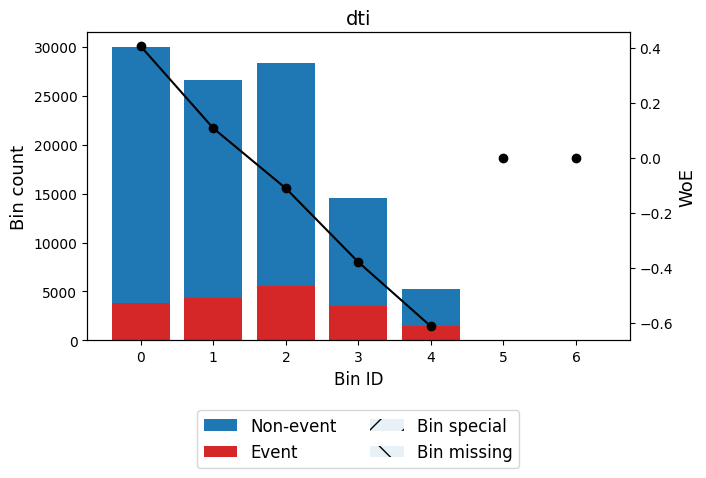

✅ Total IV for dti/fico_ratio: 0.1081
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.02) │   32170 │             0.1247 │ 0.42298993615522185  │ 0.0477223  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.02, 0.03) │   25414 │             0.1637 │ 0.10490868486118954  │ 0.00257946 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.03, 0.04) │   29055 │             0.1982 │ -0.12838694908896175 │ 0.00475955 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.04, 0.05) │   12661 │             0.2478 │ -0.41599708291507365 │ 0.0237389  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.05, inf)  │    5504 │            

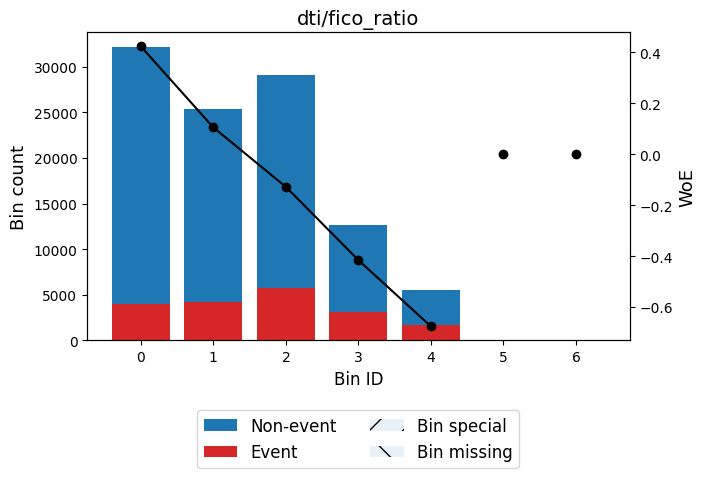

✅ Total IV for dti_x_inq: 0.0577
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 15.48)  │   72279 │             0.1572 │ 0.15332534581263357  │ 0.0154227   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [15.48, 23.56) │   11220 │             0.1881 │ -0.06402018691965261 │ 0.000447845 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [23.56, 32.05) │    8543 │             0.2209 │ -0.26559091668364765 │ 0.00624648  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [32.05, 51.88) │    7360 │             0.2501 │ -0.42823357160971853 │ 0.0146748   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [51.88, 

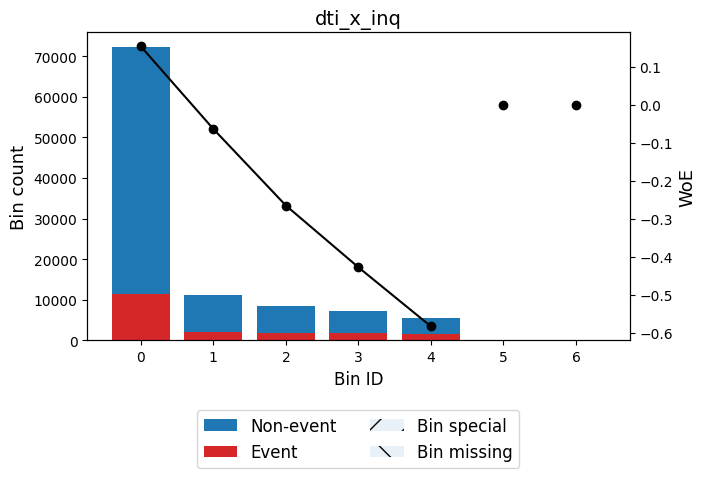

✅ Total IV for dti_x_revol_util: 0.0801
╒════════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin                │   Count │   Default Rate (%) │ WOE                  │         IV │
╞════════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 451.05)     │   24927 │             0.1261 │ 0.40951262068311745  │ 0.0348181  │
├────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [451.05, 902.94)   │   28578 │             0.1592 │ 0.1377098551590079   │ 0.00494444 │
├────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [902.94, 1314.82)  │   21007 │             0.1892 │ -0.0710521743312591  │ 0.00103511 │
├────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1314.82, 1965.88) │   19946 │             0.2182 │ -0.2501645207835541  │ 0.012879   │
├────────────────────┼─────────┼────────────────────┼───────

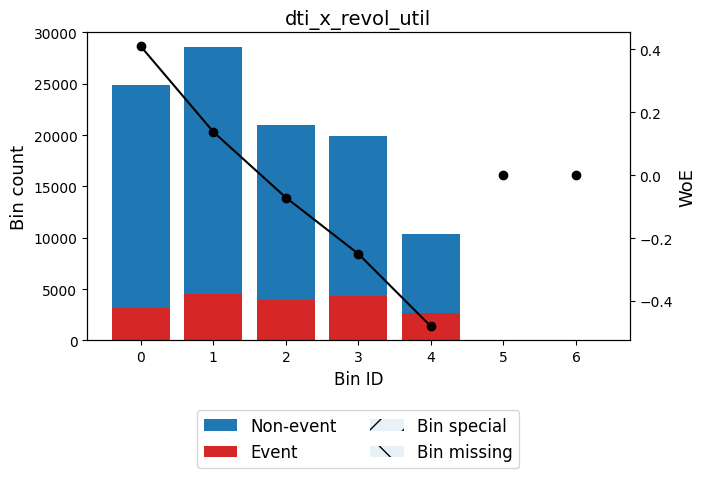

✅ Total IV for dti_x_term: 0.2203
╒════════════════════╤═════════╤════════════════════╤═════════════════════╤════════════╕
│ Bin                │   Count │   Default Rate (%) │ WOE                 │         IV │
╞════════════════════╪═════════╪════════════════════╪═════════════════════╪════════════╡
│ (-inf, 549.90)     │   35842 │             0.1158 │ 0.5071071411427197  │ 0.0742569  │
├────────────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [549.90, 937.62)   │   38412 │             0.1609 │ 0.12513449830127987 │ 0.00551026 │
├────────────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [937.62, 1220.58)  │   16835 │             0.2251 │ -0.2897419124787015 │ 0.0147565  │
├────────────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [1220.58, 1460.10) │    6594 │             0.284  │ -0.6016421357139438 │ 0.0272228  │
├────────────────────┼─────────┼────────────────────┼─────────────────────┼─

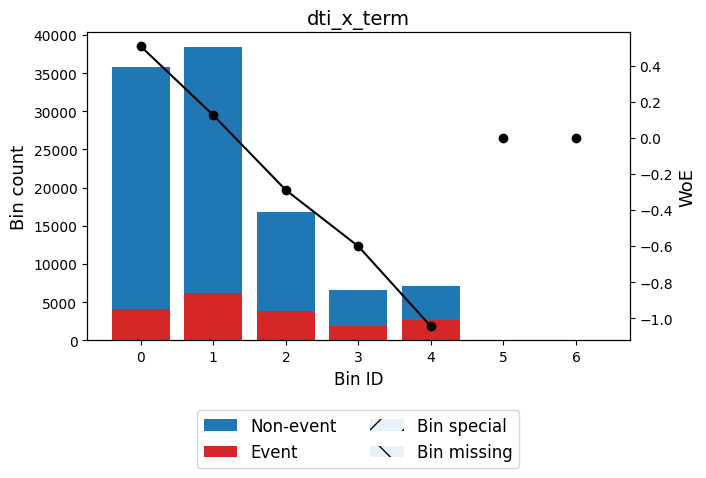

✅ Total IV for fico_score: 0.1153
╒══════════════════╤═════════╤════════════════════╤═════════════════════╤════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                 │         IV │
╞══════════════════╪═════════╪════════════════════╪═════════════════════╪════════════╡
│ (-inf, 679.50)   │   36036 │             0.2264 │ -0.2974409901774262 │ 0.0333644  │
├──────────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [679.50, 699.50) │   28618 │             0.1896 │ -0.073288744236218  │ 0.00150138 │
├──────────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [699.50, 719.50) │   19444 │             0.1542 │ 0.17601553305215556 │ 0.00542686 │
├──────────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [719.50, 739.50) │   10135 │             0.126  │ 0.4106860746344623  │ 0.0142322  │
├──────────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [739.50

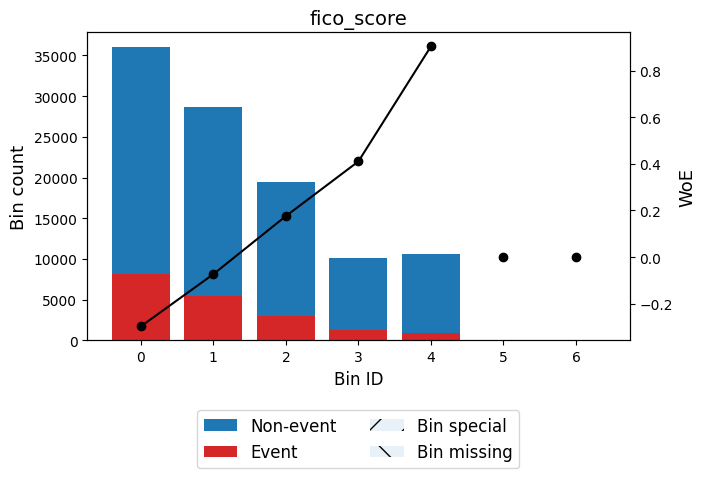

✅ Total IV for fico_score/inq_last_6mths: 0.0536
╒══════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 112.42)   │   59430 │             0.1589 │ 0.140367891525212    │ 0.0106737  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [112.42, 344.75) │   11788 │             0.2489 │ -0.4216186992269826  │ 0.0227401  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [344.75, 684.50) │   17811 │             0.216  │ -0.23726391265954438 │ 0.0103045  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [684.50, 704.50) │    7126 │             0.1896 │ -0.07342815638634659 │ 0.00037529 │
├──────────────────┼─────────┼────────────────────┼────────────────────

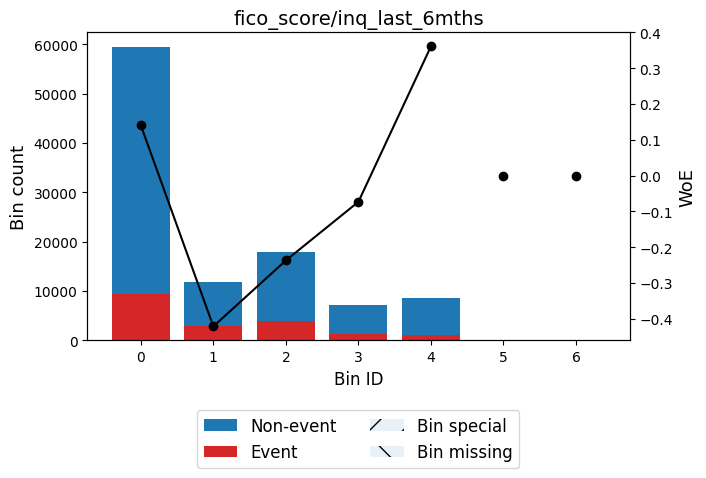

✅ Total IV for fico_score/inq_last_6mths_invalid: 0.0233
╒══════════════╤═════════╤════════════════════╤═════════════════════╤═══════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                 │        IV │
╞══════════════╪═════════╪════════════════════╪═════════════════════╪═══════════╡
│ (-inf, 0.50) │   45407 │             0.2043 │ -0.1662650630220437 │ 0.0126225 │
├──────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ [0.50, inf)  │   59397 │             0.1589 │ 0.1402112562715041  │ 0.0106445 │
├──────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ Special      │       0 │             0      │ 0.0                 │ 0         │
├──────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ Missing      │       0 │             0      │ 0.0                 │ 0         │
├──────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│              │  104804 │             0.

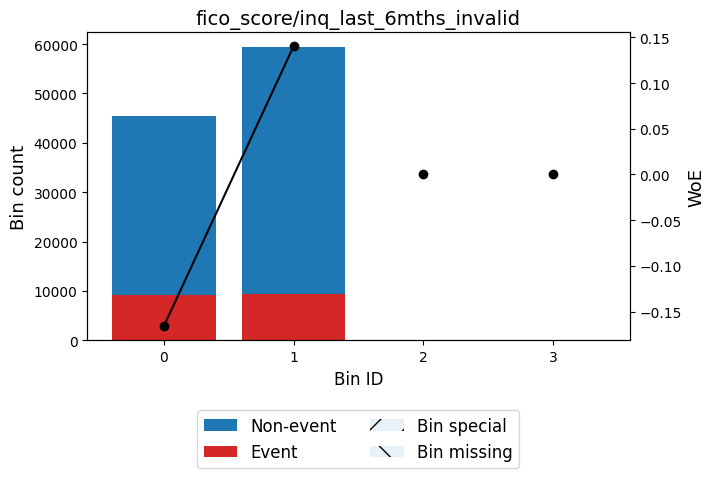

✅ Total IV for fico_score/int_rate: 0.4354
╒═════════════════╤═════════╤════════════════════╤══════════════════════╤═══════════╕
│ Bin             │   Count │   Default Rate (%) │ WOE                  │        IV │
╞═════════════════╪═════════╪════════════════════╪══════════════════════╪═══════════╡
│ (-inf, 40.76)   │   21094 │             0.3294 │ -0.8151433035812025  │ 0.168699  │
├─────────────────┼─────────┼────────────────────┼──────────────────────┼───────────┤
│ [40.76, 57.85)  │   37993 │             0.1966 │ -0.11836921576368487 │ 0.0052738 │
├─────────────────┼─────────┼────────────────────┼──────────────────────┼───────────┤
│ [57.85, 76.01)  │   21558 │             0.1273 │ 0.3986456914513574   │ 0.0286409 │
├─────────────────┼─────────┼────────────────────┼──────────────────────┼───────────┤
│ [76.01, 104.87) │   16670 │             0.0781 │ 0.942264527863736    │ 0.102648  │
├─────────────────┼─────────┼────────────────────┼──────────────────────┼───────────┤
│ [104.87, 

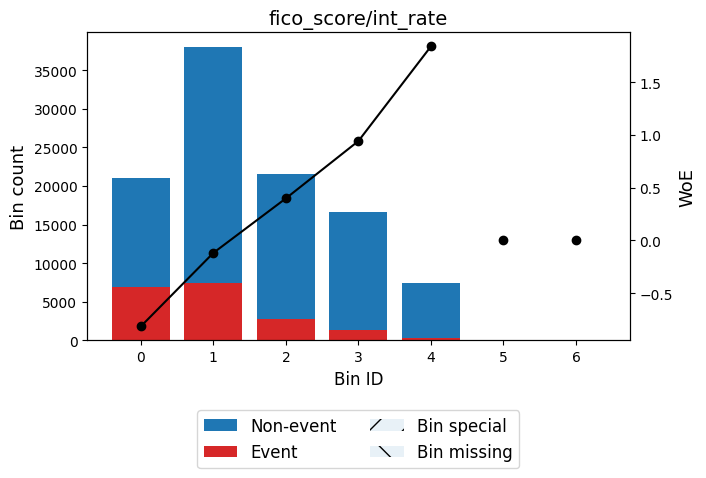

✅ Total IV for funded_amnt: 0.0440
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 9012.50)      │   32478 │             0.1392 │ 0.29555611794296244  │ 0.0245585  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [9012.50, 10012.50)  │    9912 │             0.1616 │ 0.12008540640504739  │ 0.00131164 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [10012.50, 16037.50) │   26464 │             0.1883 │ -0.0652318656606301  │ 0.00109709 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [16037.50, 28012.50) │   27106 │             0.2072 │ -0.18437789106601365 │ 0.00931823 │
├──────────────────────┼─────────┼───────────

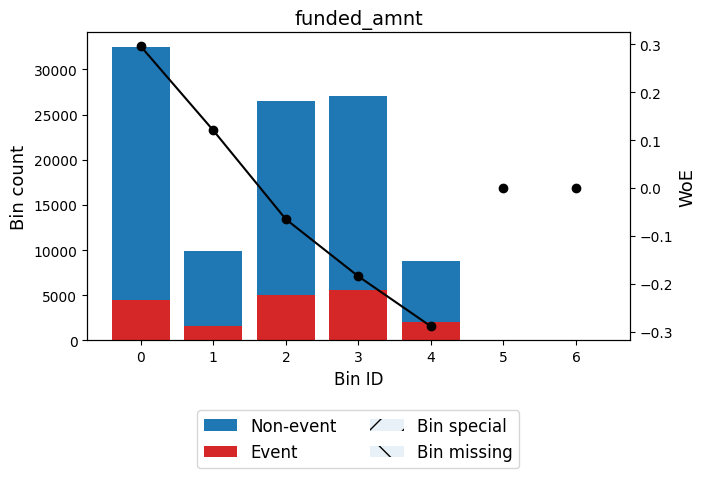

✅ Total IV for grade_numeric: 0.4525
╒══════════════╤═════════╤════════════════════╤═════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                 │         IV │
╞══════════════╪═════════╪════════════════════╪═════════════════════╪════════════╡
│ (-inf, 1.50) │   18877 │             0.0546 │ 1.325128834626995   │ 0.201688   │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [1.50, 2.50) │   31160 │             0.1206 │ 0.4609103760436568  │ 0.0541789  │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [2.50, 3.50) │   28917 │             0.2002 │ -0.1412528792558112 │ 0.00575698 │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [3.50, 4.50) │   15265 │             0.2702 │ -0.5326451391036483 │ 0.0484834  │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [4.50, inf)  │   10585 │             0.3789 │ -1

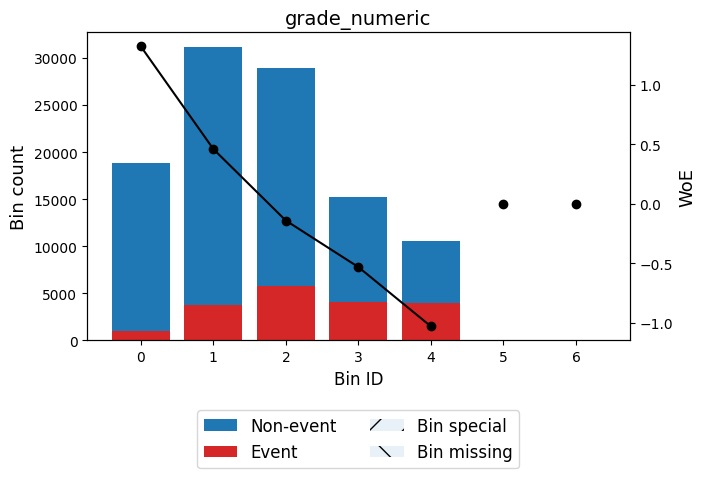

✅ Total IV for inq_last6mths_x_tl_op_past_12m: 0.0457
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 1.50) │   69035 │             0.159  │ 0.1397356458191068    │ 0.0122899   │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 2.50) │   10171 │             0.1784 │ 0.0007730221613631016 │ 5.79778e-08 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 4.50) │   12222 │             0.2105 │ -0.2043396040775023   │ 0.00519232  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [4.50, 8.50) │    7985 │             0.2361 │ -0.3517604035368507   │ 0.0105073   │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤


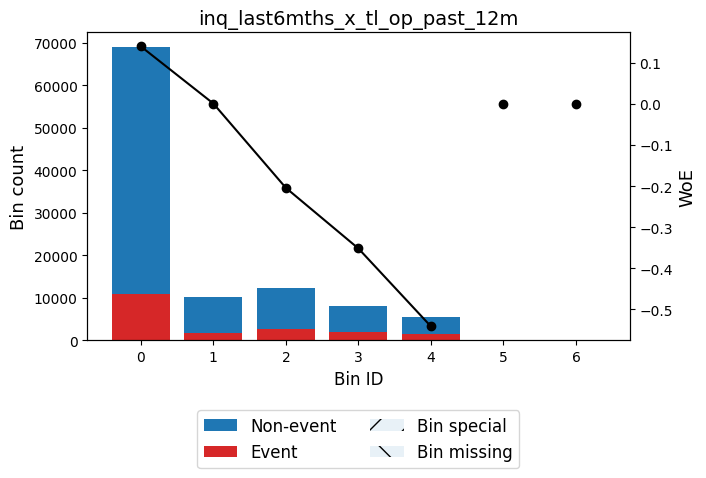

✅ Total IV for inq_last_6mths: 0.0293
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.50) │   59397 │             0.1589 │ 0.1402112562715041   │ 0.0106445  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.50, 1.50) │   28829 │             0.1909 │ -0.08184613362490567 │ 0.00189138 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1.50, 2.50) │   10780 │             0.2191 │ -0.2552578012429336  │ 0.00725807 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [2.50, inf)  │    5798 │             0.2432 │ -0.3908375157932351  │ 0.00952657 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Special      │       0 │            

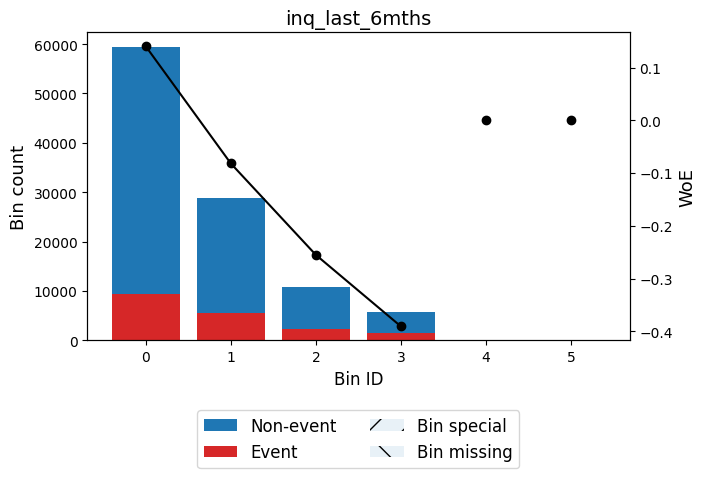

✅ Total IV for installment: 0.0320
╒══════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 193.38)   │   16132 │             0.131  │ 0.3656389768139452   │ 0.018233    │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [193.38, 251.58) │    9826 │             0.1502 │ 0.20680445886834153  │ 0.00374731  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [251.58, 337.48) │   18833 │             0.1732 │ 0.03731917912488525  │ 0.000247273 │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [337.48, 877.63) │   52881 │             0.1962 │ -0.11575526149515092 │ 0.00701403  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼─

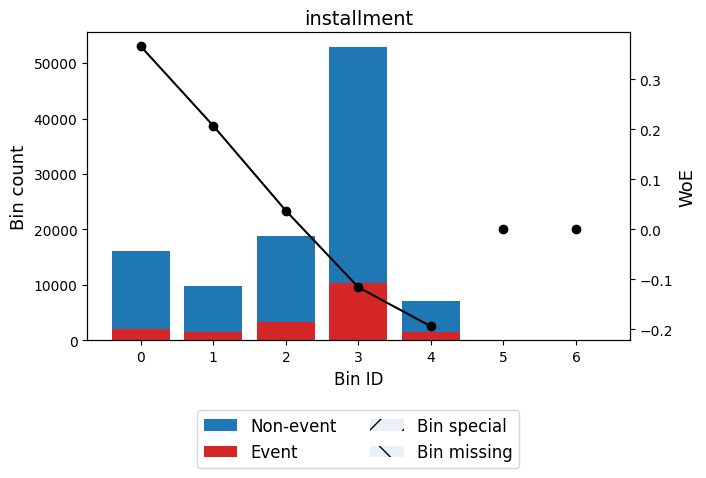

✅ Total IV for installment/annual_inc/12: 0.0921
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.03) │   10601 │             0.1092 │ 0.5724579933139866   │ 0.0273685  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.03, 0.05) │   18263 │             0.1337 │ 0.34287223137223966  │ 0.0182913  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.05, 0.08) │   26479 │             0.1613 │ 0.12220409901808682  │ 0.00362612 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.08, 0.10) │   21761 │             0.1933 │ -0.09758931425460005 │ 0.00203982 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.10, inf)  │   27700 │ 

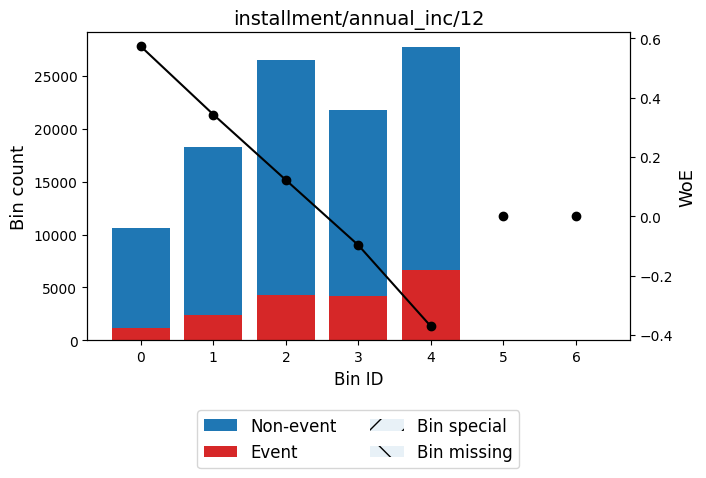

✅ Total IV for installment/annual_inc/12_x_term: 0.2169
╒══════════════╤═════════╤════════════════════╤═════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                 │         IV │
╞══════════════╪═════════╪════════════════════╪═════════════════════╪════════════╡
│ (-inf, 1.82) │   25704 │             0.1103 │ 0.5612225909157016  │ 0.0640269  │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [1.82, 3.40) │   35100 │             0.1439 │ 0.2573530638778061  │ 0.0203828  │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [3.40, 4.56) │   18167 │             0.1894 │ -0.0722688416849604 │ 0.00092645 │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [4.56, 6.85) │   20021 │             0.2563 │ -0.460732079080052  │ 0.0466359  │
├──────────────┼─────────┼────────────────────┼─────────────────────┼────────────┤
│ [6.85, inf)  │    5812 │     

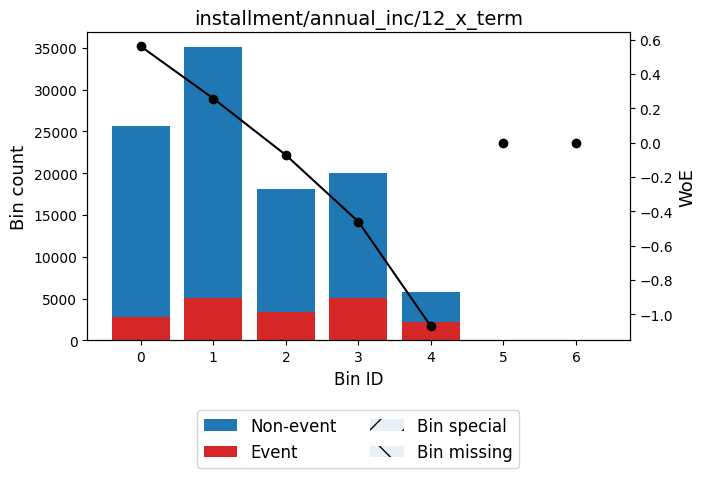

✅ Total IV for int_rate: 0.4326
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 8.12)   │   16382 │             0.0508 │ 1.4005966108748313   │ 0.190623    │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [8.12, 11.47)  │   23054 │             0.1106 │ 0.5584052760752933   │ 0.0569058   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [11.47, 14.44) │   29390 │             0.1721 │ 0.04493867784232952  │ 0.000558164 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [14.44, 18.82) │   24231 │             0.2461 │ -0.40654416863435827 │ 0.0432733   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [18.82, i

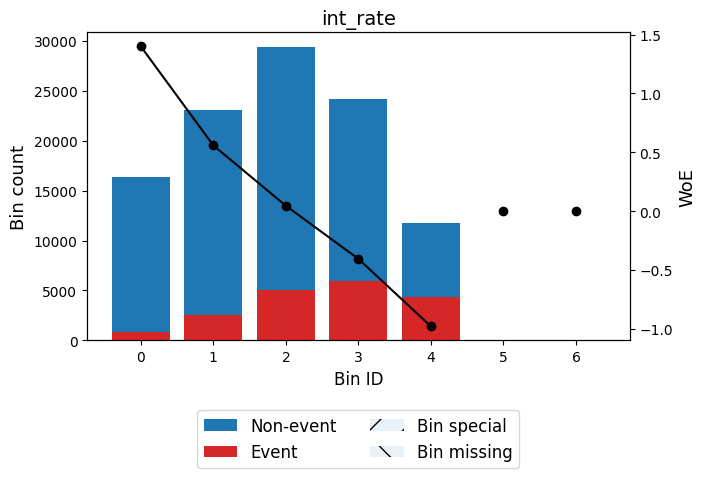

✅ Total IV for loan_amnt: 0.0439
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 9012.50)      │   32459 │             0.1393 │ 0.2953902145473486   │ 0.024518   │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [9012.50, 10012.50)  │    9914 │             0.1616 │ 0.12032605133461671  │ 0.00131706 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [10012.50, 16037.50) │   26433 │             0.1884 │ -0.06593414678660947 │ 0.00111978 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [16037.50, 28012.50) │   27131 │             0.2071 │ -0.1834396789296464  │ 0.00922948 │
├──────────────────────┼─────────┼─────────────

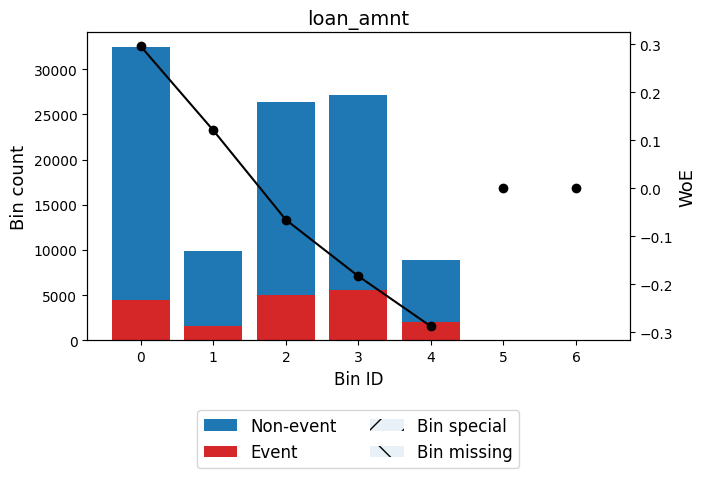

✅ Total IV for loan_amnt/annual_inc: 0.1285
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.10) │   15722 │             0.1127 │ 0.5372493022683433   │ 0.0361844   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.10, 0.17) │   25566 │             0.1366 │ 0.31780445355719444  │ 0.0221852   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.17, 0.26) │   30216 │             0.1715 │ 0.04868956141038705  │ 0.000672825 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.26, 0.33) │   16143 │             0.2231 │ -0.27824992636205104 │ 0.0130049   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.33, inf)  │   17

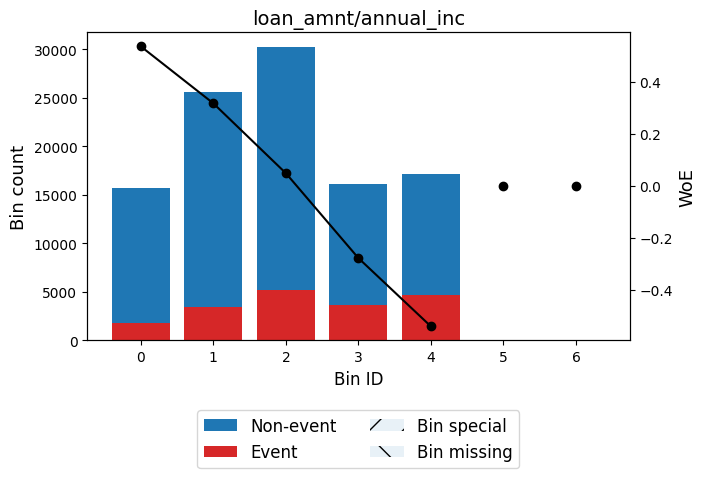

✅ Total IV for loan_amnt/tot_hi_cred_lim: 0.0703
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.03) │    8417 │             0.1103 │ 0.5620374696470245   │ 0.0210212  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.03, 0.06) │   18448 │             0.1311 │ 0.36492399619971194  │ 0.0207742  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.06, 0.11) │   27234 │             0.1682 │ 0.07251608483628624  │ 0.00133478 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.11, 0.23) │   24849 │             0.2006 │ -0.1433947460347318  │ 0.00510167 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.23, inf)  │   25856 │ 

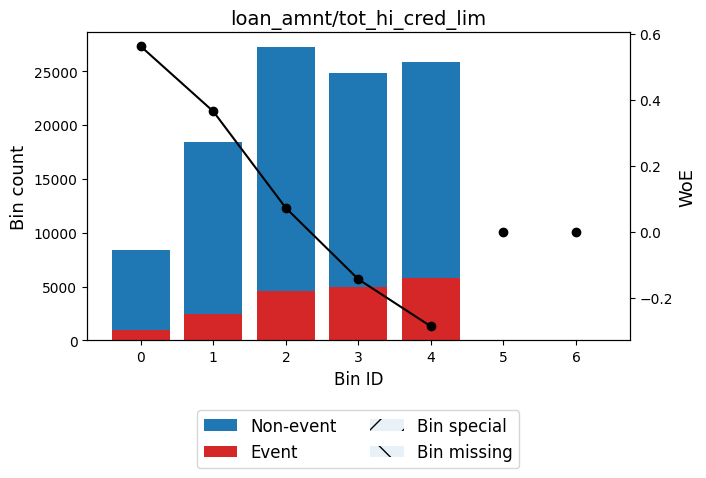

✅ Total IV for mo_sin_rcnt_rev_tl_op: 0.0305
╒════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │         IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 3.50)   │   23737 │             0.2114 │ -0.20936102826881187 │ 0.0106023  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [3.50, 7.50)   │   23749 │             0.1898 │ -0.07493153105479244 │ 0.0013031  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [7.50, 21.50)  │   41073 │             0.1704 │ 0.056645994599805904 │ 0.00123471 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [21.50, 35.50) │    9070 │             0.1471 │ 0.2315814568414194   │ 0.00430184 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [35.50,

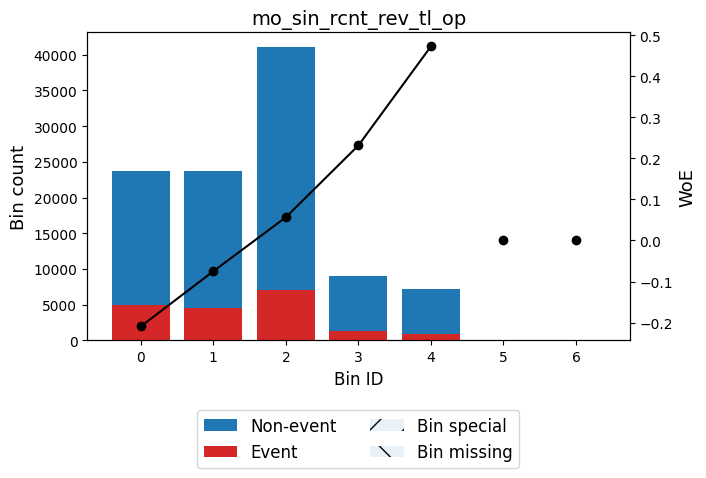

✅ Total IV for mo_sin_rcnt_tl: 0.0377
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 3.50)   │   31665 │             0.2128 │ -0.2179329454495491  │ 0.0153655   │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 4.50)   │    9466 │             0.1918 │ -0.08805198615679921 │ 0.000720191 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [4.50, 11.50)  │   44346 │             0.1703 │ 0.05724142054250536  │ 0.00136101  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [11.50, 20.50) │   13261 │             0.1434 │ 0.26159699597057107  │ 0.00794555  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [20

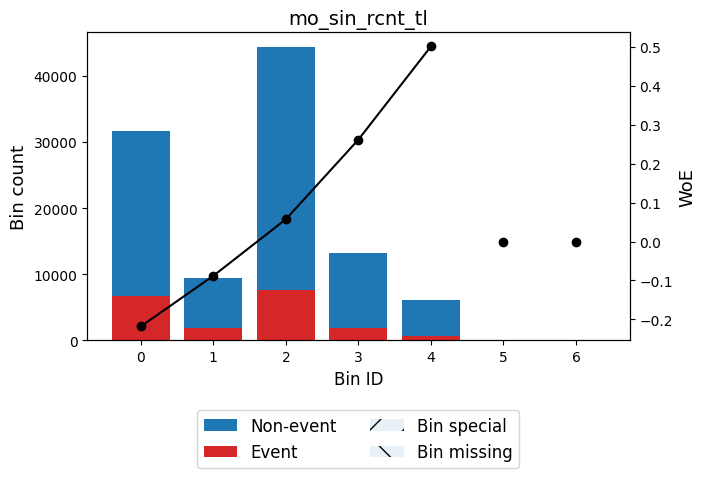

✅ Total IV for mort_acc: 0.0214
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.50) │   39685 │             0.203  │ -0.15830833312752235 │ 0.00997663  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.50, 2.50) │   36235 │             0.173  │ 0.03871102064305232  │ 0.000511676 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [2.50, 3.50) │   10892 │             0.1638 │ 0.10417376022753344  │ 0.00109034  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 5.50) │   12304 │             0.1465 │ 0.23589719268653409  │ 0.00604652  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [5.50, inf)  │    5688 │       

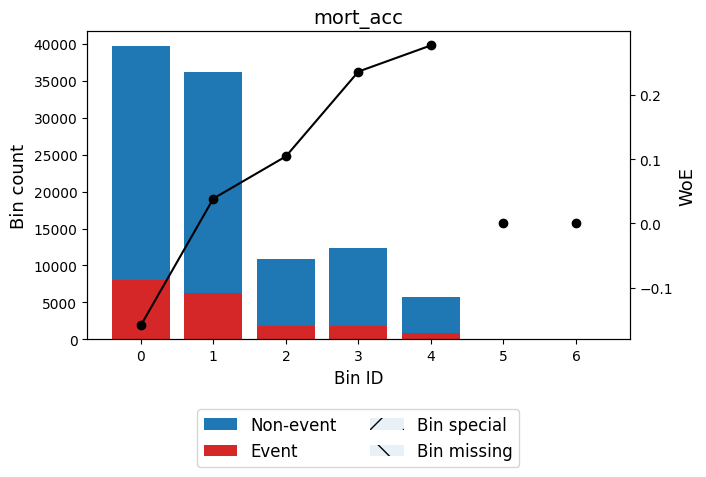

✅ Total IV for mths_since_recent_bc: 0.0277
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 3.50)   │   13533 │             0.2161 │ -0.2373711982265394  │ 0.00783685  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [3.50, 12.50)  │   33181 │             0.1945 │ -0.10533950375587864 │ 0.00363278  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [12.50, 28.50) │   32889 │             0.1723 │ 0.043244238906257504 │ 0.000578718 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [28.50, 56.50) │   14265 │             0.1568 │ 0.15598022880214812  │ 0.00314738  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤

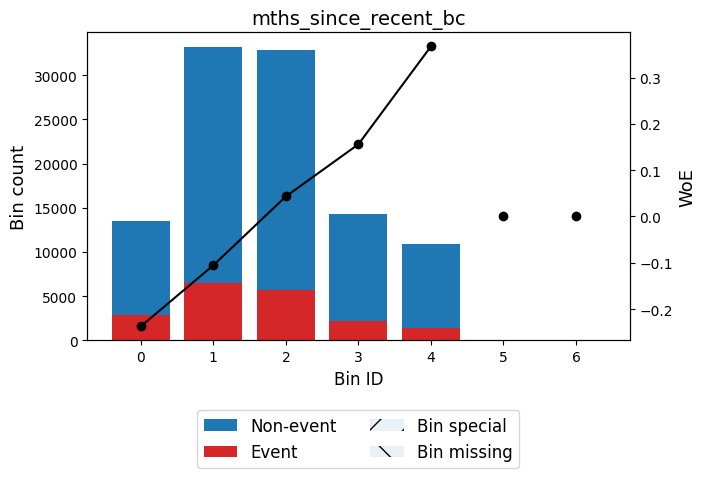

✅ Total IV for mths_since_recent_inq: 0.0268
╒═══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                  │         IV │
╞═══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 1.50)  │   18634 │             0.2156 │ -0.2347888011331789  │ 0.010549   │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1.50, 3.50)  │   15400 │             0.2044 │ -0.16680016693110233 │ 0.0043093  │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [3.50, 4.50)  │    6788 │             0.1924 │ -0.09162038678978734 │ 0.00055978 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [4.50, 14.50) │   52731 │             0.163  │ 0.11025181727874012  │ 0.00590079 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [14.50, inf)  │   

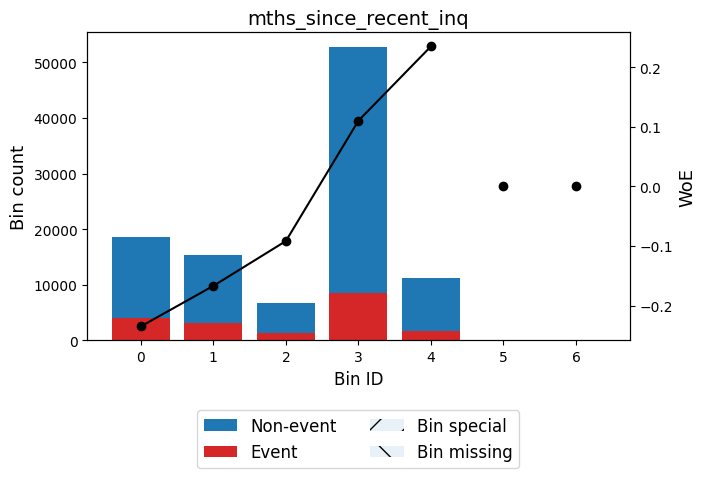

✅ Total IV for num_actv_rev_tl: 0.0345
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 3.50) │   25082 │             0.1499 │ 0.2088862692085265    │ 0.00975225  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [3.50, 5.50) │   36000 │             0.1664 │ 0.08511763975322362   │ 0.00242095  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [5.50, 7.50) │   20923 │             0.1855 │ -0.046849633437704874 │ 0.000444803 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [7.50, 9.50) │   11552 │             0.2014 │ -0.1487840482097058   │ 0.00255761  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [9.50, inf)  

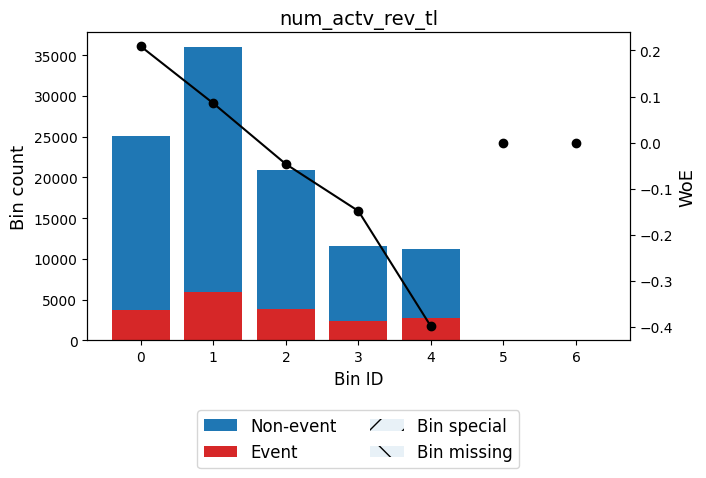

✅ Total IV for num_rev_tl_bal_gt_0: 0.0345
╒═══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                  │         IV │
╞═══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 2.50)  │   11656 │             0.1432 │ 0.2629382487651575   │ 0.00705251 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [2.50, 5.50)  │   49657 │             0.1638 │ 0.10436740591711624  │ 0.00498908 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [5.50, 8.50)  │   27838 │             0.189  │ -0.06927639972640542 │ 0.00130327 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [8.50, 10.50) │    8111 │             0.2127 │ -0.21724031000687472 │ 0.00391006 │
├───────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [10.50, inf)  │    7

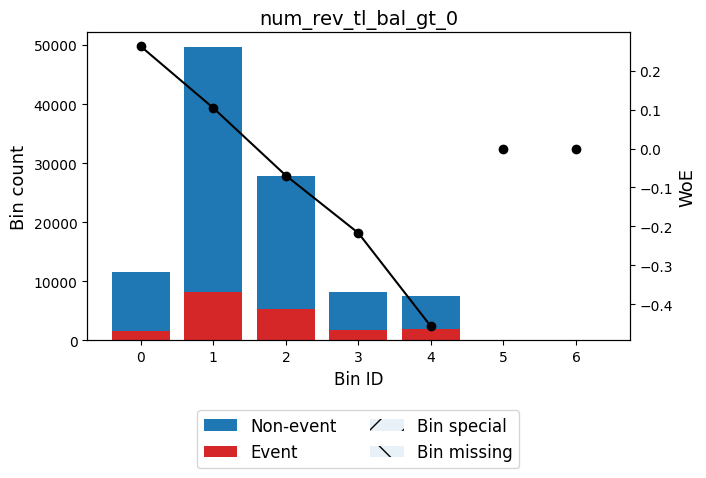

✅ Total IV for num_tl_op_past_12m: 0.0648
╒══════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 0.50) │   16652 │             0.1316 │ 0.36097595620318357  │ 0.0183727  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [0.50, 1.50) │   24475 │             0.1527 │ 0.1872474814661902   │ 0.00770192 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1.50, 2.50) │   29117 │             0.169  │ 0.06630969446027568  │ 0.00119566 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [2.50, 4.50) │   25651 │             0.2164 │ -0.23937963045913624 │ 0.0151159  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [4.50, inf)  │    8909 │        

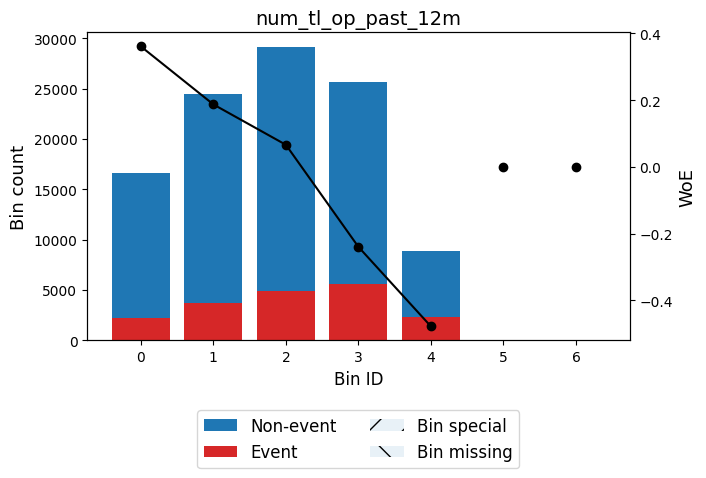

✅ Total IV for percent_bc_gt_75: 0.0297
╒════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 4.90)   │   21299 │             0.1422 │ 0.27090648452867305   │ 0.0136435   │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [4.90, 44.05)  │   31466 │             0.1658 │ 0.08981381059713889   │ 0.00235237  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [44.05, 52.75) │   11977 │             0.1823 │ -0.025051478103823133 │ 7.22978e-05 │
├────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [52.75, 67.70) │   11415 │             0.2005 │ -0.1431089122813609   │ 0.00233403  │
├────────────────┼─────────┼────────────────────┼───────────────────────┼───────

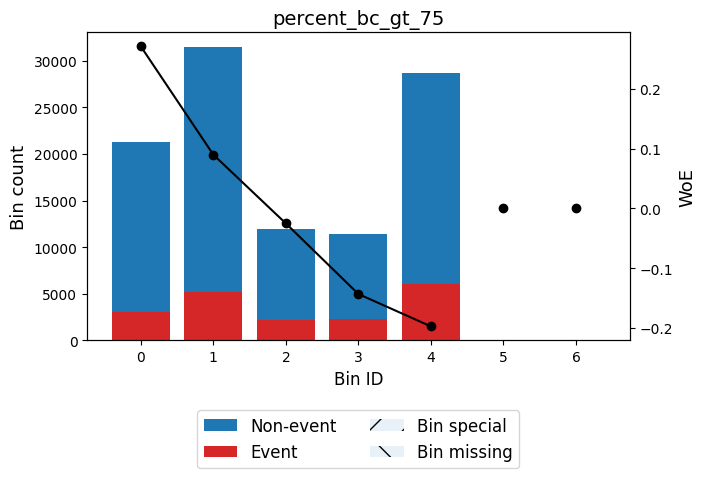

✅ Total IV for revol_util: 0.0209
╒════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 17.85)  │    8679 │             0.131  │ 0.3659728302516243   │ 0.00982613  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [17.85, 33.95) │   15533 │             0.1546 │ 0.17304532858408805  │ 0.00419434  │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [33.95, 48.45) │   20112 │             0.1726 │ 0.04095728477881666  │ 0.000317687 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [48.45, 62.65) │   21576 │             0.1859 │ -0.04925365488626743 │ 0.000507355 │
├────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [62.65,

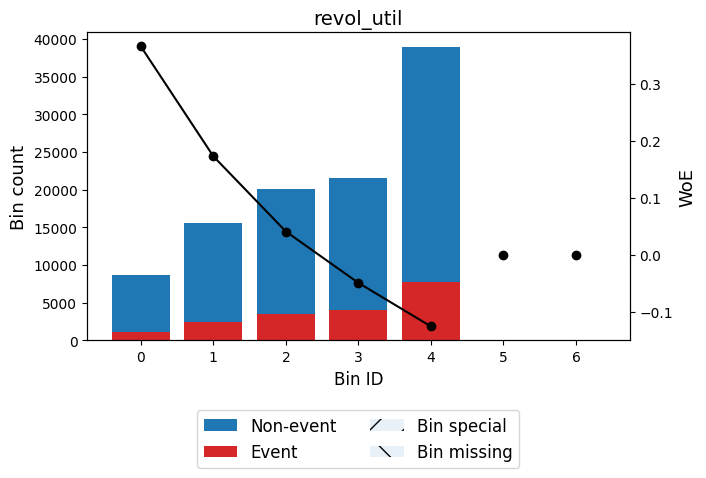

✅ Total IV for revol_util/annual_inc: 0.0455
╒══════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 0.00) │   15371 │             0.1278 │ 0.394672394871008    │ 0.0200431   │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.00, 0.00) │   19597 │             0.1513 │ 0.1979328261561204   │ 0.00686641  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.00, 0.00) │   23719 │             0.1783 │ 0.001526856965558654 │ 5.27354e-07 │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.00, 0.00) │   25971 │             0.196  │ -0.11480386572190282 │ 0.00338734  │
├──────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [0.00, inf)  │   2

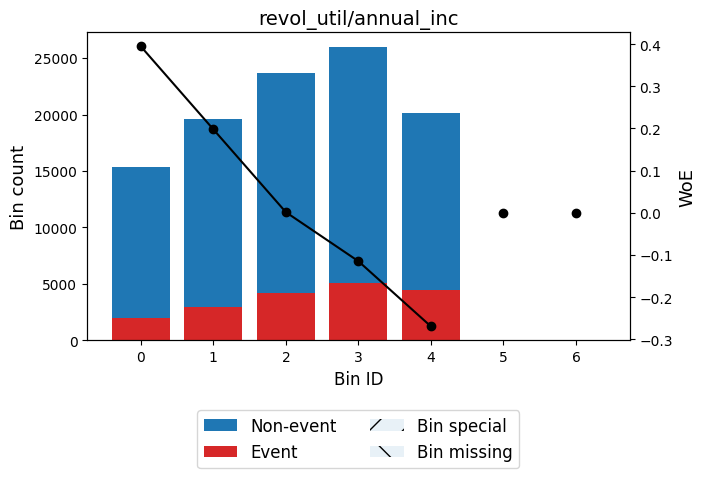

✅ Total IV for term: 0.2166
╒═══════════════╤═════════╤════════════════════╤═════════════════════╤═══════════╕
│ Bin           │   Count │   Default Rate (%) │ WOE                 │        IV │
╞═══════════════╪═════════╪════════════════════╪═════════════════════╪═══════════╡
│ (-inf, 48.00) │   79741 │             0.1378 │ 0.3073841596637701  │ 0.0649606 │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ [48.00, inf)  │   25063 │             0.3082 │ -0.7174954188198741 │ 0.151631  │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ Special       │       0 │             0      │ 0.0                 │ 0         │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│ Missing       │       0 │             0      │ 0.0                 │ 0         │
├───────────────┼─────────┼────────────────────┼─────────────────────┼───────────┤
│               │  104804 │             0.1786 │           

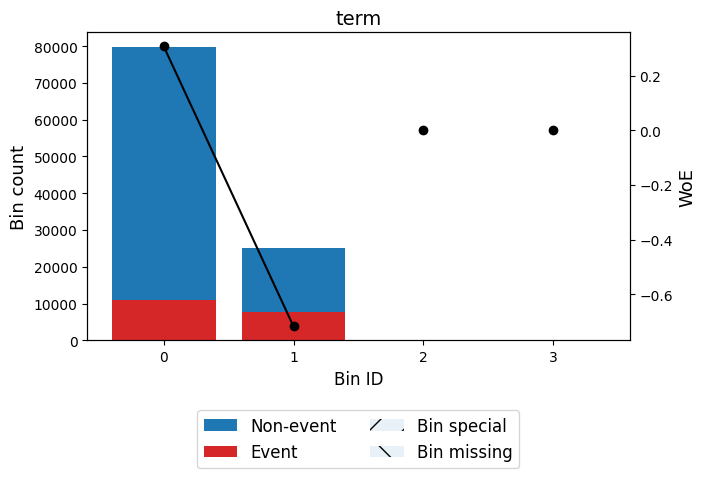

✅ Total IV for term_x_revol_util: 0.1220
╒════════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin                │   Count │   Default Rate (%) │ WOE                  │         IV │
╞════════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 582.60)     │    6828 │             0.1134 │ 0.530781262175795    │ 0.0153727  │
├────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [582.60, 1829.40)  │   34976 │             0.1436 │ 0.25924831731314213  │ 0.020598   │
├────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [1829.40, 2866.80) │   35057 │             0.1716 │ 0.048365354865761434 │ 0.00077034 │
├────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [2866.80, 3598.20) │   16276 │             0.1942 │ -0.10286052243256094 │ 0.00169775 │
├────────────────────┼─────────┼────────────────────┼──────

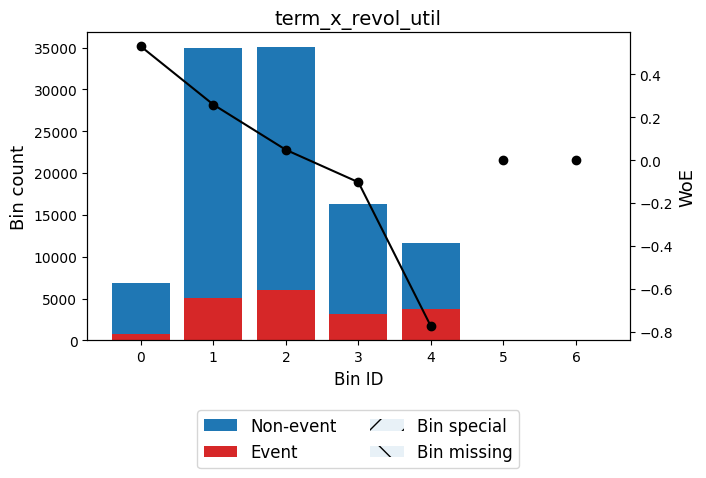

✅ Total IV for tl_op12m_x_inq6m: 0.0457
╒══════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin          │   Count │   Default Rate (%) │ WOE                   │          IV │
╞══════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 1.50) │   69035 │             0.159  │ 0.1397356458191068    │ 0.0122899   │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [1.50, 2.50) │   10171 │             0.1784 │ 0.0007730221613631016 │ 5.79778e-08 │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [2.50, 4.50) │   12222 │             0.2105 │ -0.2043396040775023   │ 0.00519232  │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [4.50, 8.50) │    7985 │             0.2361 │ -0.3517604035368507   │ 0.0105073   │
├──────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [8.50, inf) 

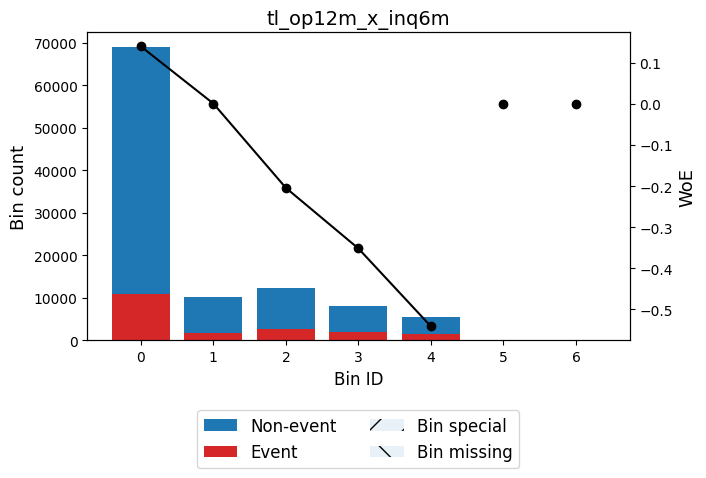

✅ Total IV for tot_cur_bal: 0.0278
╒═══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                   │   Count │   Default Rate (%) │ WOE                  │          IV │
╞═══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 14981.50)      │   10231 │             0.1639 │ 0.10327117314750311  │ 0.0010068   │
├───────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [14981.50, 40964.50)  │   23042 │             0.1977 │ -0.12527910215775506 │ 0.00359053  │
├───────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [40964.50, 76420.50)  │   14718 │             0.2192 │ -0.2557131924021159  │ 0.00994625  │
├───────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [76420.50, 210670.50) │   32477 │             0.1764 │ 0.015009305991190658 │ 6.94738e-05 │
├───────────────────────┼

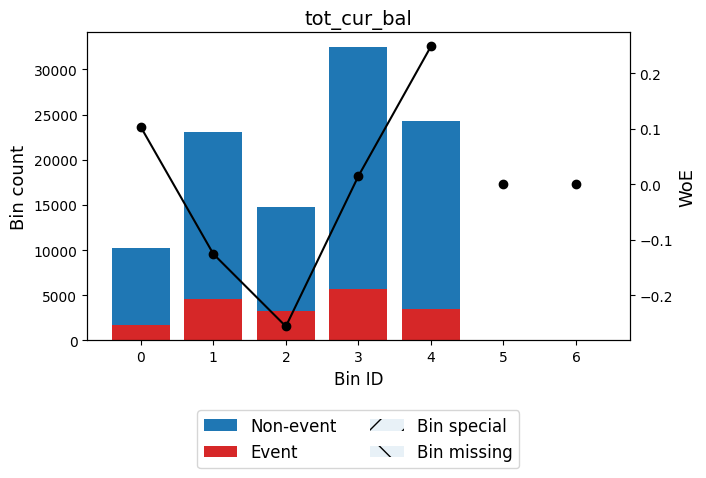

✅ Total IV for tot_hi_cred_lim: 0.0291
╒════════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                    │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 46920.50)       │   22829 │             0.1895 │ -0.07254656927084646 │ 0.00117326  │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [46920.50, 111203.50)  │   26015 │             0.2084 │ -0.1914018828597841  │ 0.00965841  │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [111203.50, 244077.00) │   30562 │             0.1753 │ 0.022290587141250207 │ 0.000143856 │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [244077.00, 481131.50) │   20102 │             0.1475 │ 0.22784591617351047  │ 0.00924064  │
├──────────

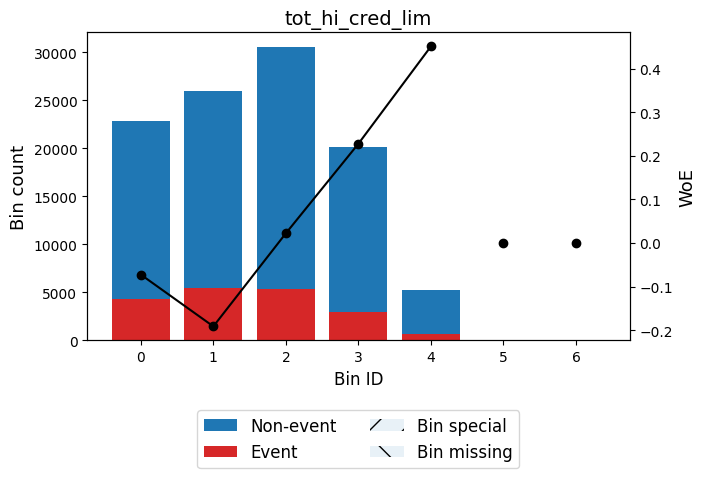

✅ Total IV for total_bc_limit: 0.0285
╒══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                  │   Count │   Default Rate (%) │ WOE                  │          IV │
╞══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 11041.00)     │   38173 │             0.2031 │ -0.1591009322218171  │ 0.00969523  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [11041.00, 14717.50) │   11629 │             0.1869 │ -0.05614644040473871 │ 0.000356125 │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [14717.50, 41223.00) │   42128 │             0.1693 │ 0.06468951266771139  │ 0.00164731  │
├──────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [41223.00, 52309.50) │    5244 │             0.1384 │ 0.3021533283870106   │ 0.00413511  │
├──────────────────────┼────────

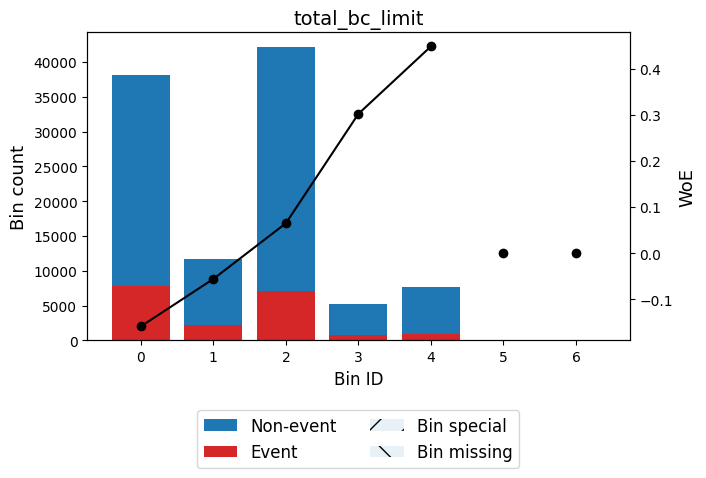

✅ Total IV for verification_status: 0.0523
╒═════════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin                 │   Count │   Default Rate (%) │ WOE                  │         IV │
╞═════════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ ['Not Verified']    │   31272 │             0.131  │ 0.36592108062639706  │ 0.0353959  │
├─────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ ['Source Verified'] │   40129 │             0.1879 │ -0.06269531681687956 │ 0.00153549 │
├─────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ ['Verified']        │   33403 │             0.2118 │ -0.21205578570440453 │ 0.0153188  │
├─────────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ Special             │       0 │             0      │ 0.0                  │ 0          │
├─────────────────────┼─────────┼──────────────

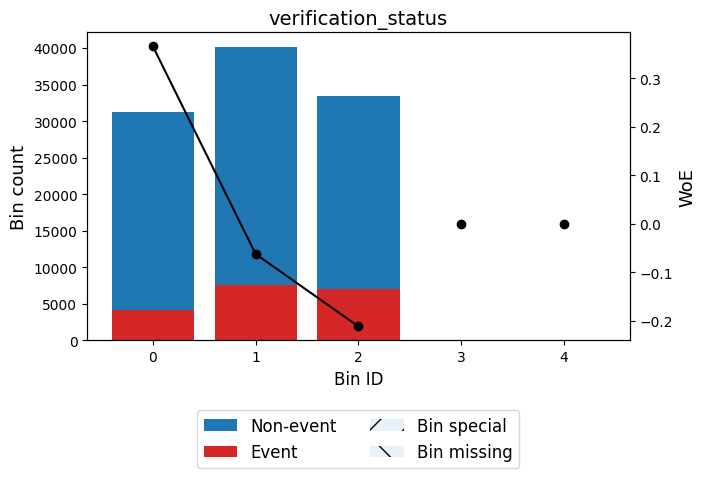

In [18]:
# == Observe WoE & IV of train_pdf1 ==
for feature in sorted(train_pdf1.columns):
    excluded_columns = ["id", "issue_d", "default_status"]
    x, y = train_pdf1[feature], train_pdf1[TARGET_COL]

    if feature in excluded_columns:
        continue

    if train_pdf1[feature].dtype == "object":
        bin_and_classify_feature(
            feature=feature,
            x=x,
            y=y,
            monotonic_trend_type="auto",
            dtype="categorical",
            max_n_bins=5,
        )
    else:
        bin_and_classify_feature(
            feature=feature, x=x, y=y, monotonic_trend_type="auto", max_n_bins=5
        )

✅ Total IV for tot_cur_bal: 0.0278
╒═══════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                   │   Count │   Default Rate (%) │ WOE                  │          IV │
╞═══════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 14981.50)      │   10231 │             0.1639 │ 0.10327117314750311  │ 0.0010068   │
├───────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [14981.50, 40964.50)  │   23042 │             0.1977 │ -0.12527910215775506 │ 0.00359053  │
├───────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [40964.50, 76420.50)  │   14718 │             0.2192 │ -0.2557131924021159  │ 0.00994625  │
├───────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [76420.50, 210670.50) │   32477 │             0.1764 │ 0.015009305991190658 │ 6.94738e-05 │
├───────────────────────┼

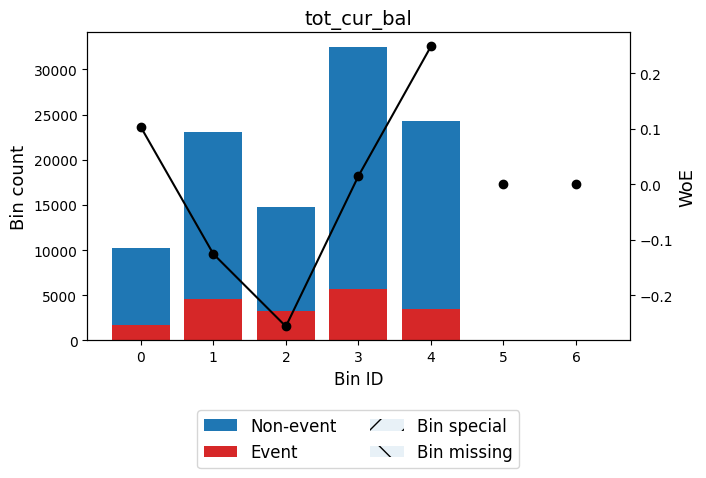

✅ Total IV for tot_hi_cred_lim: 0.0291
╒════════════════════════╤═════════╤════════════════════╤══════════════════════╤═════════════╕
│ Bin                    │   Count │   Default Rate (%) │ WOE                  │          IV │
╞════════════════════════╪═════════╪════════════════════╪══════════════════════╪═════════════╡
│ (-inf, 46920.50)       │   22829 │             0.1895 │ -0.07254656927084646 │ 0.00117326  │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [46920.50, 111203.50)  │   26015 │             0.2084 │ -0.1914018828597841  │ 0.00965841  │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [111203.50, 244077.00) │   30562 │             0.1753 │ 0.022290587141250207 │ 0.000143856 │
├────────────────────────┼─────────┼────────────────────┼──────────────────────┼─────────────┤
│ [244077.00, 481131.50) │   20102 │             0.1475 │ 0.22784591617351047  │ 0.00924064  │
├──────────

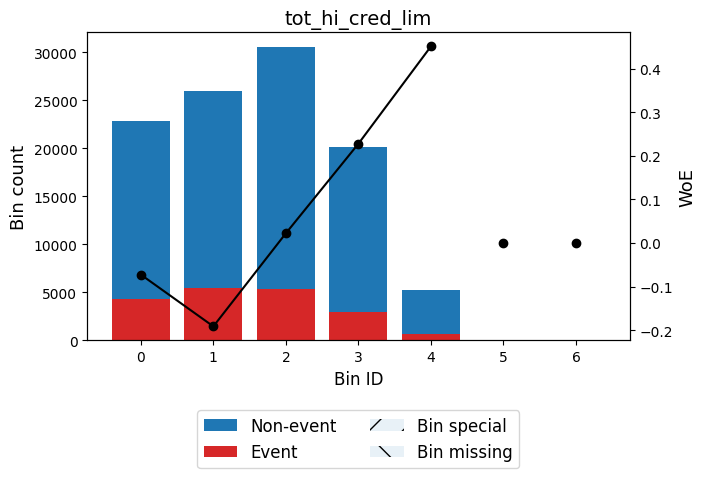

✅ Total IV for fico_score/inq_last_6mths: 0.0536
╒══════════════════╤═════════╤════════════════════╤══════════════════════╤════════════╕
│ Bin              │   Count │   Default Rate (%) │ WOE                  │         IV │
╞══════════════════╪═════════╪════════════════════╪══════════════════════╪════════════╡
│ (-inf, 112.42)   │   59430 │             0.1589 │ 0.140367891525212    │ 0.0106737  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [112.42, 344.75) │   11788 │             0.2489 │ -0.4216186992269826  │ 0.0227401  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [344.75, 684.50) │   17811 │             0.216  │ -0.23726391265954438 │ 0.0103045  │
├──────────────────┼─────────┼────────────────────┼──────────────────────┼────────────┤
│ [684.50, 704.50) │    7126 │             0.1896 │ -0.07342815638634659 │ 0.00037529 │
├──────────────────┼─────────┼────────────────────┼────────────────────

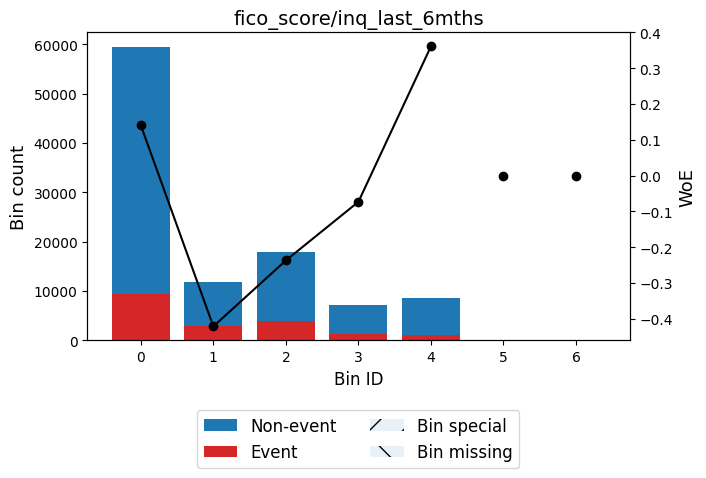

In [19]:
# == Inspect Non Monotonic Features to handle later on ==

non_monotonic_features = ["tot_cur_bal", "tot_hi_cred_lim", "fico_score/inq_last_6mths"]

for feature in non_monotonic_features:
    bin_and_classify_feature(feature, x=train_pdf1[feature], y=train_pdf1[TARGET_COL])

For these non-monotonic features, we shall attempt to enforce a strict monotonic trend constraint on WoE. If IV drops severely, the feature shall be dropped.


✅ Total IV for tot_cur_bal: 0.0220
╒════════════════════════╤═════════╤════════════════════╤════════════════════════╤═════════════╕
│ Bin                    │   Count │   Default Rate (%) │ WOE                    │          IV │
╞════════════════════════╪═════════╪════════════════════╪════════════════════════╪═════════════╡
│ (-inf, 76420.50)       │   47991 │             0.1971 │ -0.12146728102410576   │ 0.0070217   │
├────────────────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤
│ [76420.50, 173972.50)  │   25933 │             0.1791 │ -0.0035069102581857248 │ 3.04659e-06 │
├────────────────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤
│ [173972.50, 210670.50) │    6544 │             0.1656 │ 0.09066953292321722    │ 0.000498451 │
├────────────────────────┼─────────┼────────────────────┼────────────────────────┼─────────────┤
│ [210670.50, 403482.50) │   18437 │             0.1502 │ 0.20658791539596089    │ 0.0070170

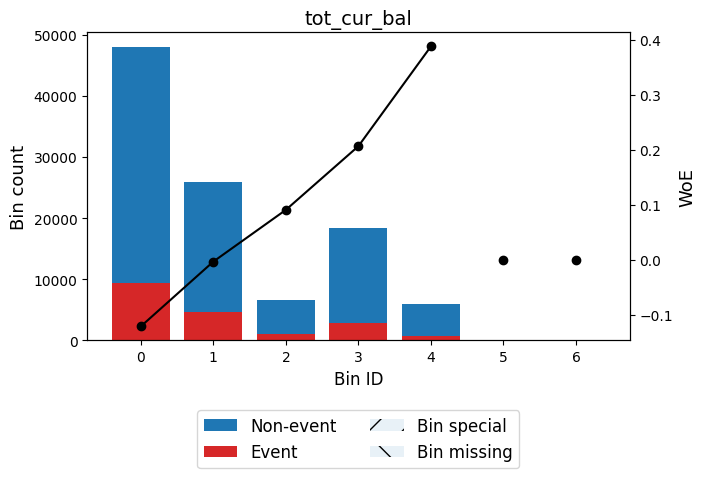

✅ Total IV for tot_hi_cred_lim: 0.0279
╒════════════════════════╤═════════╤════════════════════╤═══════════════════════╤═════════════╕
│ Bin                    │   Count │   Default Rate (%) │ WOE                   │          IV │
╞════════════════════════╪═════════╪════════════════════╪═══════════════════════╪═════════════╡
│ (-inf, 111203.50)      │   48844 │             0.1995 │ -0.13690698344952867  │ 0.00912265  │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [111203.50, 206988.50) │   24489 │             0.1784 │ 0.0013374535269639054 │ 4.17796e-07 │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [206988.50, 244077.00) │    6073 │             0.163  │ 0.10983062050212489   │ 0.000674502 │
├────────────────────────┼─────────┼────────────────────┼───────────────────────┼─────────────┤
│ [244077.00, 481131.50) │   20102 │             0.1475 │ 0.22784591617351047   │ 0.00924064  │
├

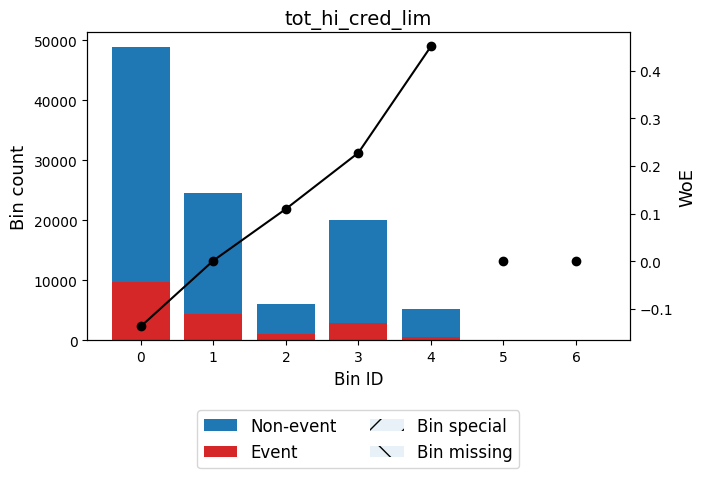

✅ Total IV for fico_score/inq_last_6mths: 0.0103
╒════════════════╤═════════╤════════════════════╤═════════════════════╤═════════════╕
│ Bin            │   Count │   Default Rate (%) │ WOE                 │          IV │
╞════════════════╪═════════╪════════════════════╪═════════════════════╪═════════════╡
│ (-inf, 704.50) │   96155 │             0.1828 │ -0.0285512007335611 │ 0.000754774 │
├────────────────┼─────────┼────────────────────┼─────────────────────┼─────────────┤
│ [704.50, inf)  │    8649 │             0.1316 │ 0.3609749231835935  │ 0.00954267  │
├────────────────┼─────────┼────────────────────┼─────────────────────┼─────────────┤
│ Special        │       0 │             0      │ 0.0                 │ 0           │
├────────────────┼─────────┼────────────────────┼─────────────────────┼─────────────┤
│ Missing        │       0 │             0      │ 0.0                 │ 0           │
├────────────────┼─────────┼────────────────────┼─────────────────────┼─────────────┤
│    

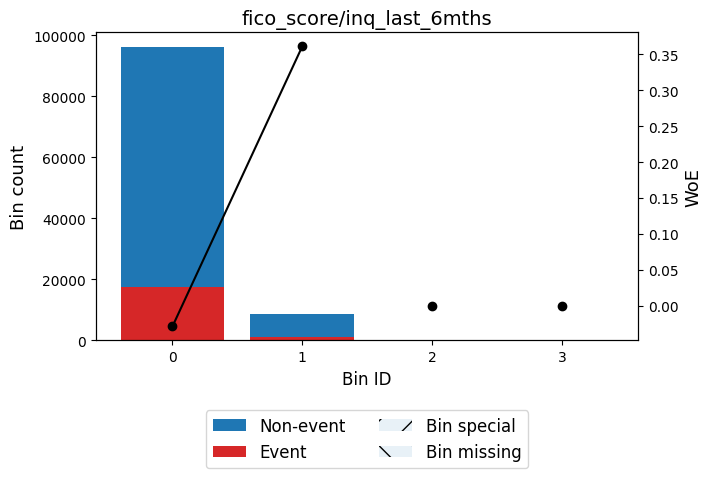

In [20]:
# == Inspect forced WoE monotonicity constraint ==
for non_mono in ["tot_cur_bal", "tot_hi_cred_lim", "fico_score/inq_last_6mths"]:
    bin_and_classify_feature(
        non_mono,
        train_pdf1[non_mono],
        train_pdf1[TARGET_COL],
        monotonic_trend_type="auto_asc_desc",
    )

As seen, enforcing monotonicity constraint caused `fico_score/inq_last_6mths` resulted in a drop of 0.04 in IV. This variable should be dropped, since monotonicity constraint is important for Logistic Regression.


In [21]:
train_pdf1 = train_pdf1.drop("fico_score/inq_last_6mths", axis=1)
train_pdf1 = train_pdf1.drop("fico_score/inq_last_6mths_invalid", axis=1)

assert ("fico_score/inq_last_6mths" not in train_pdf1.columns) and (
    "fico_score/inq_last_6mths_invalid" not in train_pdf1.columns
)

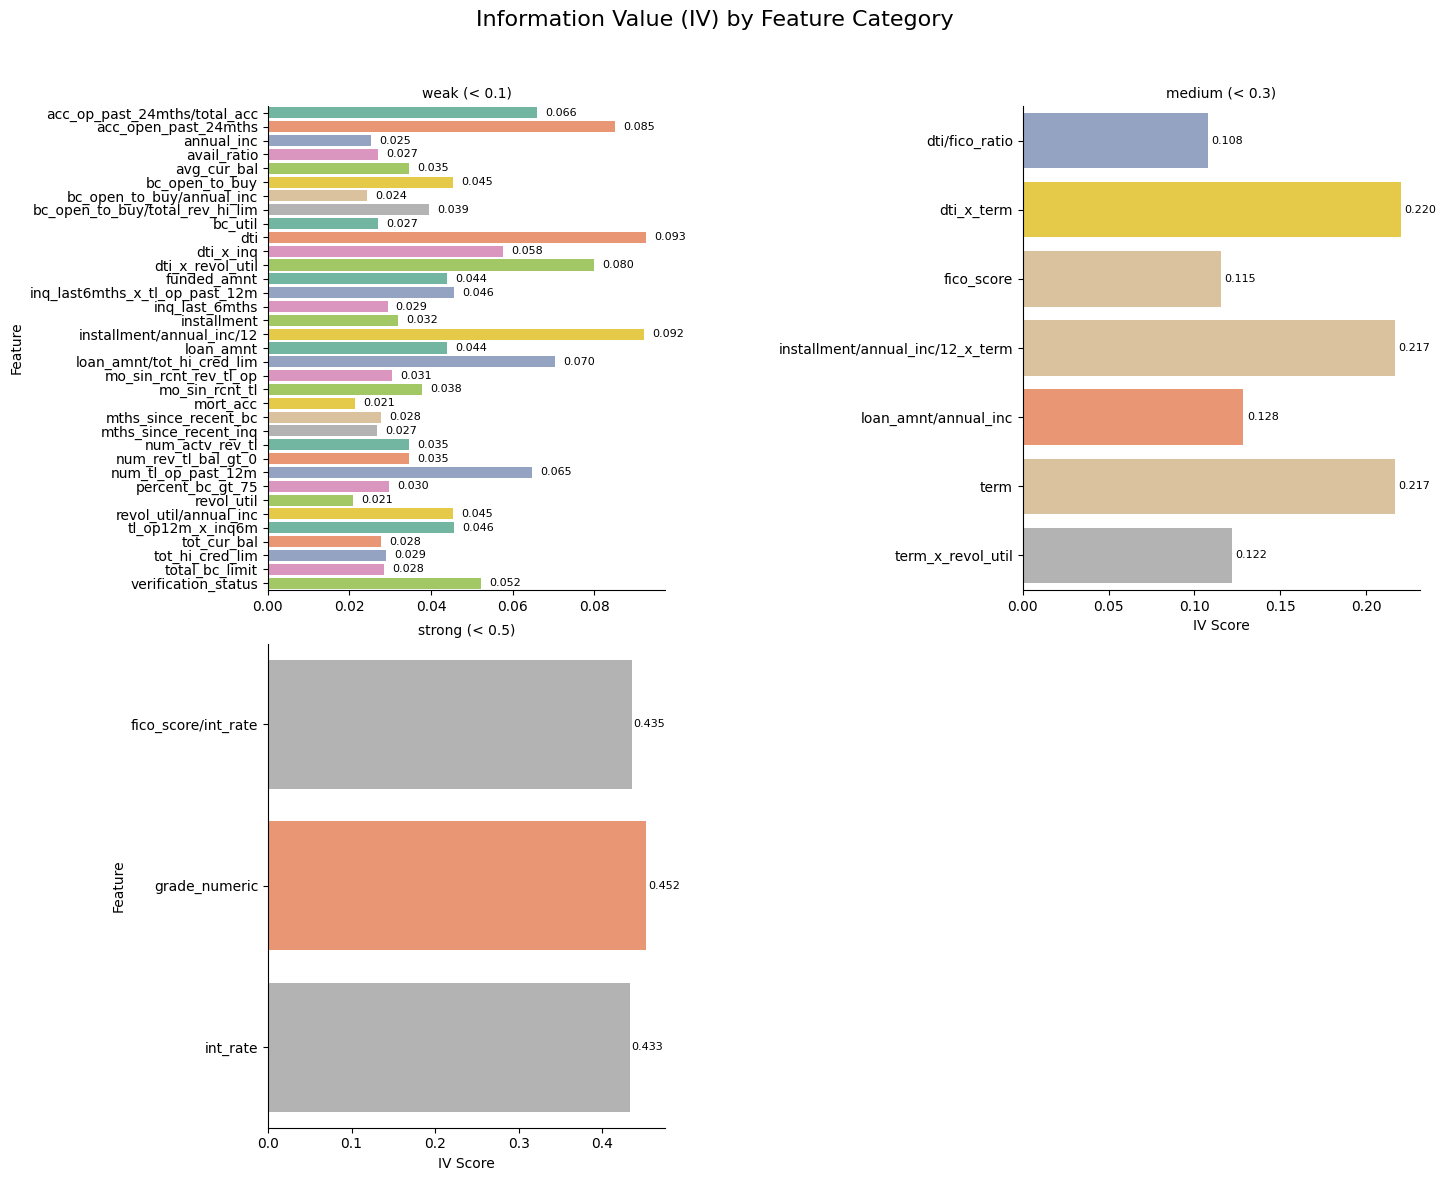

In [22]:
updated_iv_categories = get_updated_iv_categories(updated_iv_categories, train_pdf1)
plot_iv_by_category(updated_iv_categories)

In [23]:
# == Before WoE Binning Transformation ==
train_pdf1.head()

id  loan_amnt  funded_amnt  term  int_rate  installment  annual_inc  \
0  106360     2700.0       2700.0    36     15.96        94.88     52200.0   
1   98982     5000.0       5000.0    36      9.01       159.03     73000.0   
2   92440     5000.0       5000.0    36      7.43       155.38     95000.0   
3  117863     8000.0       8000.0    36      9.96       257.99     48000.0   
4  122637     4000.0       4000.0    36      7.75       124.89     61800.0   

  verification_status    issue_d  default_status  ...  dti_x_inq  dti_x_term  \
0        Not Verified 2007-07-01               0  ...      12.57      452.52   
1        Not Verified 2007-07-01               0  ...       0.00      358.56   
2        Not Verified 2007-07-01               0  ...       0.00      137.88   
3        Not Verified 2007-08-01               0  ...      45.39      544.68   
4        Not Verified 2007-08-01               0  ...       0.00      124.56   

   term_x_revol_util  dti/fico_ratio  loan_amnt/tot_hi_cred_lim  \
0             3322.8        0.020048                   0.024247   
1             1353.6        0.013795                   0.044903   
2              244.8        0.004961                   0.044903   
3             1720.8        0.020956                   0.071844   
4              615.6        0.004632                   0.035922   

   bc_open_to_buy/total_rev_hi_lim  fico_score/int_rate  \
0                         0.193983            39.285714   
1                         0.193983            80.133185   
2                         0.193983           103.903096   
3                         0.193983            72.489960   
4                         0.193983            96.387097   

   installment/annual_inc/12  installment/annual_inc/12_x_term  grade_numeric  
0                   0.021811                          0.785214              6  
1                   0.026142                          0.941109              2  
2                   0.019627                          0.706570              1  
3                   0.064497                          2.321910              2  
4                   0.024250                          0.873017              1  

[5 rows x 48 columns]

In [24]:
# == Ensure Same Columns between train_df and test_df (Drop `grade`) ==

# == 1. Add grade_numeric, drop grade column
test_pdf1 = tx_grade(test_pdf1)

# = 2. Select only columns train_pdf1 has ==
test_pdf1 = test_pdf1[train_pdf1.columns]
test_pdf1.head()

id  loan_amnt  funded_amnt  term  int_rate  installment  \
106040  94087501    10450.0      10450.0    36     13.49       354.58   
106039  91958855     3600.0       3600.0    36     12.74       120.85   
106041  92851040    35000.0      35000.0    60     14.99       832.47   
106042  92832689     5500.0       5500.0    36     11.39       181.09   
106046  92542404    21400.0      21400.0    36     14.99       741.74   

        annual_inc verification_status    issue_d  default_status  ...  \
106040     44000.0        Not Verified 2016-11-01               0  ...   
106039     55000.0     Source Verified 2016-11-01               0  ...   
106041    130000.0     Source Verified 2016-11-01               0  ...   
106042     65500.0        Not Verified 2016-11-01               0  ...   
106046     75000.0            Verified 2016-11-01               0  ...   

        dti_x_inq  dti_x_term  term_x_revol_util  dti/fico_ratio  \
106040       0.00      687.24             2001.6        0.028621   
106039      13.46      484.56              565.2        0.018019   
106041       0.00      836.40             2556.0        0.019858   
106042       1.28       46.08             1317.6        0.001850   
106046       0.00      609.48             1191.6        0.025574   

        loan_amnt/tot_hi_cred_lim  bc_open_to_buy/total_rev_hi_lim  \
106040                   0.069298                         0.365067   
106039                   0.110875                         0.338768   
106041                   0.197031                         0.214922   
106042                   0.033283                         0.347857   
106046                   0.045997                         0.591135   

        fico_score/int_rate  installment/annual_inc/12  \
106040            49.444033                   0.096704   
106039            58.634223                   0.026367   
106041            46.831221                   0.076843   
106042            60.755048                   0.033177   
106046            44.162775                   0.118678   

        installment/annual_inc/12_x_term  grade_numeric  
106040                          3.481331              3  
106039                          0.949222              3  
106041                          4.610603              3  
106042                          1.194365              2  
106046                          4.272422              3  

[5 rows x 48 columns]

In [25]:
# == Check column discrepancies ==
set(test_pdf1.columns) - set(train_pdf1.columns)

set()

In [26]:
# == 1. WoE binning Transformation on train_df ==
non_monotonic_cols = ["tot_cur_bal", "tot_hi_cred_lim"]

# == 2. Transform Train Dataset ==
train_pdf1, optb_dict = woe_bin_transform_train(
    train_pdf1, non_monotonic_features, TARGET_COL
)

train_pdf1.head()

id    issue_d  default_status  loan_amnt_woe  funded_amnt_woe  \
0  106360 2007-07-01               0        0.29539         0.295556   
1   98982 2007-07-01               0        0.29539         0.295556   
2   92440 2007-07-01               0        0.29539         0.295556   
3  117863 2007-08-01               0        0.29539         0.295556   
4  122637 2007-08-01               0        0.29539         0.295556   

   term_woe  int_rate_woe  installment_woe  annual_inc_woe  \
0  0.307384     -0.406544         0.365639       -0.055869   
1  0.307384      0.558405         0.365639       -0.055869   
2  0.307384      1.400597         0.365639        0.096498   
3  0.307384      0.558405         0.037319       -0.055869   
4  0.307384      1.400597         0.365639       -0.055869   

   verification_status_woe  ...  dti_x_inq_woe  dti_x_term_woe  \
0                 0.365921  ...       0.153325        0.507107   
1                 0.365921  ...       0.153325        0.507107   
2                 0.365921  ...       0.153325        0.507107   
3                 0.365921  ...      -0.428234        0.507107   
4                 0.365921  ...       0.153325        0.507107   

   term_x_revol_util_woe  dti/fico_ratio_woe  loan_amnt/tot_hi_cred_lim_woe  \
0              -0.102861            0.104909                       0.562037   
1               0.259248            0.422990                       0.364924   
2               0.530781            0.422990                       0.364924   
3               0.259248            0.104909                       0.072516   
4               0.259248            0.422990                       0.364924   

   bc_open_to_buy/total_rev_hi_lim_woe  fico_score/int_rate_woe  \
0                             0.081882                -0.815143   
1                             0.081882                 0.942265   
2                             0.081882                 0.942265   
3                             0.081882                 0.398646   
4                             0.081882                 0.942265   

   installment/annual_inc/12_woe  installment/annual_inc/12_x_term_woe  \
0                       0.572458                              0.561223   
1                       0.572458                              0.561223   
2                       0.572458                              0.561223   
3                       0.122204                              0.257353   
4                       0.572458                              0.561223   

   grade_numeric_woe  
0          -1.032039  
1           0.460910  
2           1.325129  
3           0.460910  
4           1.325129  

[5 rows x 48 columns]

In [27]:
# == Transform Test Dataset ==
test_pdf1 = apply_woe_transform(test_pdf1, optb_dict)
test_pdf1.head()

id    issue_d  default_status  loan_amnt_woe  funded_amnt_woe  \
106040  94087501 2016-11-01               0      -0.065934        -0.065232   
106039  91958855 2016-11-01               0       0.295390         0.295556   
106041  92851040 2016-11-01               0      -0.288016        -0.288775   
106042  92832689 2016-11-01               0       0.295390         0.295556   
106046  92542404 2016-11-01               0      -0.183440        -0.184378   

        term_woe  int_rate_woe  installment_woe  annual_inc_woe  \
106040  0.307384      0.044939        -0.115755       -0.168467   
106039  0.307384      0.044939         0.365639       -0.055869   
106041 -0.717495     -0.406544        -0.115755        0.366400   
106042  0.307384      0.558405         0.365639       -0.055869   
106046  0.307384     -0.406544        -0.115755       -0.055869   

        verification_status_woe  ...  dti_x_inq_woe  dti_x_term_woe  \
106040                 0.365921  ...       0.153325        0.125134   
106039                -0.062695  ...       0.153325        0.507107   
106041                -0.062695  ...       0.153325        0.125134   
106042                 0.365921  ...       0.153325        0.507107   
106046                -0.212056  ...       0.153325        0.125134   

        term_x_revol_util_woe  dti/fico_ratio_woe  \
106040               0.048365           -0.128387   
106039               0.530781            0.422990   
106041               0.048365            0.104909   
106042               0.259248            0.422990   
106046               0.259248            0.104909   

        loan_amnt/tot_hi_cred_lim_woe  bc_open_to_buy/total_rev_hi_lim_woe  \
106040                       0.072516                             0.081882   
106039                       0.072516                             0.081882   
106041                      -0.143395                             0.081882   
106042                       0.364924                             0.081882   
106046                       0.364924                             0.259204   

        fico_score/int_rate_woe  installment/annual_inc/12_woe  \
106040                -0.118369                      -0.097589   
106039                 0.398646                       0.572458   
106041                -0.118369                      -0.097589   
106042                 0.398646                       0.342872   
106046                -0.118369                      -0.371065   

        installment/annual_inc/12_x_term_woe  grade_numeric_woe  
106040                             -0.072269          -0.141253  
106039                              0.561223          -0.141253  
106041                             -0.460732          -0.141253  
106042                              0.561223           0.460910  
106046                             -0.072269          -0.141253  

[5 rows x 48 columns]

In [28]:
# == Evaluate Model Performance upon WoE Transformation ==
run_model_checkpoint(
    train_pdf1,
    test_pdf1,
    run_name="log_reg_woe_transformation",
    model_type="Logistic Regression",
    run_group=NOTEBOOK_RUN_NAME,
)


✅ Best F1 Score = 0.4116 at threshold = 0.47

📄 Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

 Non-Default     0.8889    0.6011    0.7172     20627
     Default     0.2936    0.6882    0.4116      4968

    accuracy                         0.6180     25595
   macro avg     0.5912    0.6447    0.5644     25595
weighted avg     0.7734    0.6180    0.6579     25595



In [29]:
train_pdf2 = train_pdf1
test_pdf2 = test_pdf1

# 3. A/B Testing (Interaction Feature Selection)


In [30]:
# = Find base vs interaction features ==
excluded_columns = ["id", "default_status", "issue_d"]
base_feats = sorted(
    [
        col
        for col in train_pdf2.columns
        if "_x_" not in col
        and "/" not in col
        and col != "avail_ratio_woe"
        and col not in excluded_columns
    ]
)

interaction_features = sorted(
    [
        feature
        for feature in train_pdf2.columns
        if feature not in base_feats and feature not in excluded_columns
    ]
)


interaction_features

['acc_op_past_24mths/total_acc_woe',
 'avail_ratio_woe',
 'bc_open_to_buy/annual_inc_woe',
 'bc_open_to_buy/total_rev_hi_lim_woe',
 'dti/fico_ratio_woe',
 'dti_x_inq_woe',
 'dti_x_revol_util_woe',
 'dti_x_term_woe',
 'fico_score/int_rate_woe',
 'inq_last6mths_x_tl_op_past_12m_woe',
 'installment/annual_inc/12_woe',
 'installment/annual_inc/12_x_term_woe',
 'loan_amnt/annual_inc_woe',
 'loan_amnt/tot_hi_cred_lim_woe',
 'revol_util/annual_inc_woe',
 'term_x_revol_util_woe',
 'tl_op12m_x_inq6m_woe']

In [31]:
from sklearn.metrics import roc_auc_score

METRIC = "gini"  # "auc" or "gini"
THRESH_GINI = 0.0015  # same but for Gini


# == WoE transformed variables are already scaled in log odds ==
def score(train_df, test_df, features):
    X_tr = train_df[features]
    y_tr = train_df[TARGET_COL]
    X_te = test_df[features]
    y_te = test_df[TARGET_COL]
    model = LogisticRegression(solver="lbfgs", C=1.0, max_iter=1000, penalty="l2")
    model.fit(X_tr, y_tr)
    auc = roc_auc_score(y_te, model.predict_proba(X_te)[:, 1])
    return 2 * auc - 1


def pick_interactions(train_df, test_df, base_features, interaction_features):
    base_score = score(train_df, test_df, base_features)
    print(f"Base {METRIC.upper()}: {base_score:.4f}")
    keep = []
    for f in interaction_features:
        s = score(train_df, test_df, base_features + [f])
        delta = s - base_score
        need = THRESH_GINI
        print(f"{f:40s} -> {METRIC.upper()}: {s:.4f}  Δ={delta:+.4f}")
        if delta >= need:
            keep.append(f)

    return base_features + keep


# ==== example usage ====


final_feats = pick_interactions(train_pdf2, test_pdf2, base_feats, interaction_features)

Base GINI: 0.3915
acc_op_past_24mths/total_acc_woe         -> GINI: 0.3921  Δ=+0.0006
avail_ratio_woe                          -> GINI: 0.3915  Δ=-0.0000
bc_open_to_buy/annual_inc_woe            -> GINI: 0.3913  Δ=-0.0002
bc_open_to_buy/total_rev_hi_lim_woe      -> GINI: 0.3916  Δ=+0.0001
dti/fico_ratio_woe                       -> GINI: 0.3913  Δ=-0.0003
dti_x_inq_woe                            -> GINI: 0.3917  Δ=+0.0001
dti_x_revol_util_woe                     -> GINI: 0.3918  Δ=+0.0002
dti_x_term_woe                           -> GINI: 0.3914  Δ=-0.0001
fico_score/int_rate_woe                  -> GINI: 0.3915  Δ=-0.0000
inq_last6mths_x_tl_op_past_12m_woe       -> GINI: 0.3918  Δ=+0.0003
installment/annual_inc/12_woe            -> GINI: 0.3943  Δ=+0.0028
installment/annual_inc/12_x_term_woe     -> GINI: 0.3939  Δ=+0.0023
loan_amnt/annual_inc_woe                 -> GINI: 0.3933  Δ=+0.0018
loan_amnt/tot_hi_cred_lim_woe            -> GINI: 0.3934  Δ=+0.0018
revol_util/annual_inc_woe     

In [32]:
sorted(final_feats)

['acc_open_past_24mths_woe',
 'annual_inc_woe',
 'avg_cur_bal_woe',
 'bc_open_to_buy_woe',
 'bc_util_woe',
 'dti_woe',
 'fico_score_woe',
 'funded_amnt_woe',
 'grade_numeric_woe',
 'inq_last_6mths_woe',
 'installment/annual_inc/12_woe',
 'installment/annual_inc/12_x_term_woe',
 'installment_woe',
 'int_rate_woe',
 'loan_amnt/annual_inc_woe',
 'loan_amnt/tot_hi_cred_lim_woe',
 'loan_amnt_woe',
 'mo_sin_rcnt_rev_tl_op_woe',
 'mo_sin_rcnt_tl_woe',
 'mort_acc_woe',
 'mths_since_recent_bc_woe',
 'mths_since_recent_inq_woe',
 'num_actv_rev_tl_woe',
 'num_rev_tl_bal_gt_0_woe',
 'num_tl_op_past_12m_woe',
 'percent_bc_gt_75_woe',
 'revol_util_woe',
 'term_woe',
 'tot_cur_bal_woe',
 'tot_hi_cred_lim_woe',
 'total_bc_limit_woe',
 'verification_status_woe']

In [33]:
train_pdf2 = train_pdf2[final_feats + excluded_columns]

In [34]:
run_model_checkpoint(
    train_pdf2, test_pdf2, "log_reg_ab_test", "Logistic Regression", NOTEBOOK_RUN_NAME
)


✅ Best F1 Score = 0.4118 at threshold = 0.45

📄 Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

 Non-Default     0.8949    0.5703    0.6966     20627
     Default     0.2880    0.7218    0.4118      4968

    accuracy                         0.5997     25595
   macro avg     0.5914    0.6460    0.5542     25595
weighted avg     0.7771    0.5997    0.6413     25595



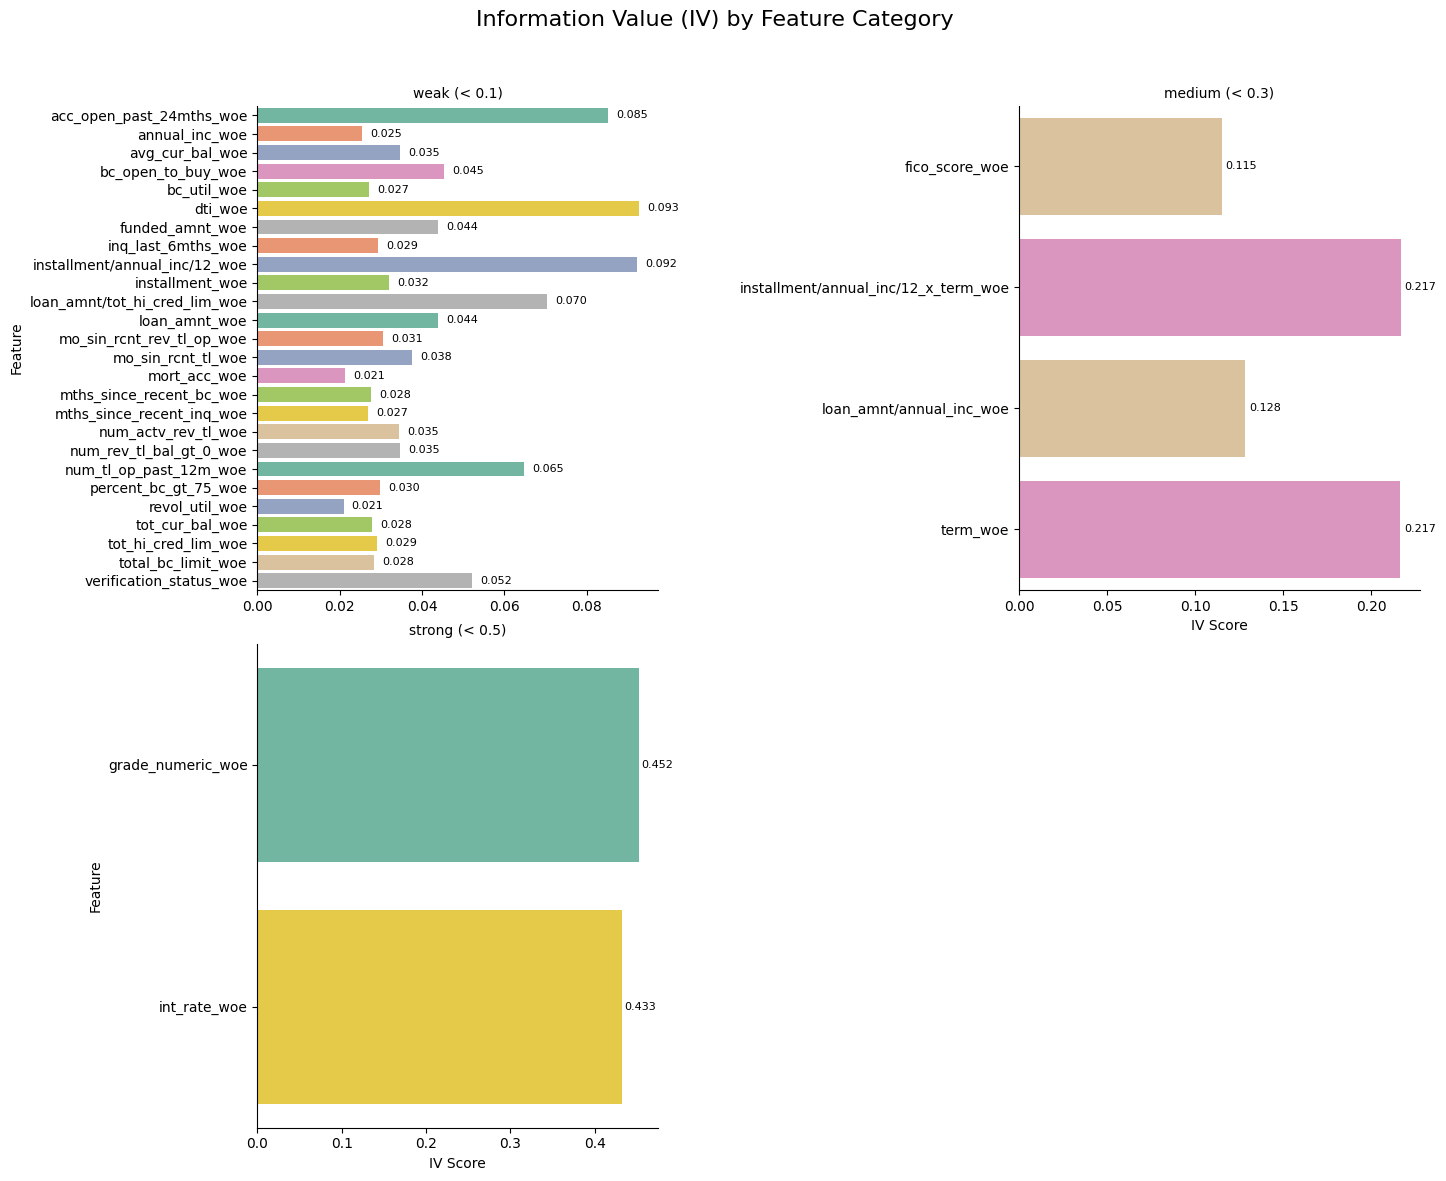

In [35]:
# == Obtain IV scores of each feature currently in train_pdf2 ==
updated_iv_categories_woe = {
    bucket: [
        (f"{feat}_woe", iv) for feat, iv in feats if f"{feat}_woe" in train_pdf2.columns
    ]
    for bucket, feats in updated_iv_categories.items()
}

plot_iv_by_category(updated_iv_categories_woe)

# 3. Multicollinearity Handling

Now, we will be identifying features which has high Variance Inflation Factor. For such features, we will find the cluster of features it has high correlation to (high similarity to), and then keep the one with highest IV / easier to interpret.


In [36]:
numeric_cols2 = [
    feature for feature in train_pdf2.columns if feature not in excluded_columns
]
keep_cols, drop_cols = calculate_vif_pandas(train_pdf2, numeric_cols2)


print("✅ Features to Keep (VIF <= 5.0):")
for feature, vif in sorted(keep_cols):
    print(f" - {feature}: {vif}")

print("\n❌ Features to Drop (VIF > 5.0):")
for feature, vif in sorted(drop_cols):
    print(f" - {feature}: {vif}")

✅ Features to Keep (VIF <= 5.0):
 - acc_open_past_24mths_woe: 2.25414840622554
 - annual_inc_woe: 3.478317959444162
 - bc_open_to_buy_woe: 4.965714647077464
 - bc_util_woe: 3.7996059036273144
 - dti_woe: 1.376996730337883
 - fico_score_woe: 1.8626185922637404
 - inq_last_6mths_woe: 1.8061993606387263
 - installment_woe: 4.870236805170898
 - loan_amnt/tot_hi_cred_lim_woe: 4.912590990308114
 - mo_sin_rcnt_rev_tl_op_woe: 2.5187693150316717
 - mo_sin_rcnt_tl_woe: 2.408364973585629
 - mort_acc_woe: 1.677362030250971
 - mths_since_recent_bc_woe: 1.7987824260596277
 - mths_since_recent_inq_woe: 1.766721734269328
 - num_tl_op_past_12m_woe: 2.710252828872695
 - percent_bc_gt_75_woe: 2.54712149477503
 - revol_util_woe: 2.400024913898078
 - term_woe: 2.4564461276748113
 - total_bc_limit_woe: 3.385885561670847
 - verification_status_woe: 1.1385907826721118

❌ Features to Drop (VIF > 5.0):
 - avg_cur_bal_woe: 5.021942259174205
 - funded_amnt_woe: 1584.0747229592605
 - grade_numeric_woe: 9.005228513

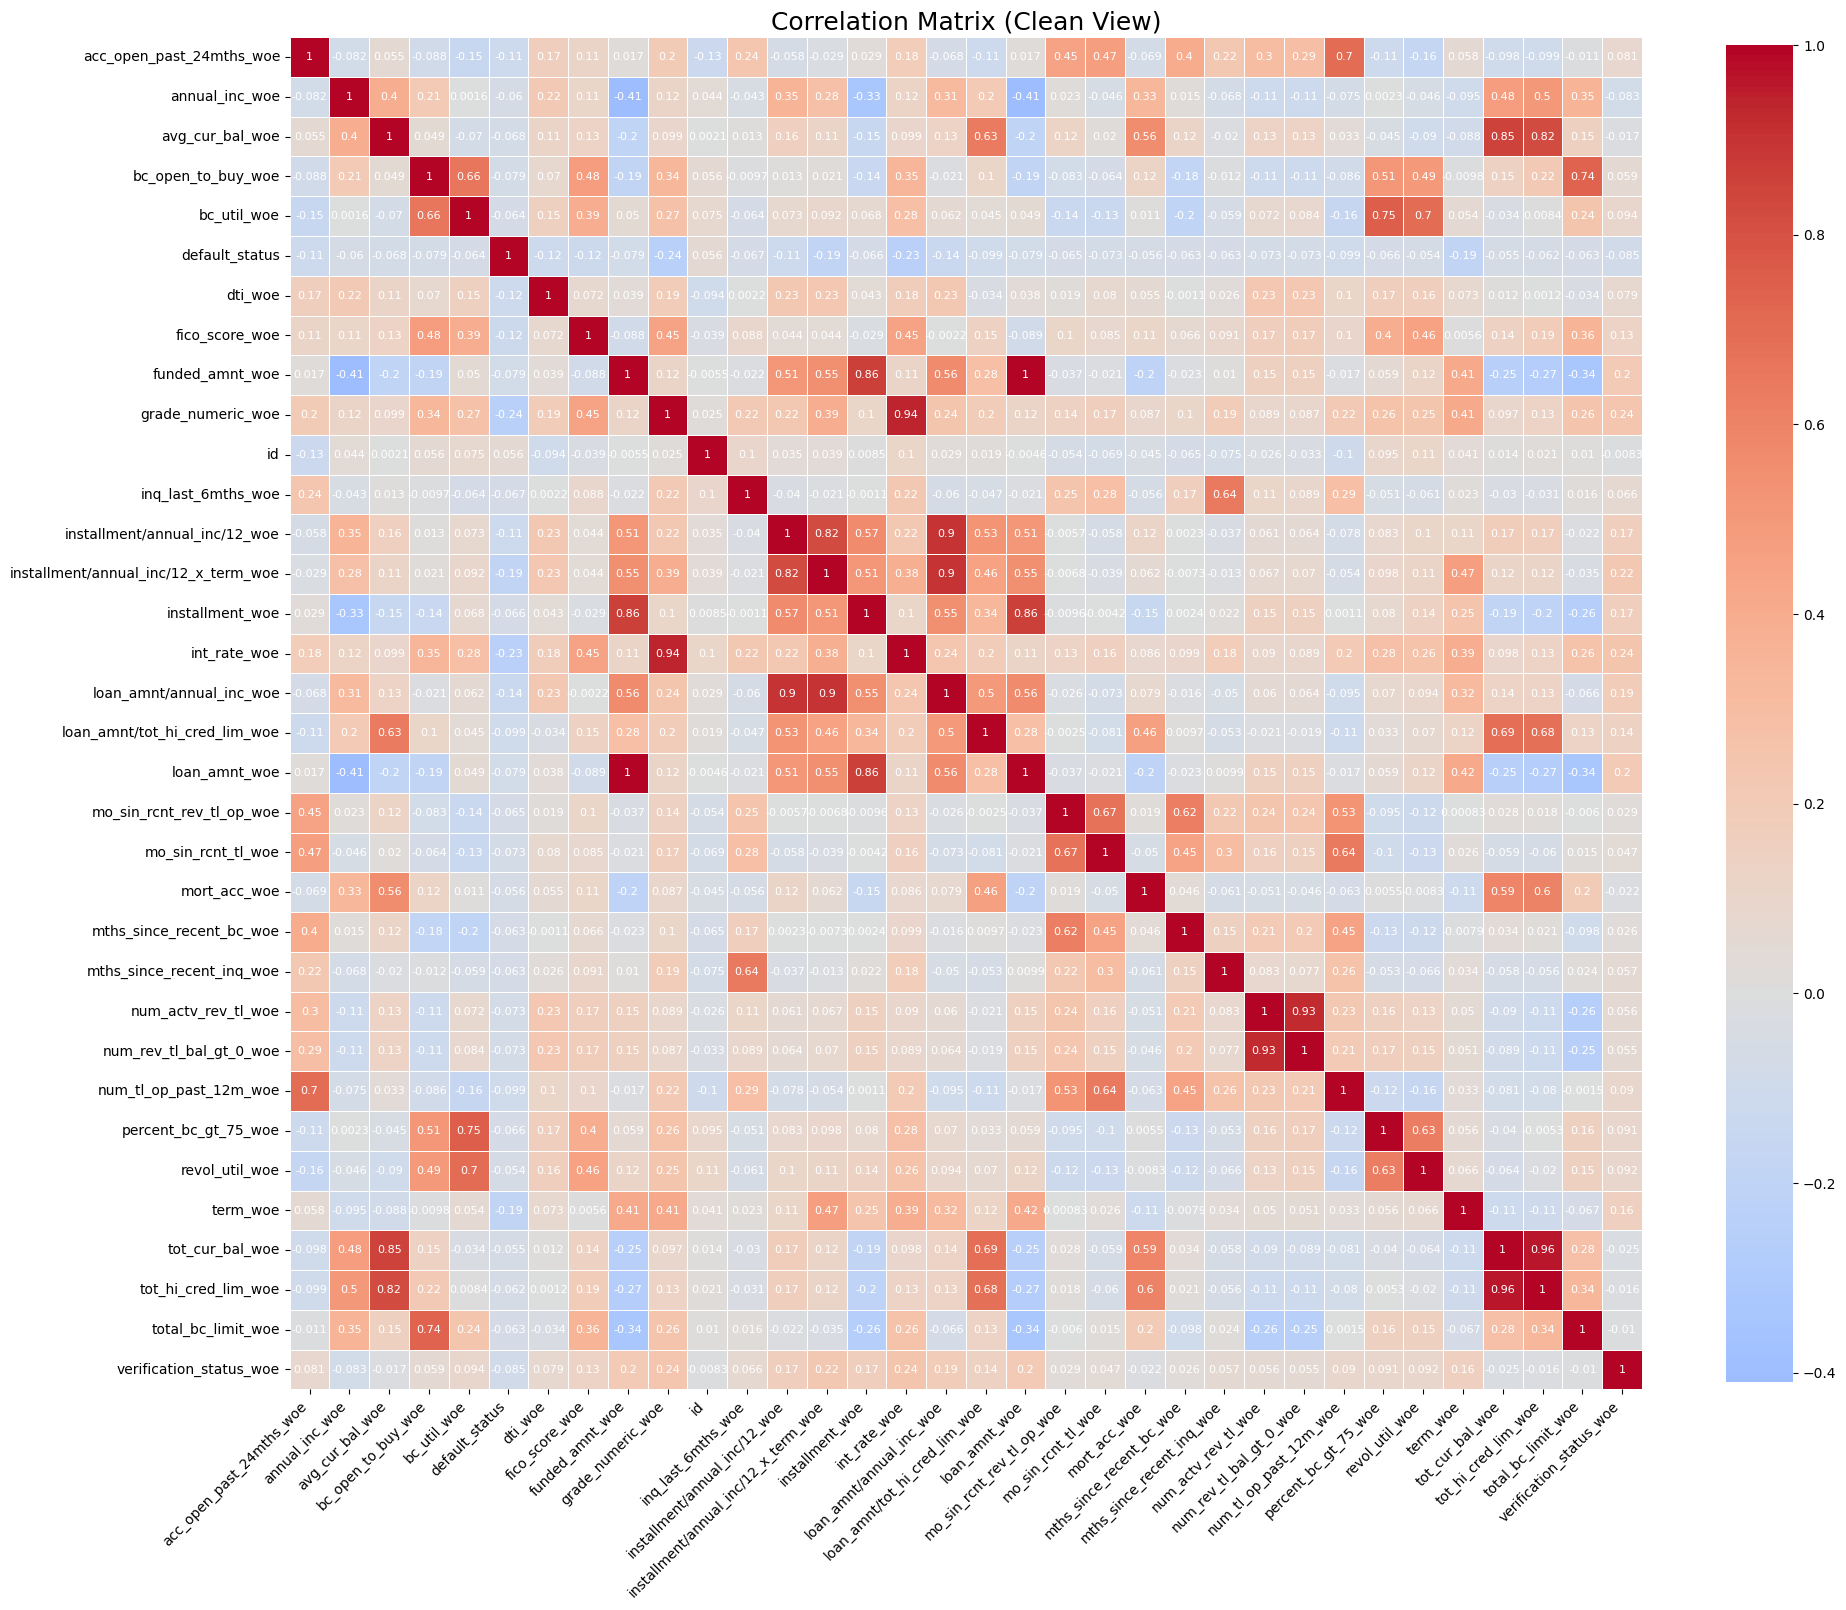

In [37]:
# == Check Correlation Matrix ==
threshold = 0.5
corr_matrix = train_pdf2.corr(numeric_only=True)
corr_matrix = corr_matrix.sort_index(axis=0).sort_index(axis=1)


plt.figure(figsize=(20, 20))

sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    annot_kws={"size": 8, "color": "white"},
    cbar_kws={"shrink": 0.7},
    annot=True,
)

plt.title("Correlation Matrix (Clean View)", fontsize=18)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [38]:
# ========= Helper: turn updated_iv_categories_woe into simple lookups =========
def _flatten_iv_dict(iv_dict):
    """Return:
    - iv_lookup:  {feature -> IV}
    - cat_lookup: {feature -> IV category (if available)}
    Accepts either:
      A) {"weak": [("x1", 0.03), ("x2", 0.05)], "medium": [...]}
      B) {"x1": 0.03, "x2": 0.05}
    """
    iv_lookup, cat_lookup = {}, {}
    if not isinstance(iv_dict, dict):
        return iv_lookup, cat_lookup

    for key, val in iv_dict.items():
        # Case A: category -> list of (feature, iv)
        if isinstance(val, list):
            category = str(key)
            for item in val:
                if isinstance(item, (list, tuple)) and len(item) >= 2:
                    feat, iv = item[0], item[1]
                elif isinstance(item, dict):
                    feat = item.get("feature") or item.get("Feature")
                    iv = item.get("iv") or item.get("IV")
                else:
                    continue
                try:
                    iv_lookup[str(feat)] = float(iv)
                    cat_lookup[str(feat)] = category
                except (TypeError, ValueError):
                    pass
        else:
            # Case B: feature -> iv
            try:
                iv_lookup[str(key)] = float(val)
            except (TypeError, ValueError):
                pass
    return iv_lookup, cat_lookup


# ========= Main reporter =========
def report_correlated_iv(
    features_to_drop,
    corr_matrix,
    updated_iv_categories_woe,
    corr_threshold=0.85,
    top_k_fallback=3,
    verbose=False,
):
    """
    For each feature in `features_to_drop`, list variables that are strongly correlated
    (|r| >= corr_threshold) in `corr_matrix`, and show their IV from
    `updated_iv_categories_woe`. If none meet the threshold, show top_k_fallback anyway.
    Returns a tidy DataFrame.
    """
    iv_lookup, cat_lookup = _flatten_iv_dict(updated_iv_categories_woe)

    corr = corr_matrix.copy()
    corr.index = corr.index.astype(str)
    corr.columns = corr.columns.astype(str)

    drops = (
        [str(f) for f, _v in features_to_drop]
        if isinstance(features_to_drop[0], (list, tuple))
        else [str(f) for f in features_to_drop]
    )
    present = [f for f in drops if f in corr.columns]
    missing = [f for f in drops if f not in corr.columns]

    if verbose and missing:
        print(f"[Info] Skipped (not in correlation matrix): {missing}")

    rows = []
    for drop_feat in present:
        s = corr.loc[drop_feat].drop(labels=[drop_feat], errors="ignore").dropna()
        if s.empty:
            if verbose:
                print(f"[Info] No correlations found for '{drop_feat}' (all NaN?)")
            continue

        # strong first
        strong = s[s.abs() >= corr_threshold].reindex(
            s.abs().sort_values(ascending=False).index
        )

        reason = "meets_threshold"
        if strong.empty:
            strong = s.reindex(s.abs().sort_values(ascending=False).index).head(
                top_k_fallback
            )
            reason = f"top_{top_k_fallback}_fallback"

        for other, r in strong.items():
            iv_val = iv_lookup.get(other)
            iv_cat = cat_lookup.get(other)
            rows.append(
                {
                    "Drop": drop_feat,
                    "CorrelatedWith": other,
                    "Corr": round(float(r), 4),
                    "IV": (round(float(iv_val), 4) if iv_val is not None else None),
                    "IV_Category": iv_cat,
                    "Reason": reason,
                }
            )

    out = pd.DataFrame(rows)
    if not out.empty:
        out = out.sort_values(
            ["Drop", "Reason", "Corr"], ascending=[True, True, False]
        ).reset_index(drop=True)
    else:
        if verbose:
            print(
                "[Info] No rows produced. Likely: name mismatch or all-NaN correlations."
            )
    return out


# ========= Use it with YOUR objects =========
# 1) Build the list of features to drop from your VIF output (you already printed them)
vif_drop_features = [
    feat for feat, vif in drop_cols
]  # <- drop_cols came from calculate_vif_pandas()

# 2) Run the report — requires you to have a dict named `updated_iv_categories_woe`
#    (either {category: [(feature, iv), ...]} OR {feature: iv})
correlated_iv_df = report_correlated_iv(
    features_to_drop=vif_drop_features,
    corr_matrix=corr_matrix,
    updated_iv_categories_woe=updated_iv_categories_woe,  # make sure this exists
    corr_threshold=0.85,
    top_k_fallback=3,
    verbose=True,
)

# 3) Print a clean, beginner-friendly view
if correlated_iv_df.empty:
    print(
        "\n(No strong correlations found at the chosen threshold; check names or lower the threshold.)"
    )
else:
    # Grouped, easy to scan:
    for drop_name, grp in correlated_iv_df.groupby("Drop", sort=True):
        print(f"\n=== If dropping: {drop_name} ===")
        print(
            grp[["CorrelatedWith", "Corr", "IV", "IV_Category", "Reason"]].to_string(
                index=False
            )
        )


=== If dropping: avg_cur_bal_woe ===
                      CorrelatedWith   Corr     IV    IV_Category          Reason
                     tot_cur_bal_woe 0.8516 0.0278   weak (< 0.1) meets_threshold
                 tot_hi_cred_lim_woe    NaN 0.0291   weak (< 0.1) meets_threshold
       loan_amnt/tot_hi_cred_lim_woe    NaN 0.0703   weak (< 0.1) meets_threshold
                        mort_acc_woe    NaN 0.0214   weak (< 0.1) meets_threshold
                      annual_inc_woe    NaN 0.0254   weak (< 0.1) meets_threshold
                     funded_amnt_woe    NaN 0.0440   weak (< 0.1) meets_threshold
                       loan_amnt_woe    NaN 0.0439   weak (< 0.1) meets_threshold
       installment/annual_inc/12_woe    NaN 0.0921   weak (< 0.1) meets_threshold
                  total_bc_limit_woe    NaN 0.0285   weak (< 0.1) meets_threshold
                     installment_woe    NaN 0.0320   weak (< 0.1) meets_threshold
                      fico_score_woe    NaN 0.1153 medium (<

In [39]:
train_pdf2.columns

Index(['acc_open_past_24mths_woe', 'annual_inc_woe', 'avg_cur_bal_woe',
       'bc_open_to_buy_woe', 'bc_util_woe', 'dti_woe', 'fico_score_woe',
       'funded_amnt_woe', 'grade_numeric_woe', 'inq_last_6mths_woe',
       'installment_woe', 'int_rate_woe', 'loan_amnt_woe',
       'mo_sin_rcnt_rev_tl_op_woe', 'mo_sin_rcnt_tl_woe', 'mort_acc_woe',
       'mths_since_recent_bc_woe', 'mths_since_recent_inq_woe',
       'num_actv_rev_tl_woe', 'num_rev_tl_bal_gt_0_woe',
       'num_tl_op_past_12m_woe', 'percent_bc_gt_75_woe', 'revol_util_woe',
       'term_woe', 'tot_cur_bal_woe', 'tot_hi_cred_lim_woe',
       'total_bc_limit_woe', 'verification_status_woe',
       'installment/annual_inc/12_woe', 'installment/annual_inc/12_x_term_woe',
       'loan_amnt/annual_inc_woe', 'loan_amnt/tot_hi_cred_lim_woe', 'id',
       'default_status', 'issue_d'],
      dtype='object')

In [40]:
train_pdf2_1 = train_pdf2.drop(
    columns=[
        "grade_numeric_woe",
        "loan_amnt_woe",
        "tot_cur_bal_woe",
        "grade_numeric_woe",
        "installment/annual_inc/12_woe",
        "installment/annual_inc/12_x_term_woe",
        "installment_woe",
        "num_rev_tl_bal_gt_0_woe",
        "tot_hi_cred_lim_woe",
        "funded_amnt_woe",
    ]
)

In [41]:
run_model_checkpoint(
    train_pdf2_1,
    test_pdf2,
    "log_reg_multicol_drop",
    "Logistic Regression",
    NOTEBOOK_RUN_NAME,
)


✅ Best F1 Score = 0.4091 at threshold = 0.46

📄 Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

 Non-Default     0.8930    0.5695    0.6955     20627
     Default     0.2862    0.7166    0.4090      4968

    accuracy                         0.5981     25595
   macro avg     0.5896    0.6431    0.5523     25595
weighted avg     0.7752    0.5981    0.6399     25595



Our final evaluation metrics throughout the lifetime of outlier handling -> feature engineering -> woe-transformation -> multicollinearity handling are shown below in WandB. The current model is tuned to prioritize identifying as many default cases as possible, achieving strong recall on the default class. This comes at the cost of a higher false positive rate, meaning more non-default cases are flagged for review. If the objective shifts toward improving precision and reducing unnecessary interventions, further refinements in feature engineering, model selection, and threshold calibration will be required.

| Metric             | Value   | What It Means                                                                                 |
| ------------------ | ------- | --------------------------------------------------------------------------------------------- |
| **Accuracy**       | 0.59809 | About **60%** of predictions were correct overall.                                            |
| **Precision**      | 0.2862  | When the model predicted "positive", it was right about **29%** of the time.                  |
| **Recall**         | 0.71659 | The model caught about **72%** of all actual positives.                                       |
| **F1 Score**       | 0.40903 | Balance between precision & recall — good for seeing trade-off.                               |
| **Gini**           | 0.3885  | Measure of model's ability to rank correctly; higher means better separation between classes. |
| **Best Threshold** | 0.45704 | Probability cut-off chosen for best F1 score.                                                 |

<br><br>

**Guide to the Metrics**

- **Accuracy** → How often the model is right overall.
- **Precision** → Of all predicted positives, how many were actually correct (~0.3 signifies our model would produce more false alarms, in order to catch more possible defaults)
- **Recall** → Of all actual positives, how many the model found (0.72 signfies our model performs well on catching suspicious loans based on the borrowers' demographics, and credit history)
- **F1 Score** → A single number that combines precision & recall (useful for unbalanced data) -> weighted metric between precision and recall
- **Gini** → How well the model can distinguish between classes (Model assigns higher risk score to default cause 70% of the time -> usable with business rules)
- **Best Threshold** → The decision cut-off where the model performs best, in logistic regression model, for F1 score optimisation.

![Screenshot 2025-08-11 at 20.42.09.png](<attachment:Screenshot 2025-08-11 at 20.42.09.png>)

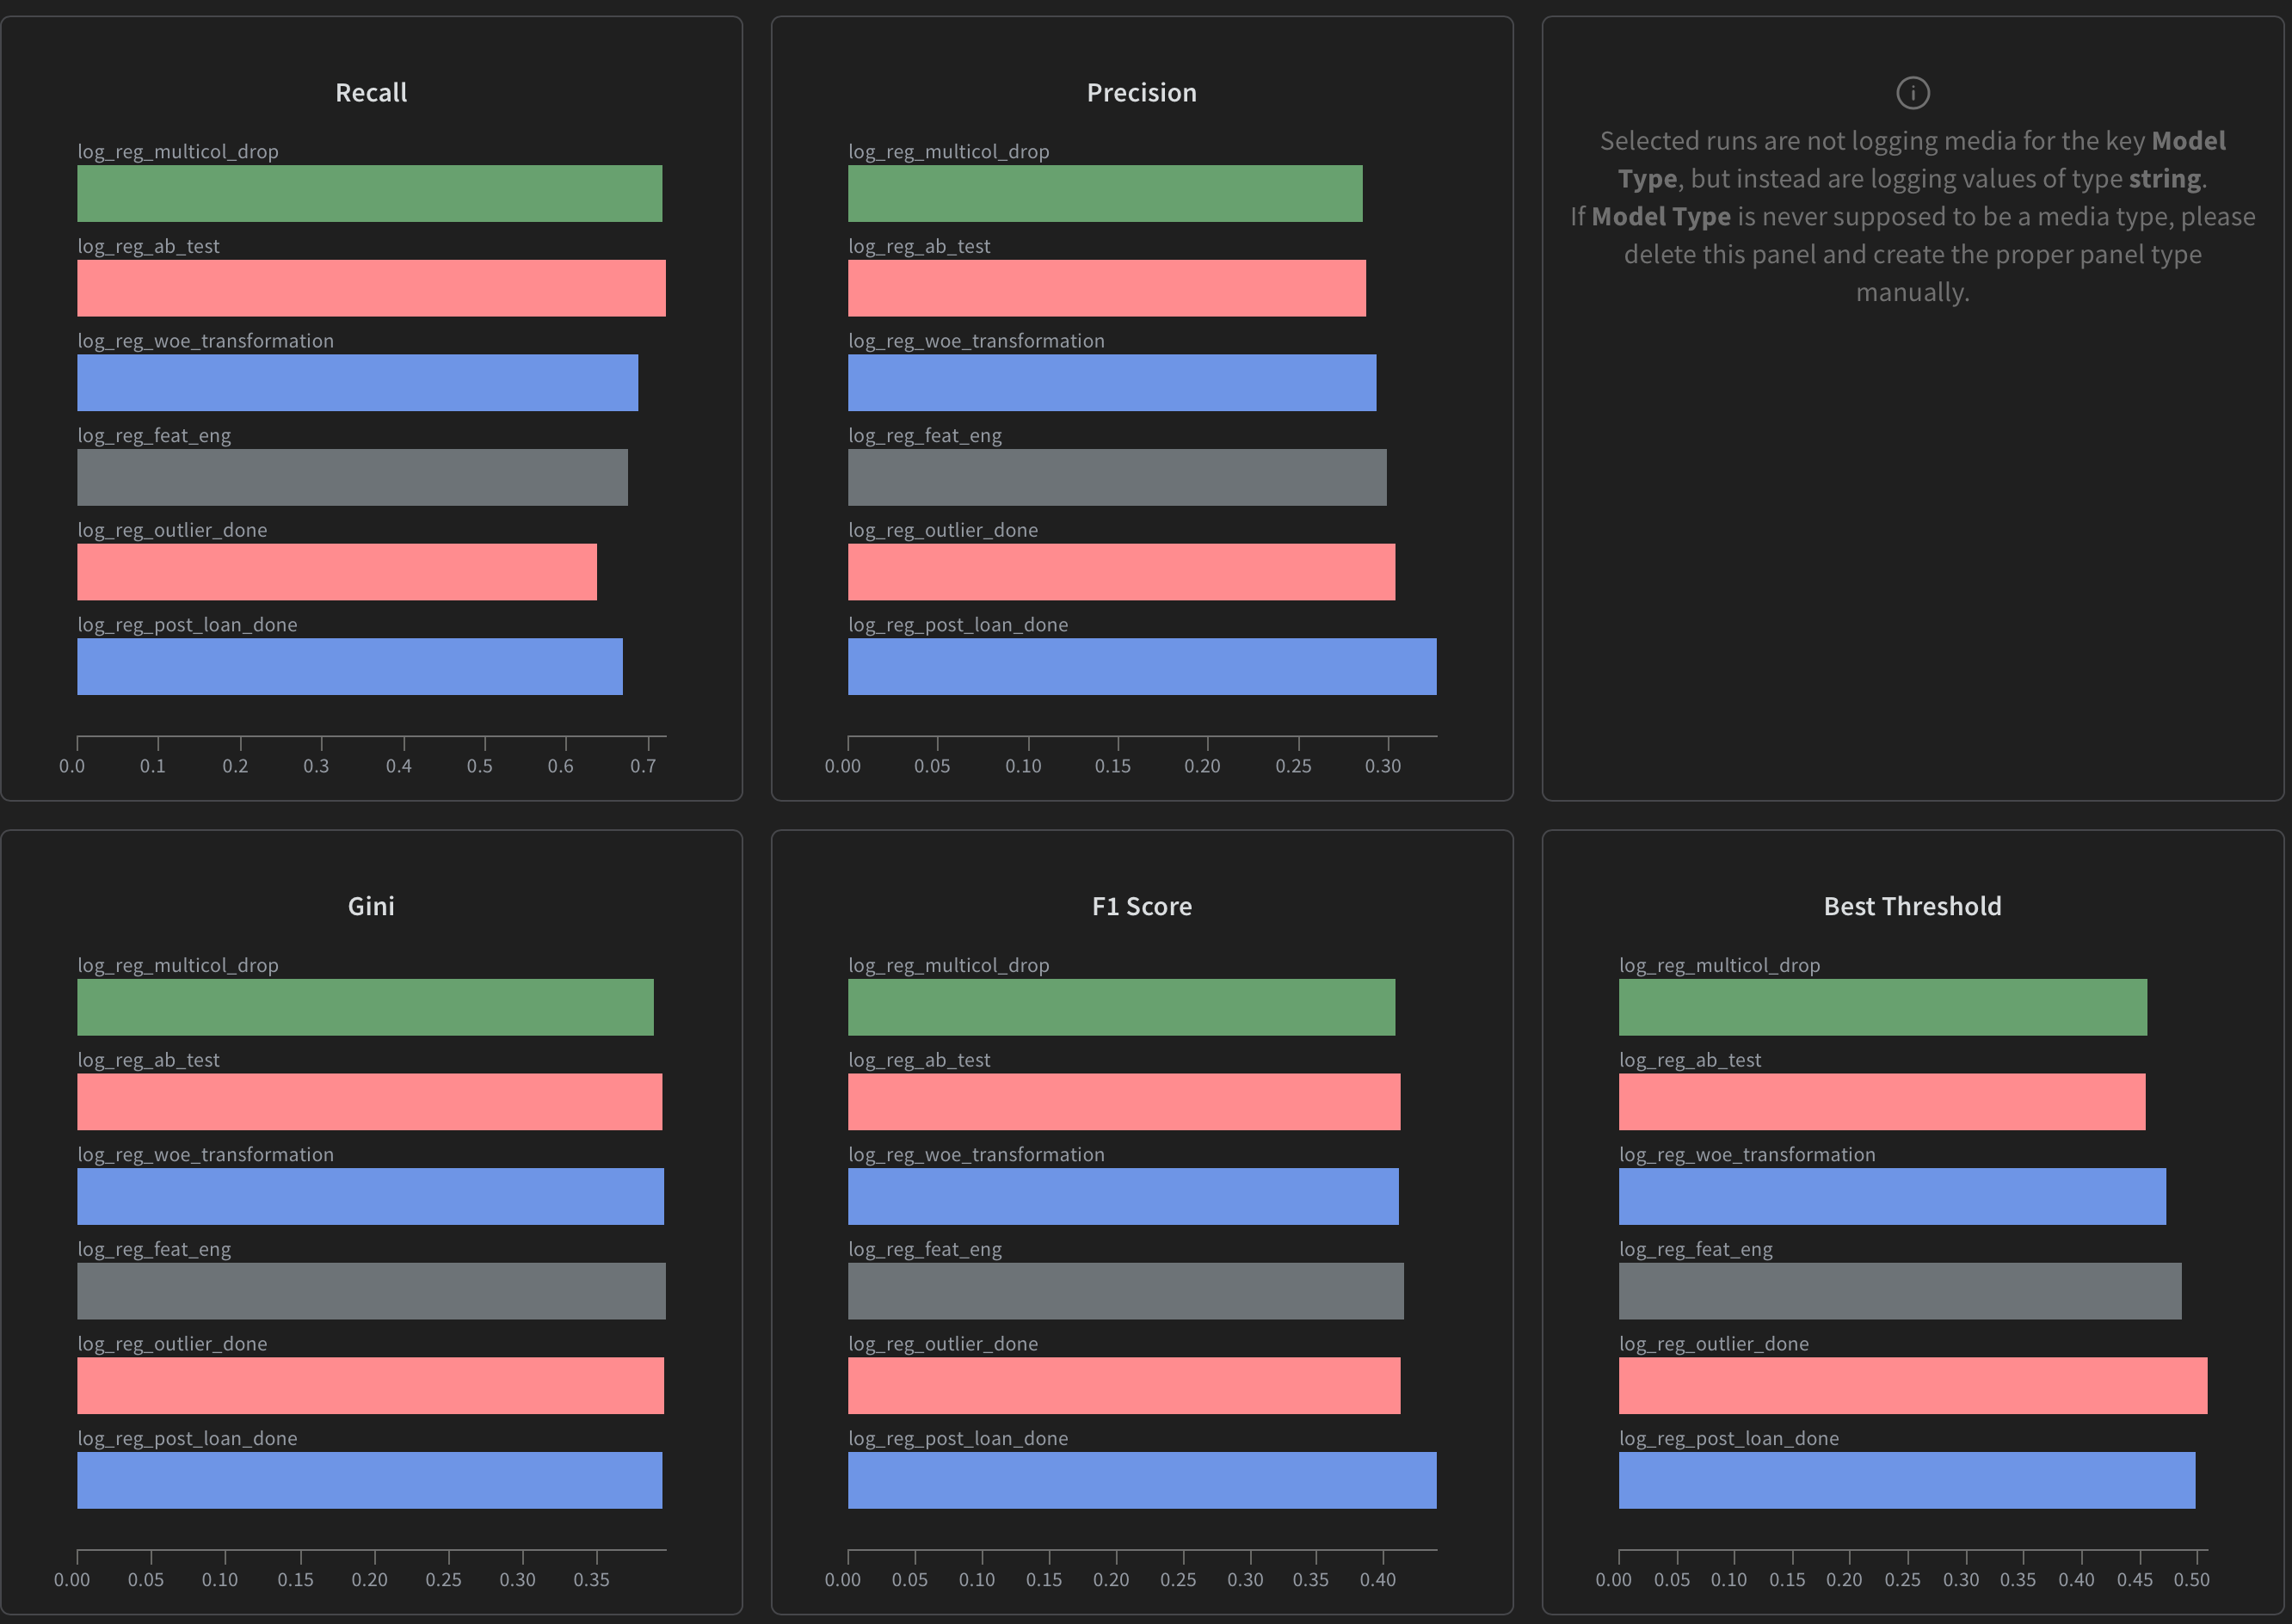

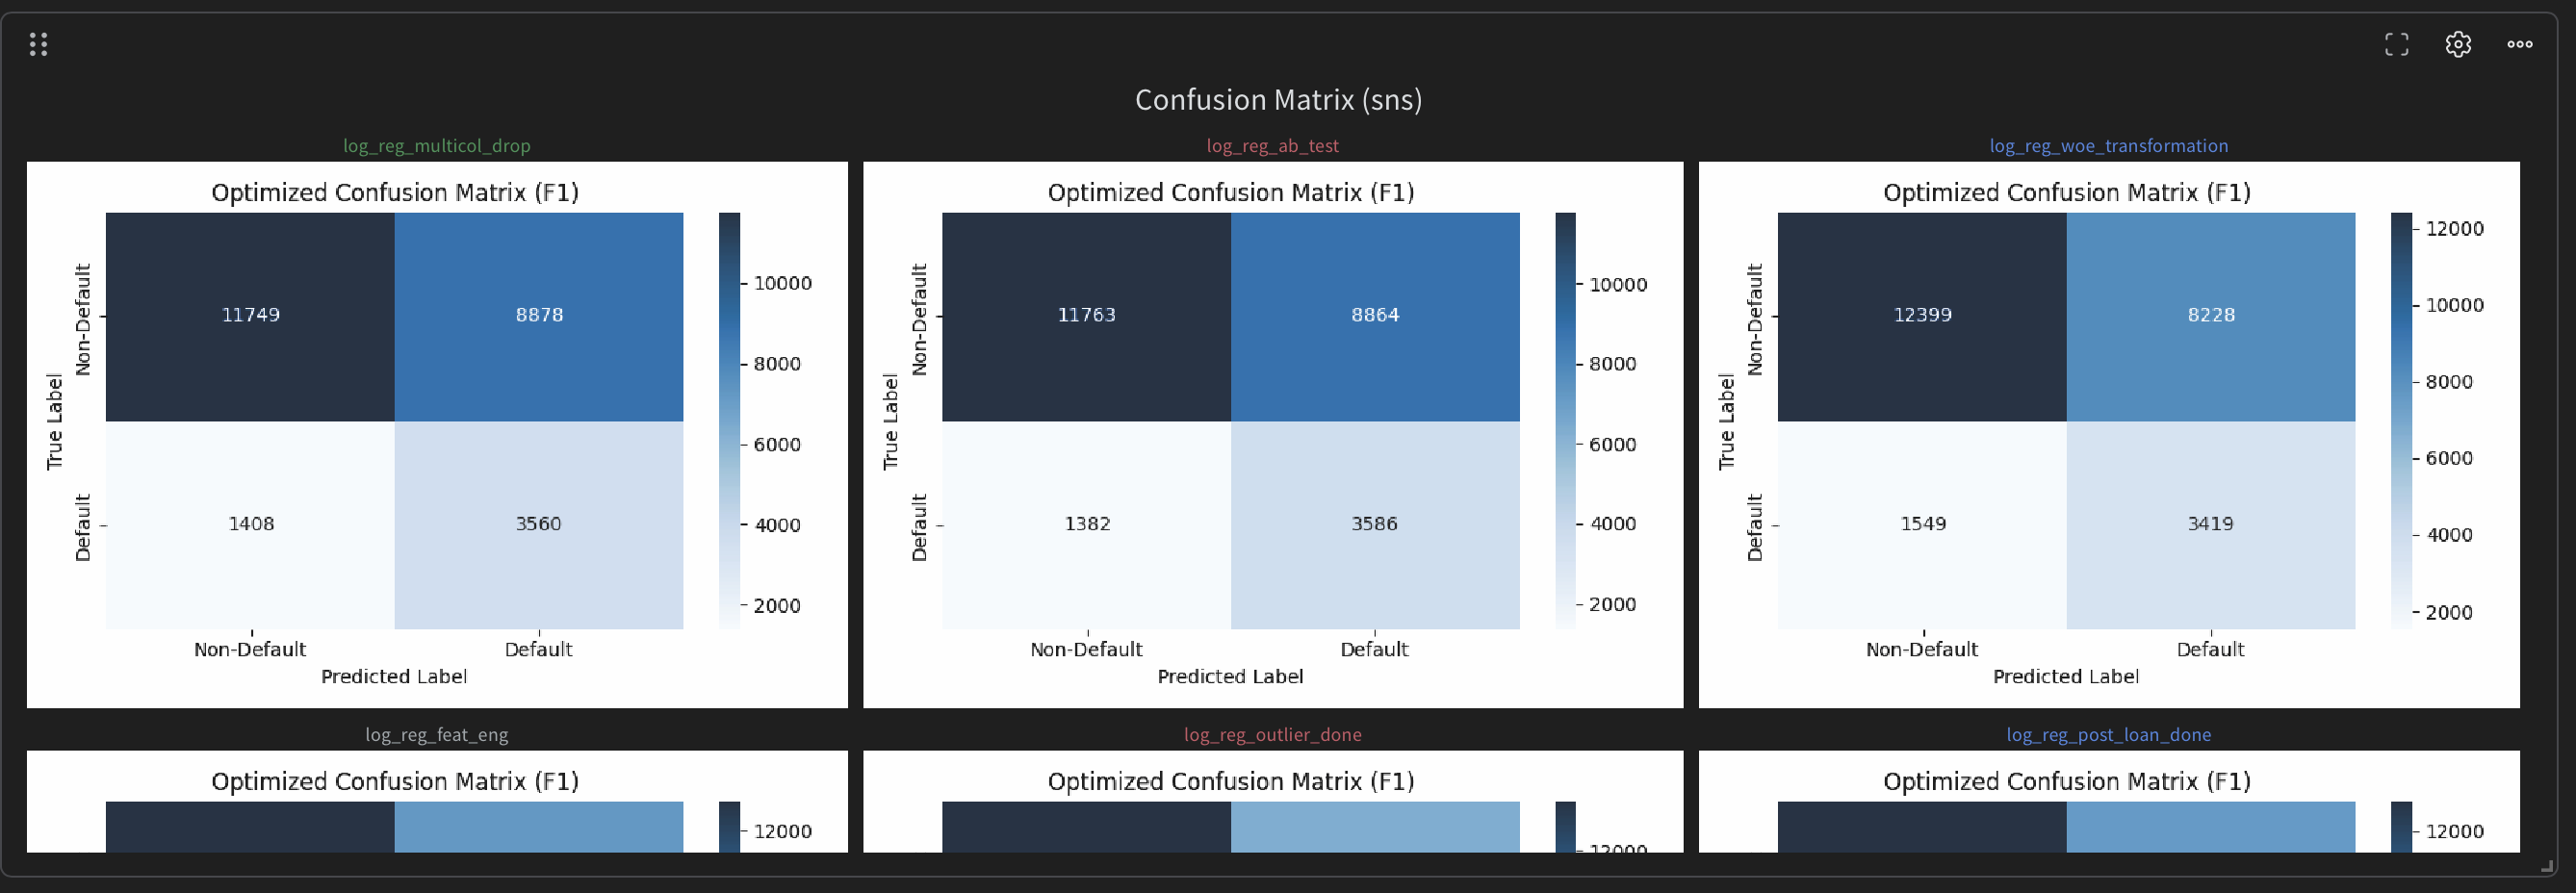

In [ ]:
sorted(train_pdf2_1.columns)

['acc_open_past_24mths_woe',
 'annual_inc_woe',
 'avg_cur_bal_woe',
 'bc_open_to_buy_woe',
 'bc_util_woe',
 'default_status',
 'dti_woe',
 'fico_score_woe',
 'id',
 'inq_last_6mths_woe',
 'int_rate_woe',
 'issue_d',
 'loan_amnt/annual_inc_woe',
 'loan_amnt/tot_hi_cred_lim_woe',
 'mo_sin_rcnt_rev_tl_op_woe',
 'mo_sin_rcnt_tl_woe',
 'mort_acc_woe',
 'mths_since_recent_bc_woe',
 'mths_since_recent_inq_woe',
 'num_actv_rev_tl_woe',
 'num_tl_op_past_12m_woe',
 'percent_bc_gt_75_woe',
 'revol_util_woe',
 'term_woe',
 'total_bc_limit_woe',
 'verification_status_woe']